In [108]:
%matplotlib inline

import os
import pandas as pd 
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from IPython.display import display



mpl.rc("figure", figsize=(100, 70))
mpl.rcParams.update({'font.size':55})

pd.set_option('display.max_columns', 500)

## Loading Data

In [109]:
merged_data = pd.read_csv("../data/train/merged_data_after_feature_engineering.csv")

item_data = pd.read_csv("../data/train/item_data.csv")
customer_demo = pd.read_csv("../data/train/customer_demographics.csv")
customer_transaction_data_on_coupons = pd.read_csv("../data/train/customer_transaction_data_on_coupons.csv" )
customer_transaction_data_without_coupons=  pd.read_csv("../data/train/customer_transaction_data_without_coupons.csv" )

customer_transaction_data = customer_transaction_data_without_coupons.append(customer_transaction_data_on_coupons)

In [110]:
merged_data

campaign_id  coupon_id  customer_id      id  is_test  \
0                22        869          967       3        1   
1                20        389         1566       4        1   
2                22        981          510       5        1   
3                25       1069          361       8        1   
4                17        498          811      10        1   
...             ...        ...          ...     ...      ...   
128590            8         71         1523  128587        0   
128591           30        547          937  128589        0   
128592            8        754         1004  128590        0   
128593           13        134           71  128592        0   
128594           13        681          623  128595        0   

        redemption_status  campaign_type campaign_start_date  \
0                     NaN              0          2013-09-16   
1                     NaN              1          2013-09-07   
2                     NaN              0          2013-09-16   
3                     NaN              1          2013-10-21   
4                     NaN              1          2013-07-29   
...                   ...            ...                 ...   
128590                0.0              0          2013-02-16   
128591                0.0              0          2012-11-19   
128592                0.0              0          2013-02-16   
128593                0.0              0          2013-05-19   
128594                0.0              0          2013-05-19   

       campaign_end_date                       coupon_available_on_item_ids  \
0             2013-10-18  1124,1185,39835,46911,3514,1033,45271,56179,40...   
1             2013-11-16  47705,45063,19431,56517,1479,68534,56523,1144,...   
2             2013-10-18  1690,7061,58004,22631,6577,2398,41769,21773,33...   
3             2013-11-22  10284,70009,57994,11281,44510,35356,29737,6994...   
4             2013-08-30  45021,54805,14259,37463,48668,16481,4078,19852...   
...                  ...                                                ...   
128590        2013-04-05                             17029,1657,30155,12762   
128591        2013-01-04            2596,18777,53061,42386,43044,3318,39336   
128592        2013-04-05  70460,70534,9060,27164,58588,20849,5608,24948,...   
128593        2013-07-05            62219,1357,38776,41148,32563,62457,4047   
128594        2013-07-05  44676,33551,16298,28879,40280,18577,13290,7323...   

        customer_age_range  customer_marital_status  is_customer_rented  \
0                        3                        0                 0.0   
1                        2                        1                 0.0   
2                        2                        1                 0.0   
3                        1                        0                 0.0   
4                       -1                       -1                -1.0   
...                    ...                      ...                 ...   
128590                   6                        1                 0.0   
128591                   6                        1                 0.0   
128592                  -1                       -1                -1.0   
128593                   3                        1                 0.0   
128594                  -1                       -1                -1.0   

        customer_family_size  customer_no_of_children  \
0                          1                        0   
1                          2                        0   
2                          2                        1   
3                          1                        0   
4                         -1                       -1   
...                      ...                      ...   
128590                     2                        0   
128591                     2                        0   
128592                    -1                       -1   
128593                     5                      

In [111]:
merged_data.columns

Index(['campaign_id', 'coupon_id', 'customer_id', 'id', 'is_test',
       'redemption_status', 'campaign_type', 'campaign_start_date',
       'campaign_end_date', 'coupon_available_on_item_ids',
       'customer_age_range', 'customer_marital_status', 'is_customer_rented',
       'customer_family_size', 'customer_no_of_children',
       'customer_income_bracket',
       'is_common_demographic_info_available_for_customer',
       'no_of_items_coupon_is_available_for',
       'is_coupon_available_for_multiple_item_ids',
       'no_of_categories_of_items_available_under_coupon',
       'coupon_available_on_category_1', 'coupon_available_on_category_2',
       'coupon_available_on_brand_1', 'coupon_available_on_brand_2',
       'coupon_more_focussed_on_brand_type', 'popularity_of_category1',
       'popularity_of_category2', 'popularity_of_brand1',
       'popularity_of_brand2', 'mean_discount_on_category1',
       'mean_discount_on_category2', 'mean_discount_on_brand1',
       'mean_discou

## Generating More Features

### does_user_significantly_prefer_focussed_brand_type

In [6]:
brand_type_counts = customer_transaction_data.groupby(by=['customer_id', 'brand_type'])['brand_type'].agg('count')
brand_type_counts 

customer_id  brand_type 
1            Established    958
             Local           90
2            Established    327
             Local           92
3            Established    593
                           ... 
1580         Local           72
1581         Established    354
             Local          151
1582         Established    689
             Local          161
Name: brand_type, Length: 3164, dtype: int64

In [7]:
def get_preferred_brand_type (row):
    if (row.coupon_more_focussed_on_brand_type == 'Established'):
        if (brand_type_counts[row.customer_id, 'Established'] > 2*brand_type_counts[row.customer_id, 'Local']):
            return 1
        else:
            return 0
            
    if (row.coupon_more_focussed_on_brand_type == 'Local'):
        if (brand_type_counts[row.customer_id, 'Local'] > brand_type_counts[row.customer_id, 'Established']):
            return 1
        else:
            return 0
merged_data['does_user_significantly_prefer_focussed_brand_type'] = merged_data.apply(get_preferred_brand_type, axis=1)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


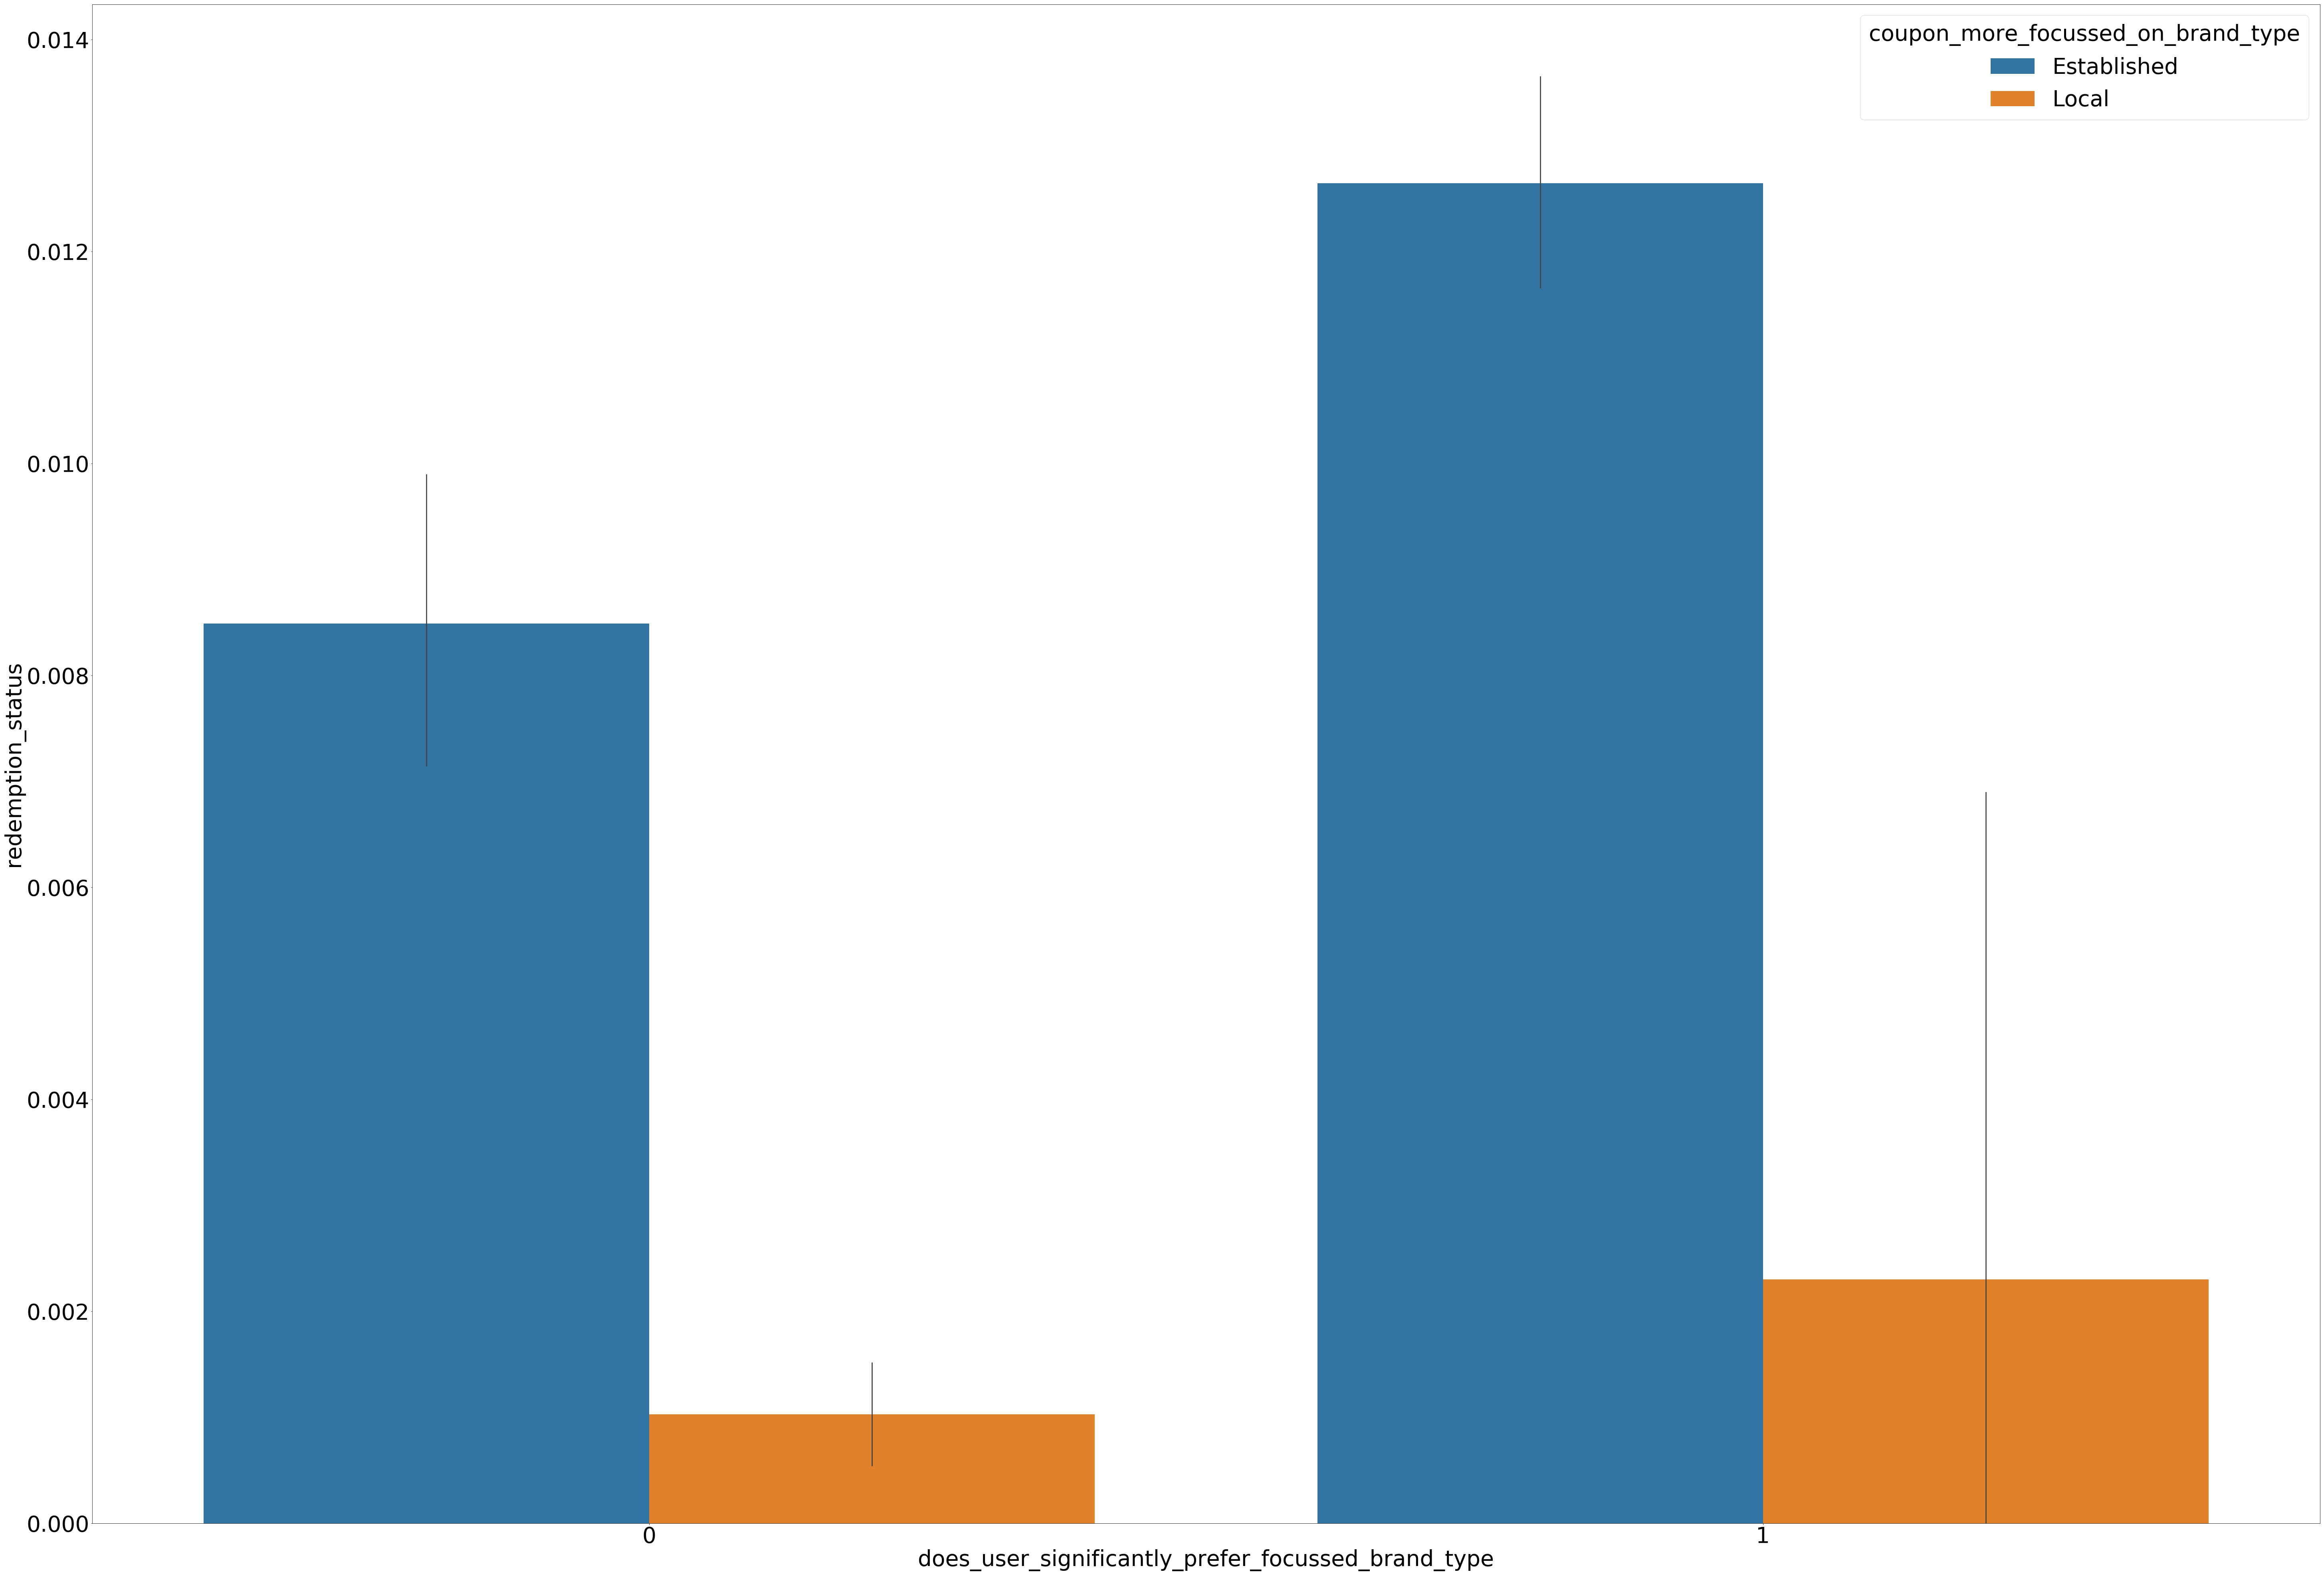

In [8]:
sns.barplot(x="does_user_significantly_prefer_focussed_brand_type", y="redemption_status", hue="coupon_more_focussed_on_brand_type", data=merged_data)

### does_user_prefer_category1_from_brand1

In [9]:
brand_count = customer_transaction_data.groupby(by=['customer_id', 'category','brand'])['brand'].agg('count')
brand_count

customer_id  category          brand
1            Bakery            1        7
                               56       5
                               154      5
                               468      2
                               574      2
                                       ..
1582         Seafood           3203     1
                               4898     1
             Skin & Hair Care  866      1
                               2479     1
                               4357     1
Name: brand, Length: 270693, dtype: int64

In [10]:
category_count = customer_transaction_data.groupby(by=['customer_id', 'category'])['brand'].agg('count')
category_count

customer_id  category              
1            Bakery                     26
             Dairy, Juices & Snacks     14
             Grocery                   774
             Meat                        2
             Natural Products           14
                                      ... 
1582         Packaged Meat              24
             Pharmaceutical            198
             Prepared Food               3
             Seafood                     4
             Skin & Hair Care            3
Name: brand, Length: 17190, dtype: int64

In [11]:
def get_preference_of_brand1_in_category1(row):
    try:
        preference_ratio = brand_count[row.customer_id, row.coupon_available_on_category_1, row.coupon_available_on_brand_1]/category_count[row.customer_id, row.coupon_available_on_category_1]
        
        if (preference_ratio > 0.25):
            return 1
        else:
            return 0
    except:
        return 0
merged_data['does_user_prefer_category1_from_brand1'] = merged_data.apply(get_preference_of_brand1_in_category1, axis=1)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


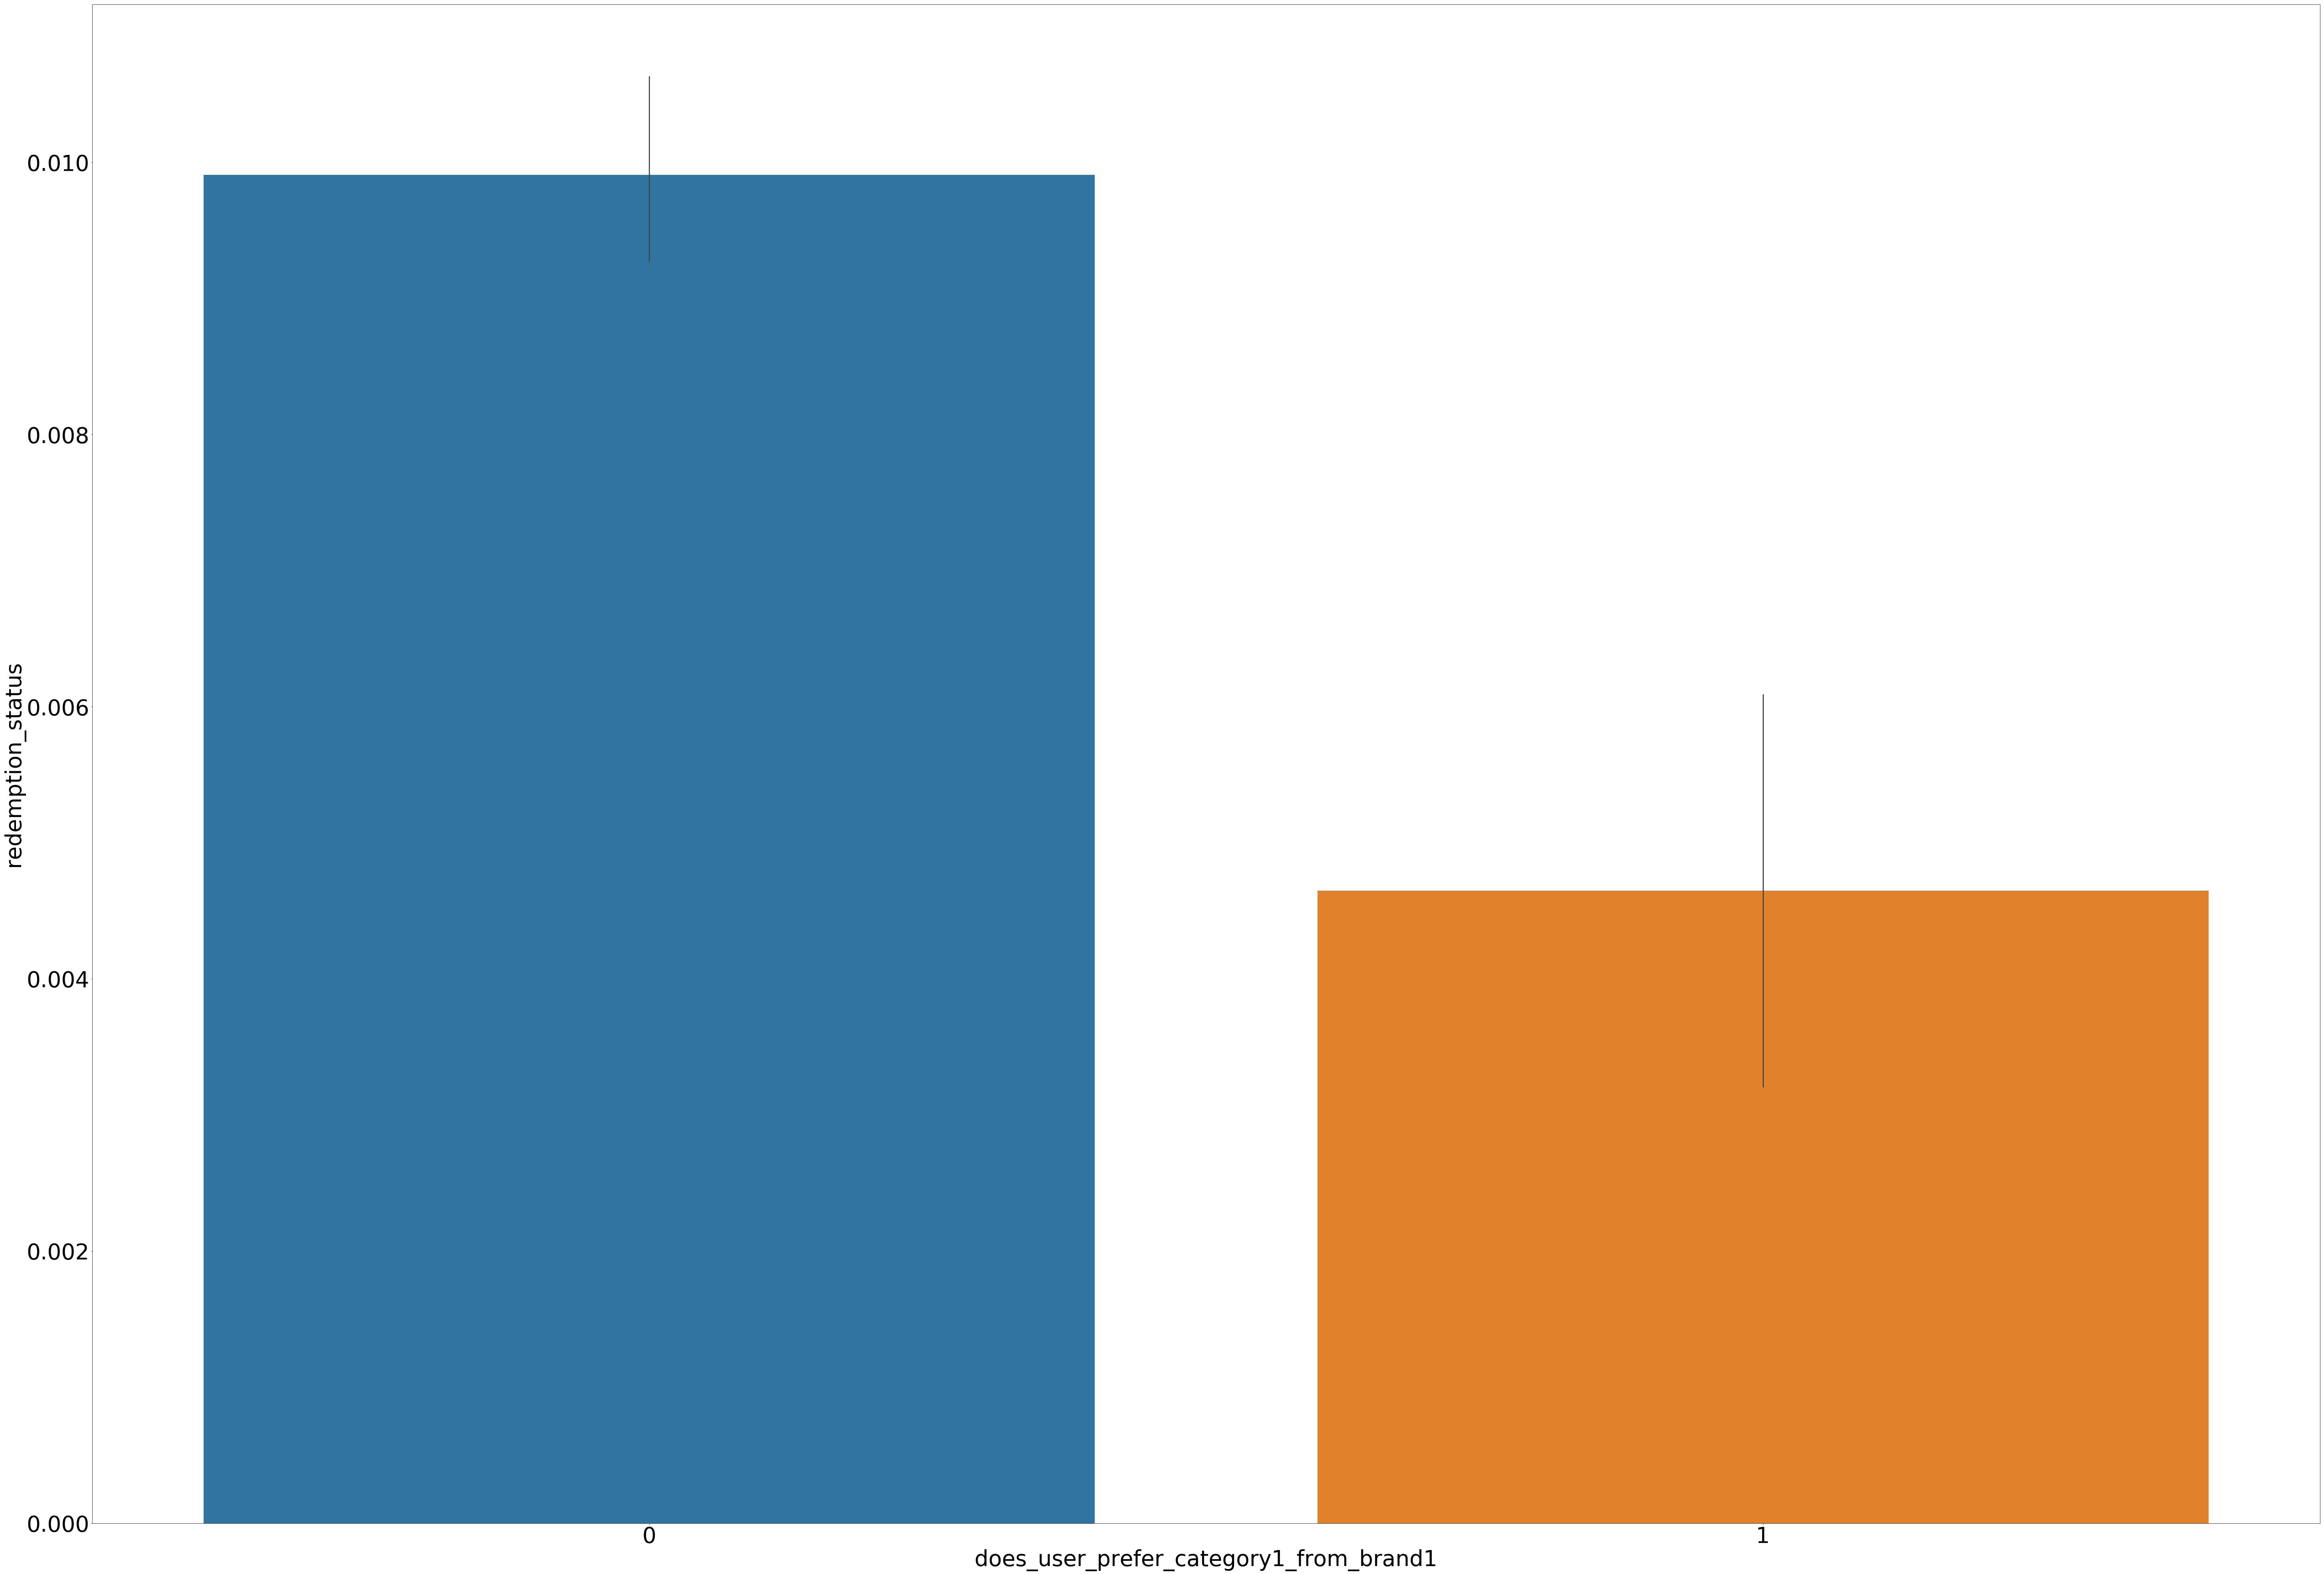

In [12]:
sns.barplot(x="does_user_prefer_category1_from_brand1", y="redemption_status",data=merged_data)

In [13]:
merged_data.redemption_status.mean()

0.00930214753282548

### does_user_prefer_category1_from_brand2

In [14]:
def get_preference_of_brand2_in_category1(row):
    try:
        preference_ratio = brand_count[row.customer_id, row.coupon_available_on_category_1, row.coupon_available_on_brand_2]/category_count[row.customer_id, row.coupon_available_on_category_1]
        
        if (preference_ratio > 0.15):
            return 1
        else:
            return 0
    except:
        return 0
merged_data['does_user_prefer_category1_from_brand2'] = merged_data.apply(get_preference_of_brand2_in_category1, axis=1)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


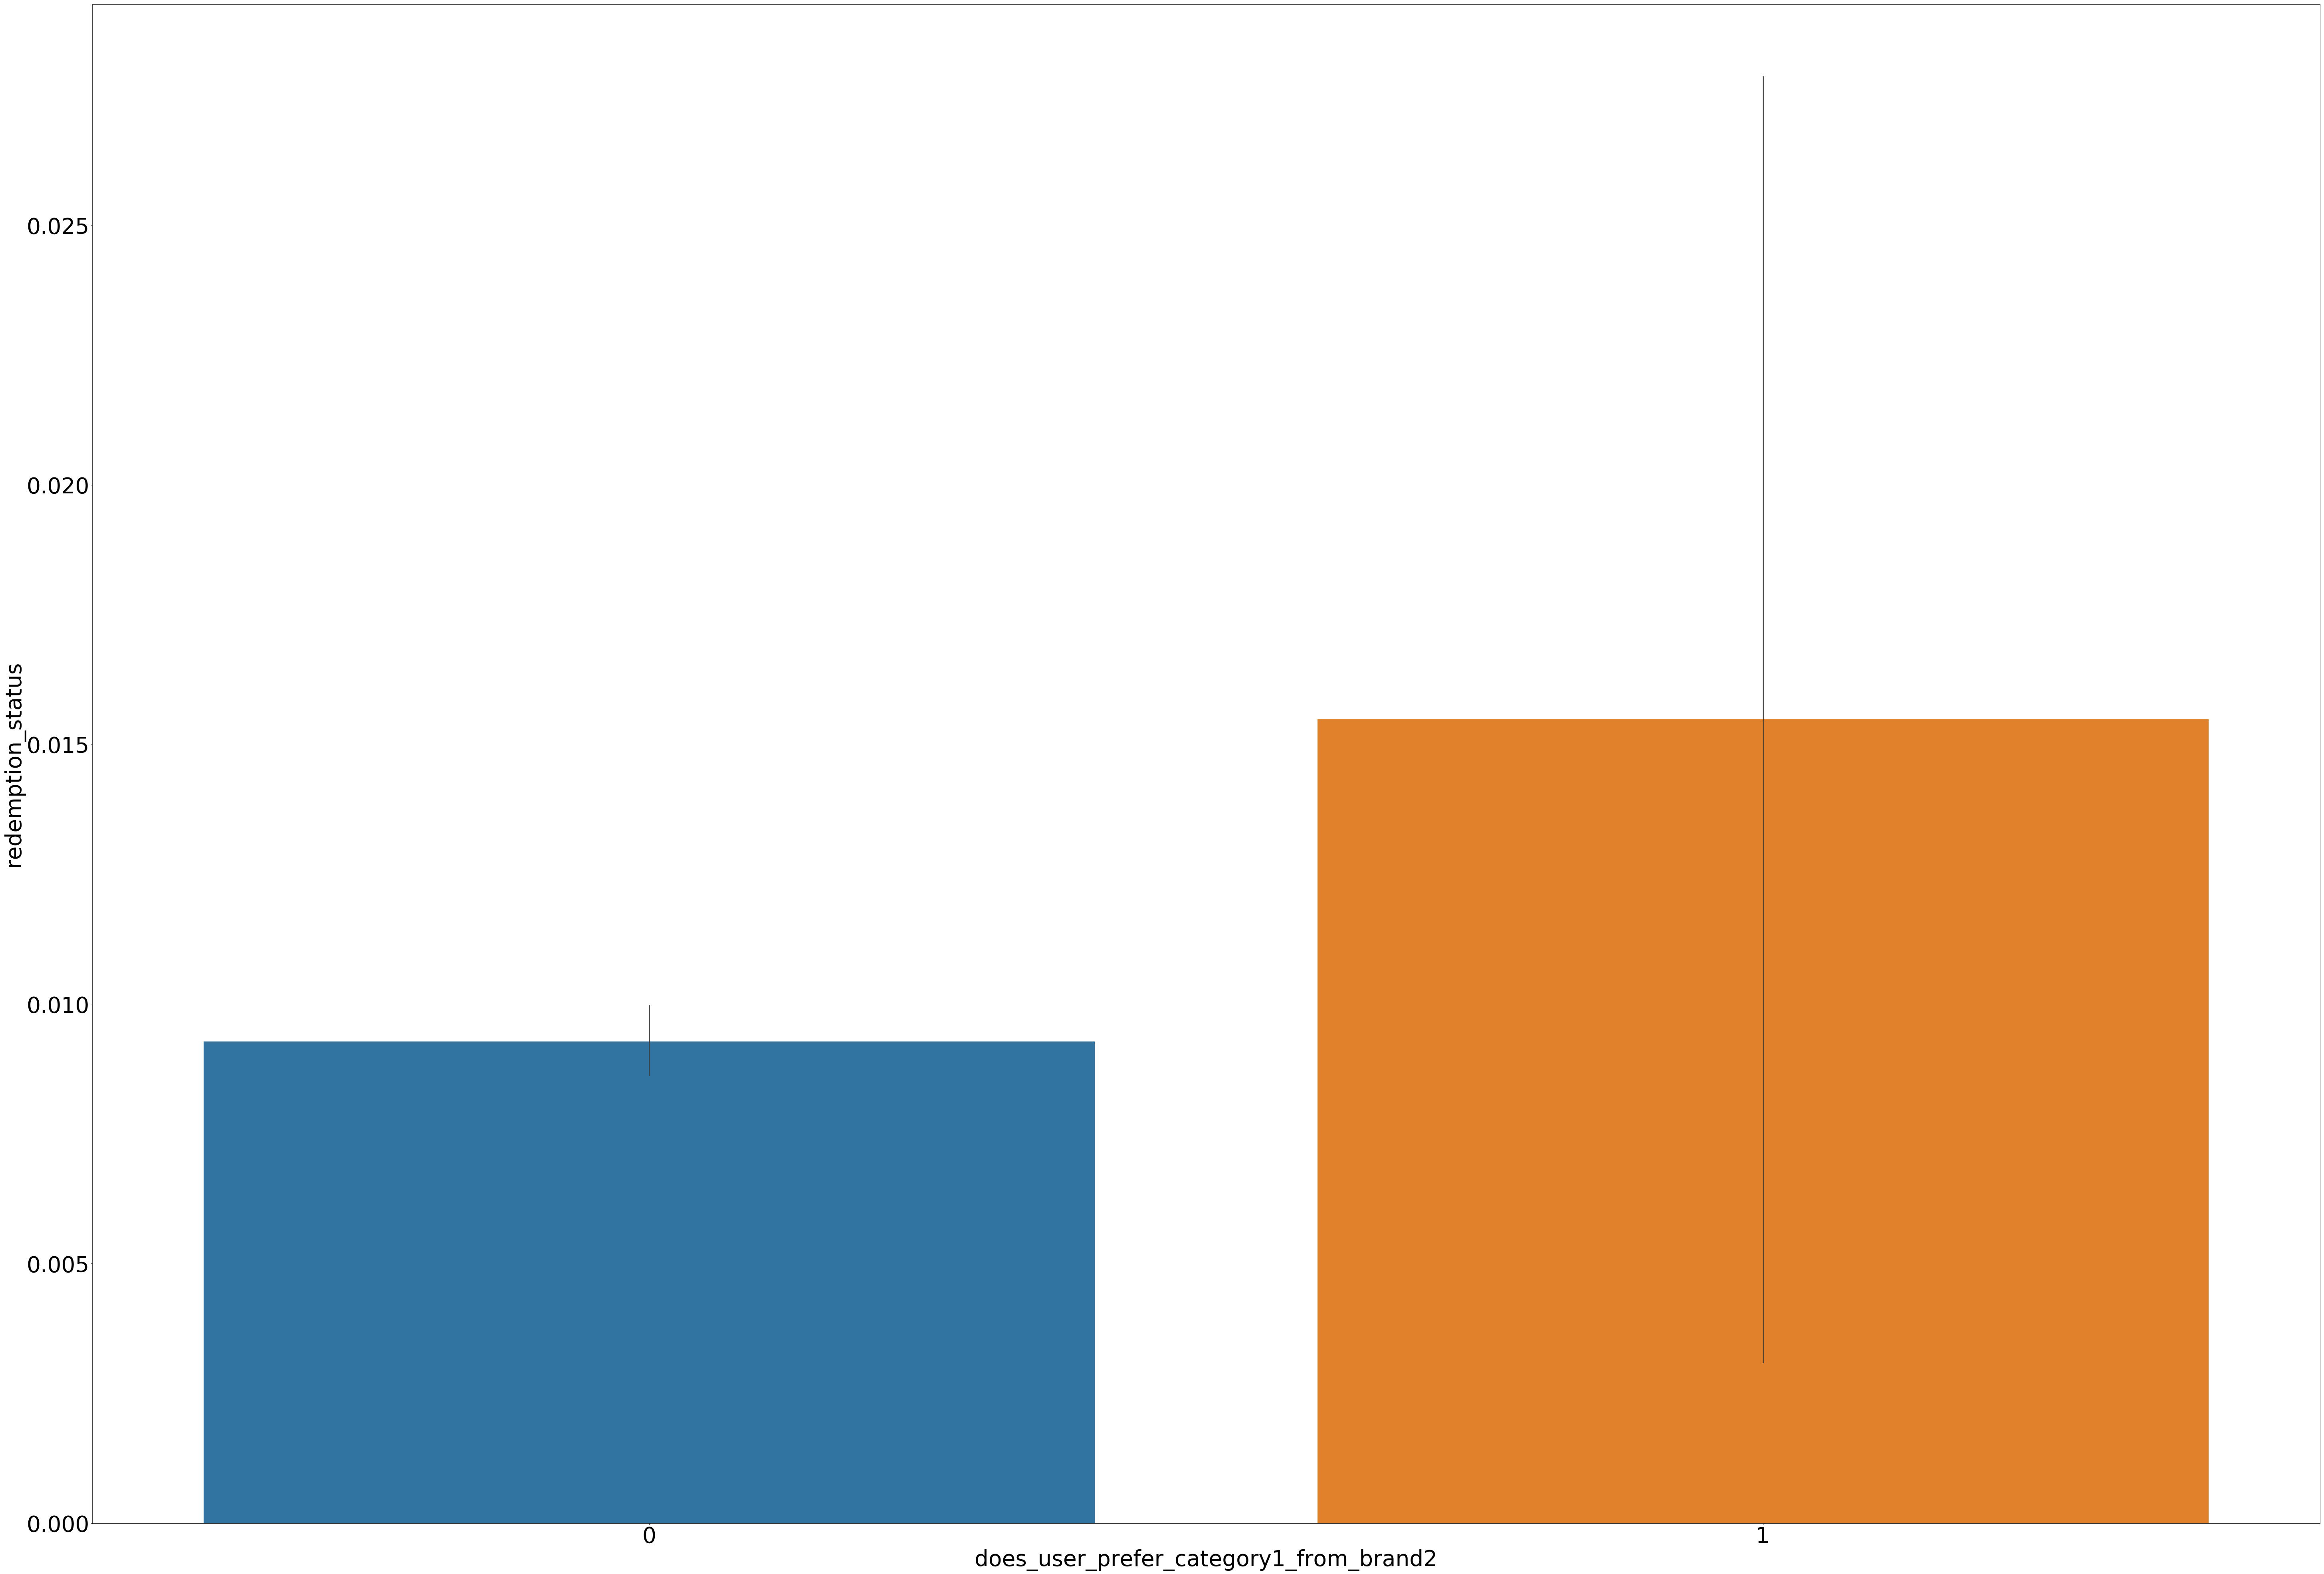

In [15]:
sns.barplot(x="does_user_prefer_category1_from_brand2", y="redemption_status",data=merged_data)


### does_user_prefer_any_of_brand1_brand2_for_category1

In [16]:
def get_preference_of_brand1_brand2_in_category1(row):
    if ((row.does_user_prefer_category1_from_brand1) or (row.does_user_prefer_category1_from_brand2)):
        return 1
    else:
        return 0
merged_data['does_user_prefer_any_of_brand1_brand2_for_category1'] = merged_data.apply(get_preference_of_brand1_brand2_in_category1, axis=1)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


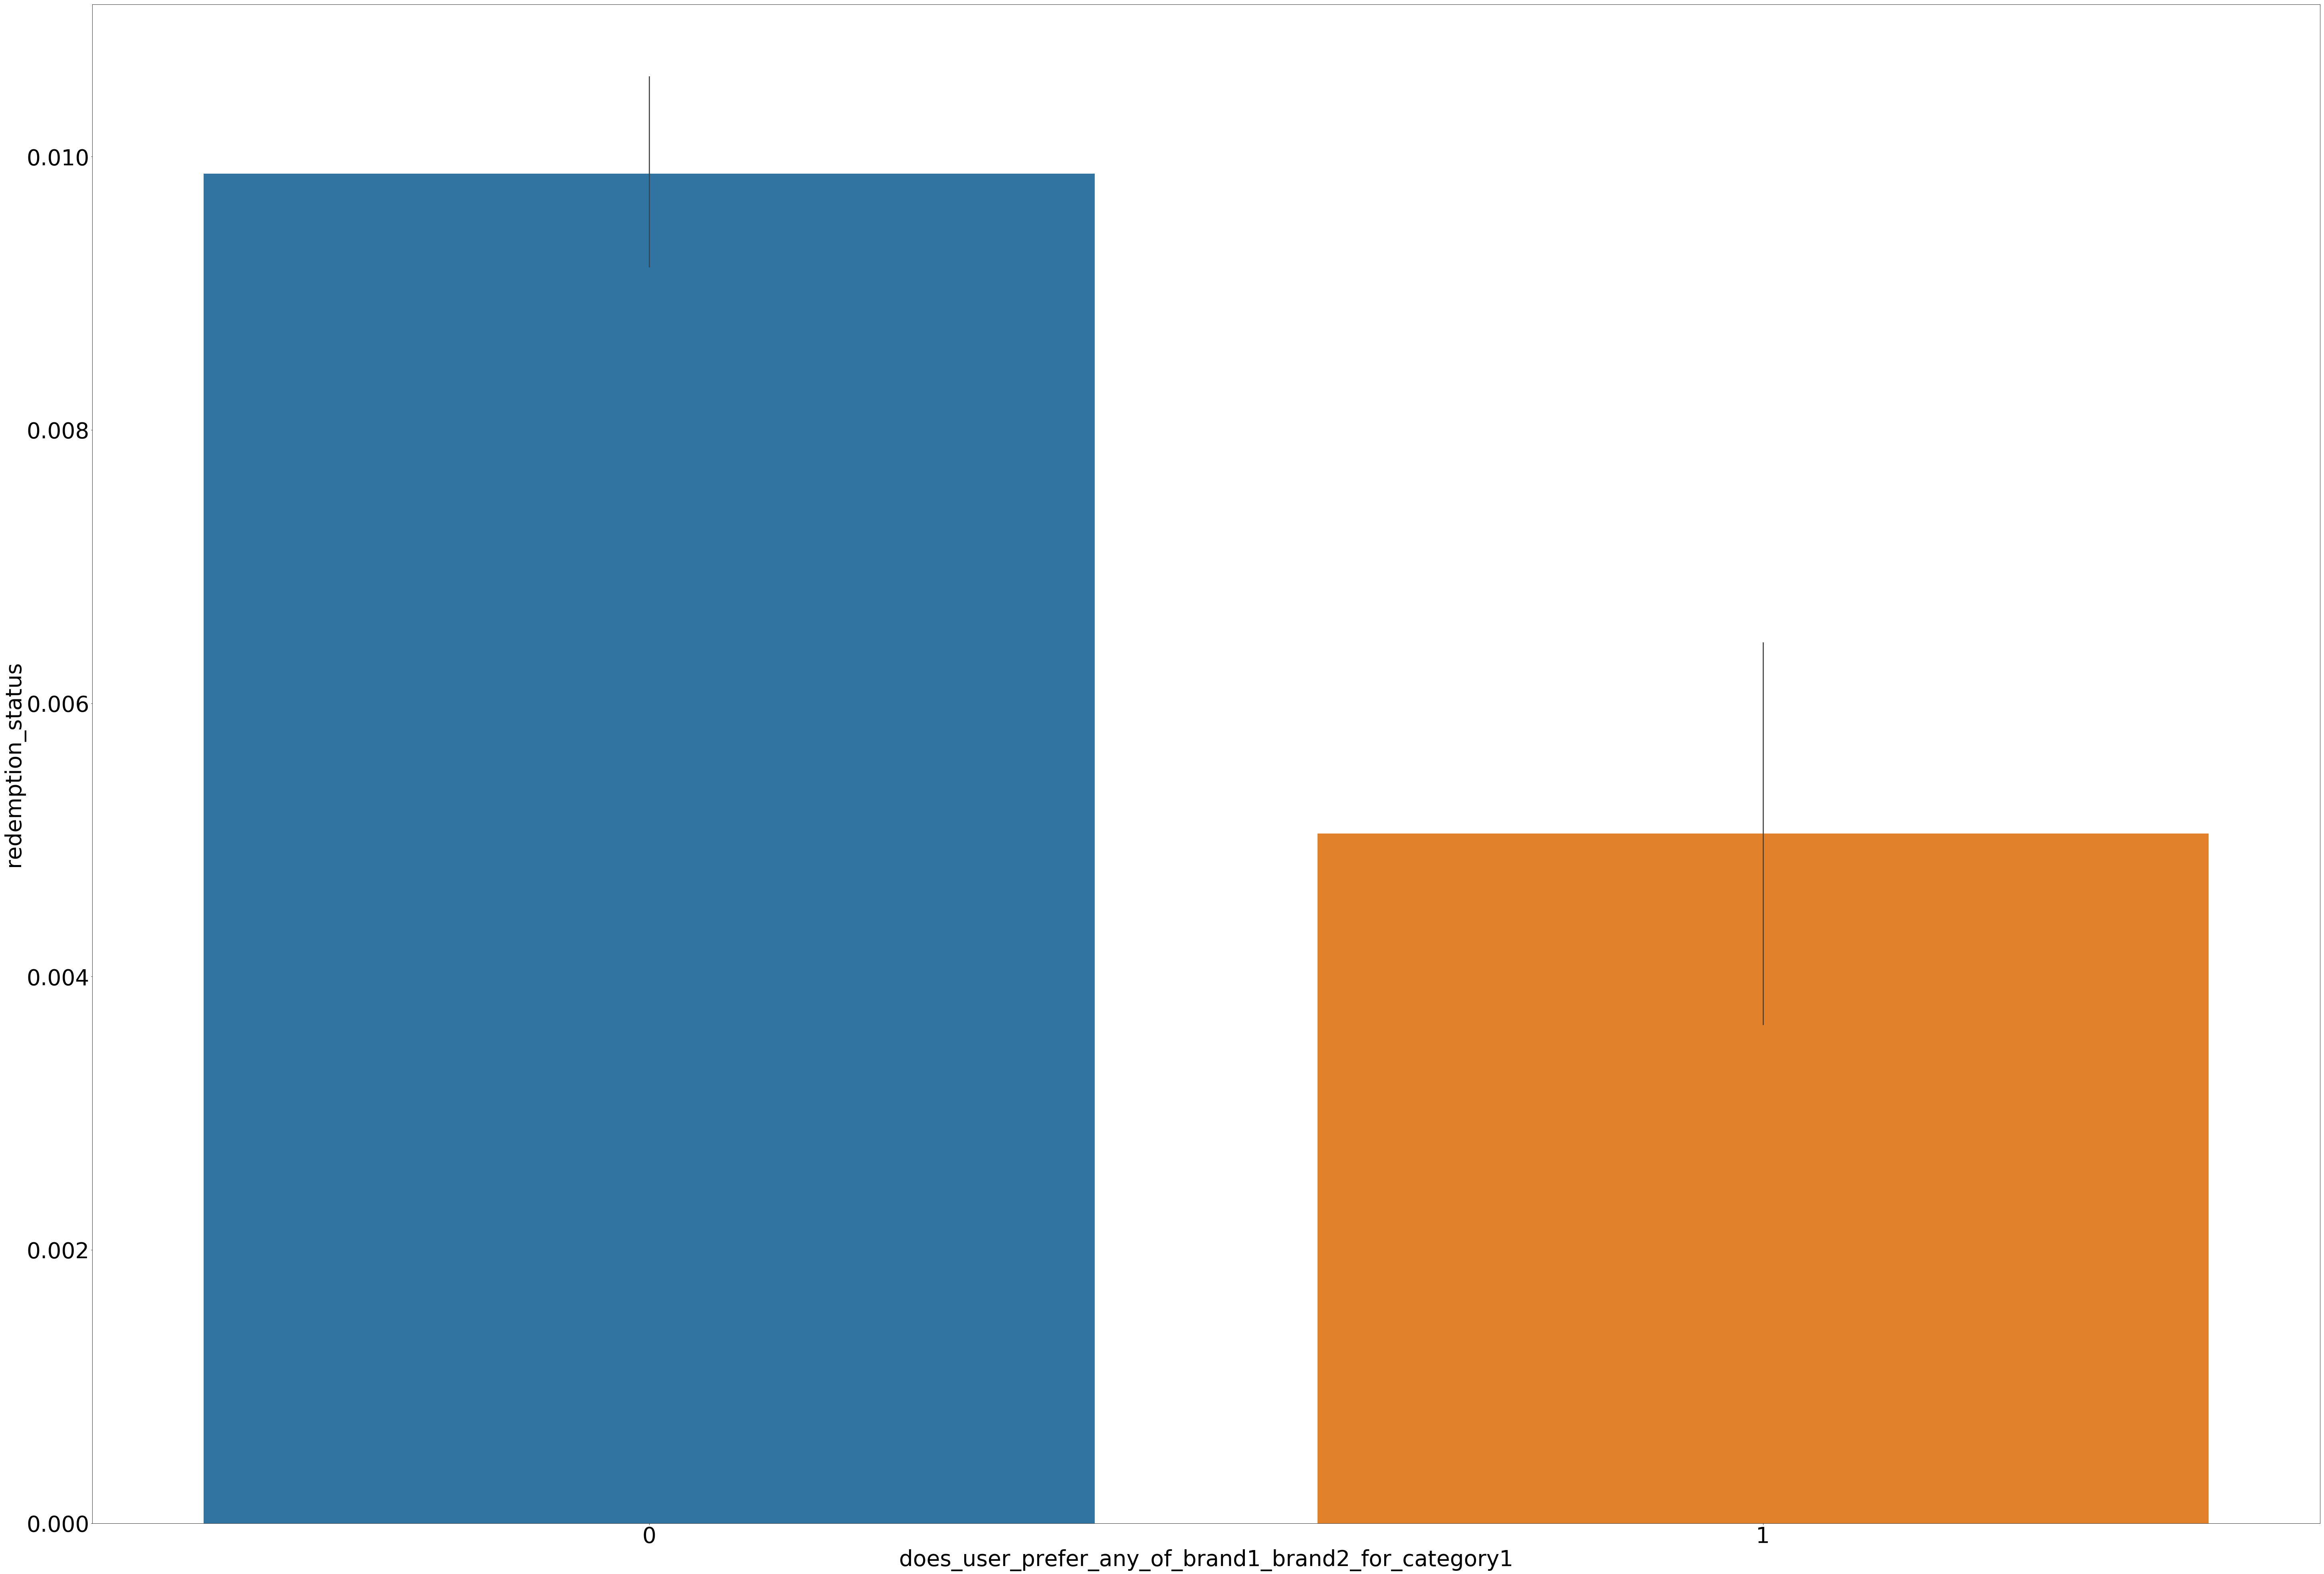

In [17]:
sns.barplot(x="does_user_prefer_any_of_brand1_brand2_for_category1", y="redemption_status",data=merged_data)

### total_spends_of_customer

In [18]:
total_spends = customer_transaction_data.groupby(by=['customer_id'])['selling_price'].agg('sum')
total_spends

customer_id
1        98513.93
2        43100.03
3        73050.27
4        33973.22
5       103615.10
          ...    
1578     82019.46
1579    146358.89
1580     59426.10
1581     57532.24
1582    117931.44
Name: selling_price, Length: 1582, dtype: float64

In [19]:
merged_data['total_spends_of_customer'] = merged_data['customer_id'].apply(lambda x: total_spends[x])

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


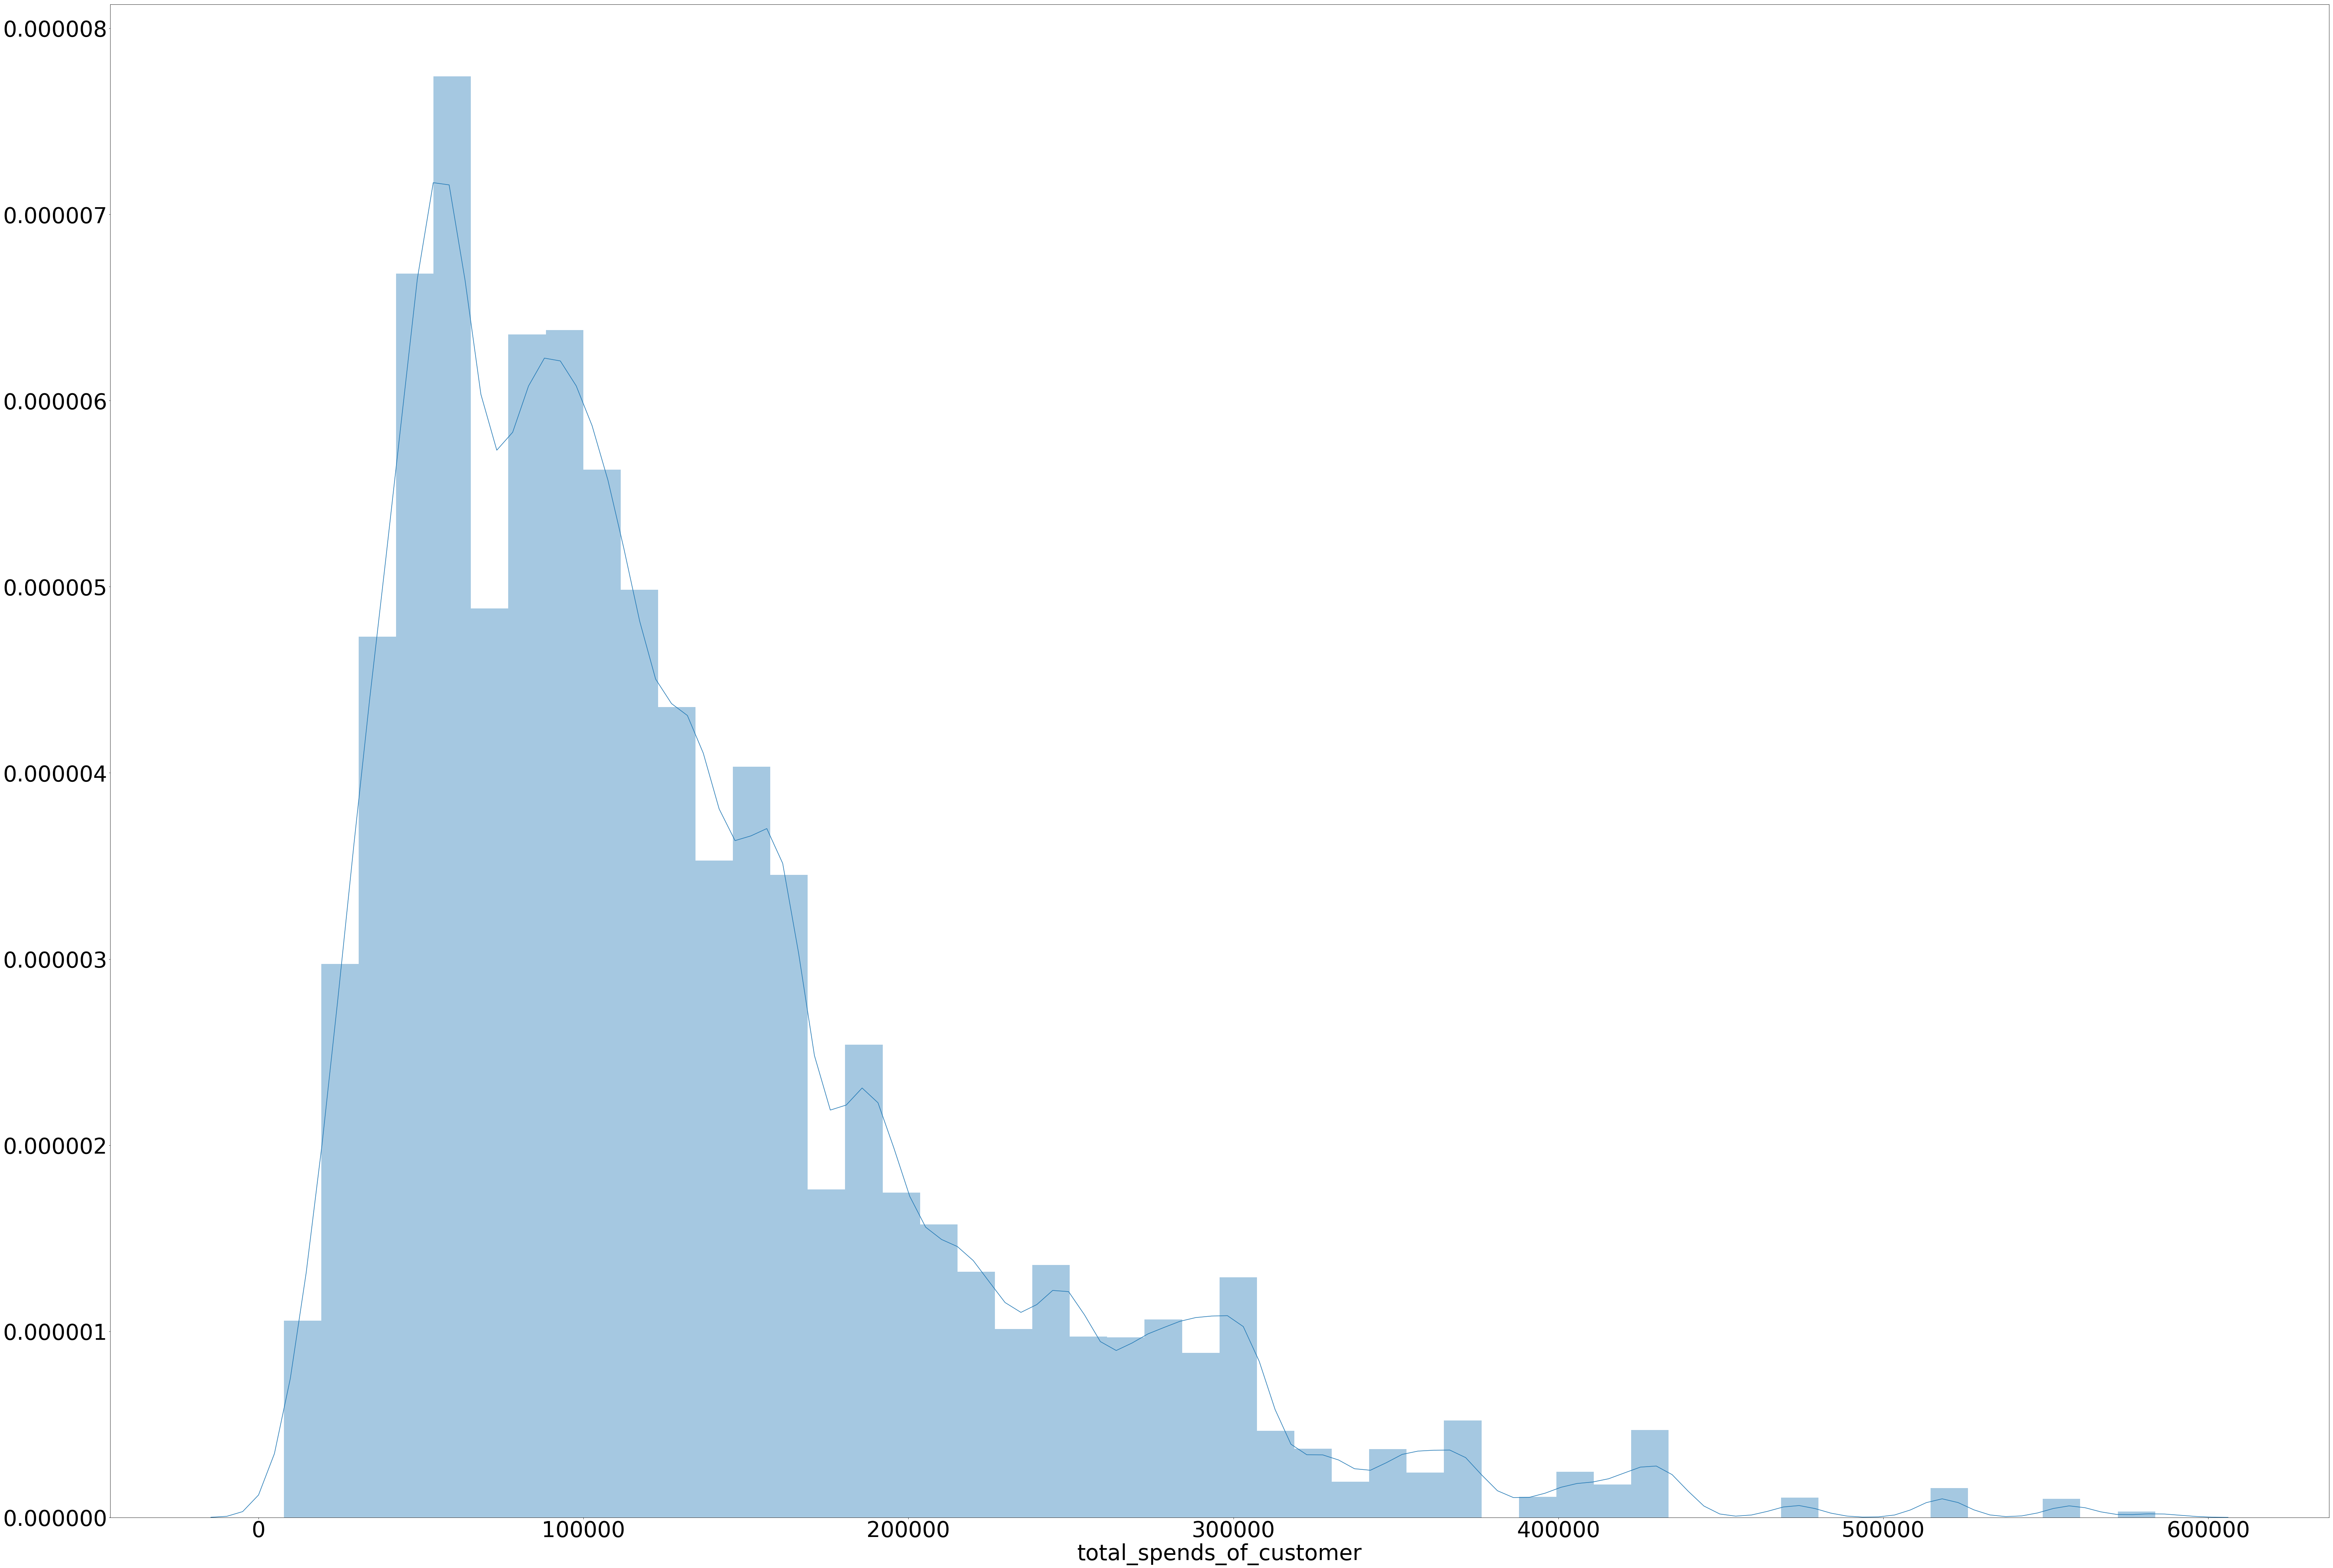

In [20]:
sns.distplot(merged_data['total_spends_of_customer'])

Checking if the above is consistent with income brackets.

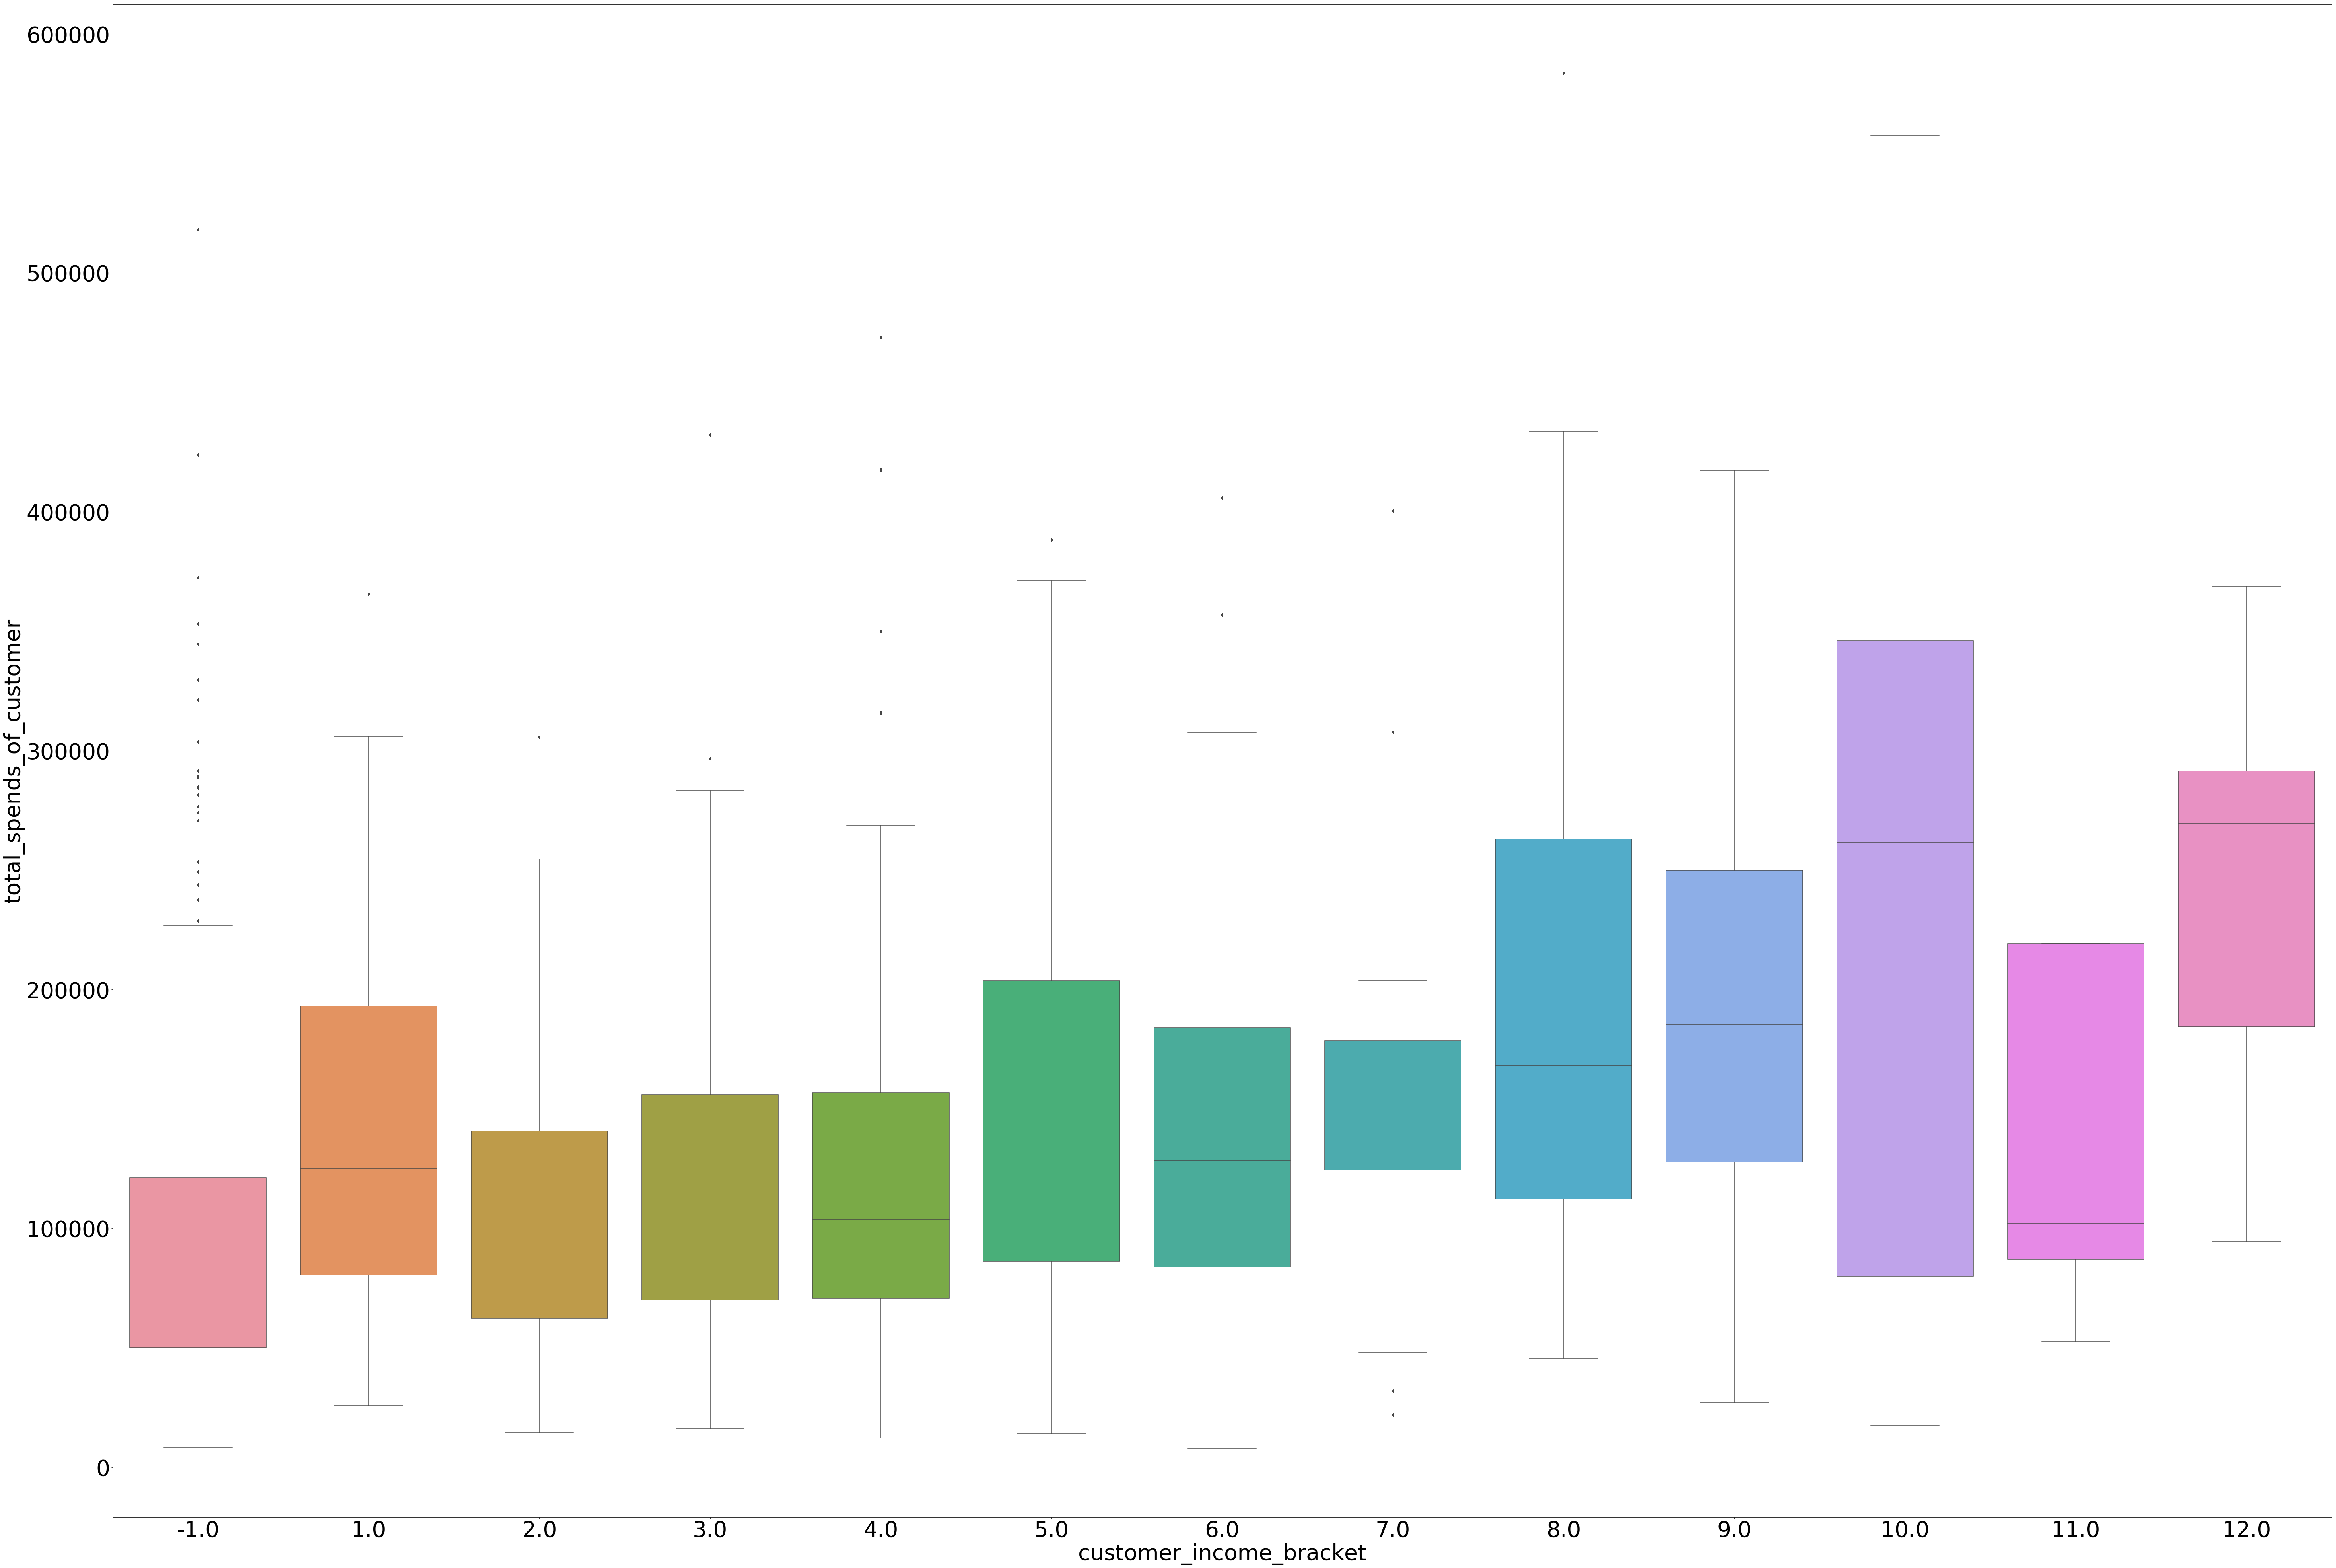

In [21]:
sns.boxplot(x="customer_income_bracket", y="total_spends_of_customer", data=merged_data)

It is highly correlated, maybe because as the income bracket increases the customer might start spending from different types of cards.

### total_spends_category_of_customer

In [22]:
merged_data['total_spends_of_customer'].quantile(0.25)

62856.3599999999

In [24]:
spend_95_percentile_value = merged_data['total_spends_of_customer'].quantile(0.95)
spend_85_percentile_value = merged_data['total_spends_of_customer'].quantile(0.85)
spend_70_percentile_value = merged_data['total_spends_of_customer'].quantile(0.70)
spend_50_percentile_value = merged_data['total_spends_of_customer'].quantile(0.50)
spend_25_percentile_value = merged_data['total_spends_of_customer'].quantile(0.25)

In [25]:
def get_spending_category(x):
    if (x<spend_25_percentile_value):
        return 1
    elif (x<spend_50_percentile_value):
        return 2
    elif (x<spend_70_percentile_value):
        return 3
    elif (x<spend_85_percentile_value):
        return 4
    else:
        return 5
merged_data['total_spends_category_of_customer'] =merged_data['total_spends_of_customer'].apply(get_spending_category)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


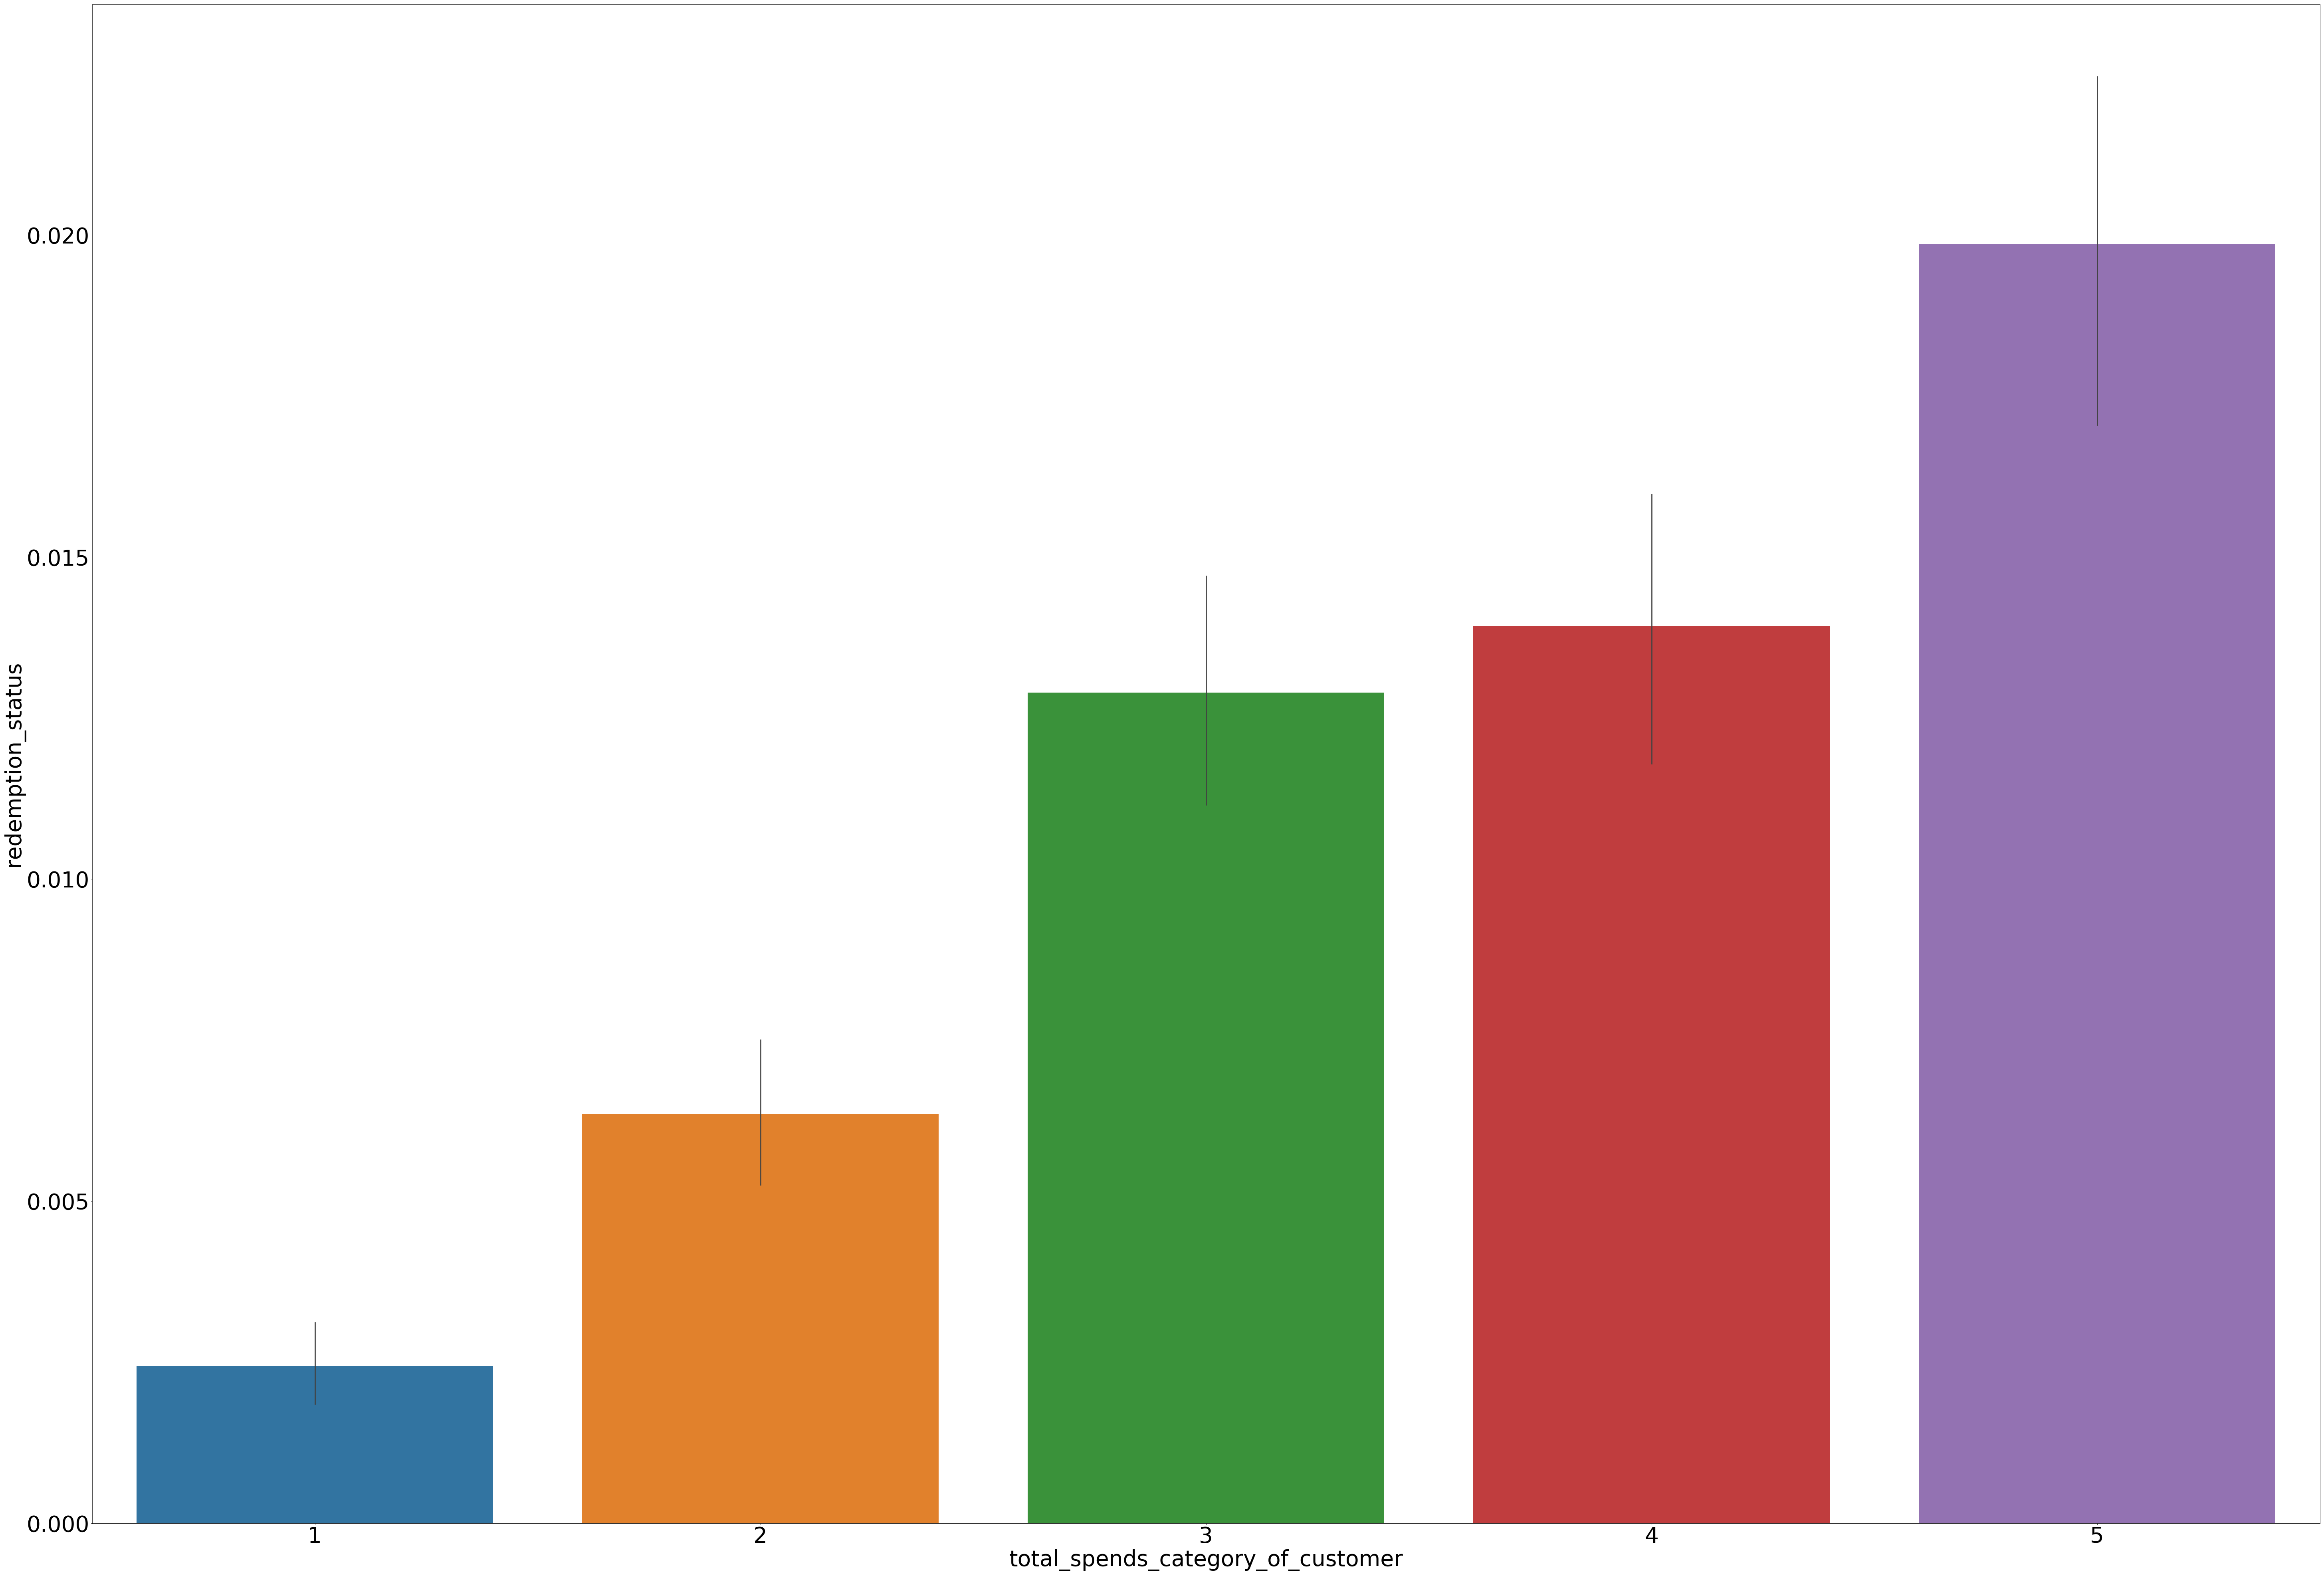

In [26]:
sns.barplot(x="total_spends_category_of_customer", y="redemption_status", data=merged_data)

### total_coupon_discount_claimed_by_customer

In [27]:
total_coupon_discount = customer_transaction_data_on_coupons.groupby(by=['customer_id'])['coupon_discount'].agg('sum')
total_coupon_discount = total_coupon_discount*-1
total_coupon_discount

customer_id
1       2116.83
2        249.34
3       2179.54
4         89.05
5         90.83
         ...   
1575      53.43
1577     124.67
1578     767.62
1579     338.39
1582    2315.96
Name: coupon_discount, Length: 1249, dtype: float64

In [28]:
def get_total_coupon_discount (x):
    try:
        return total_coupon_discount[x]
    except:
        return 0
merged_data['total_coupon_discount_claimed_by_customer'] = merged_data['customer_id'].apply(get_total_coupon_discount)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


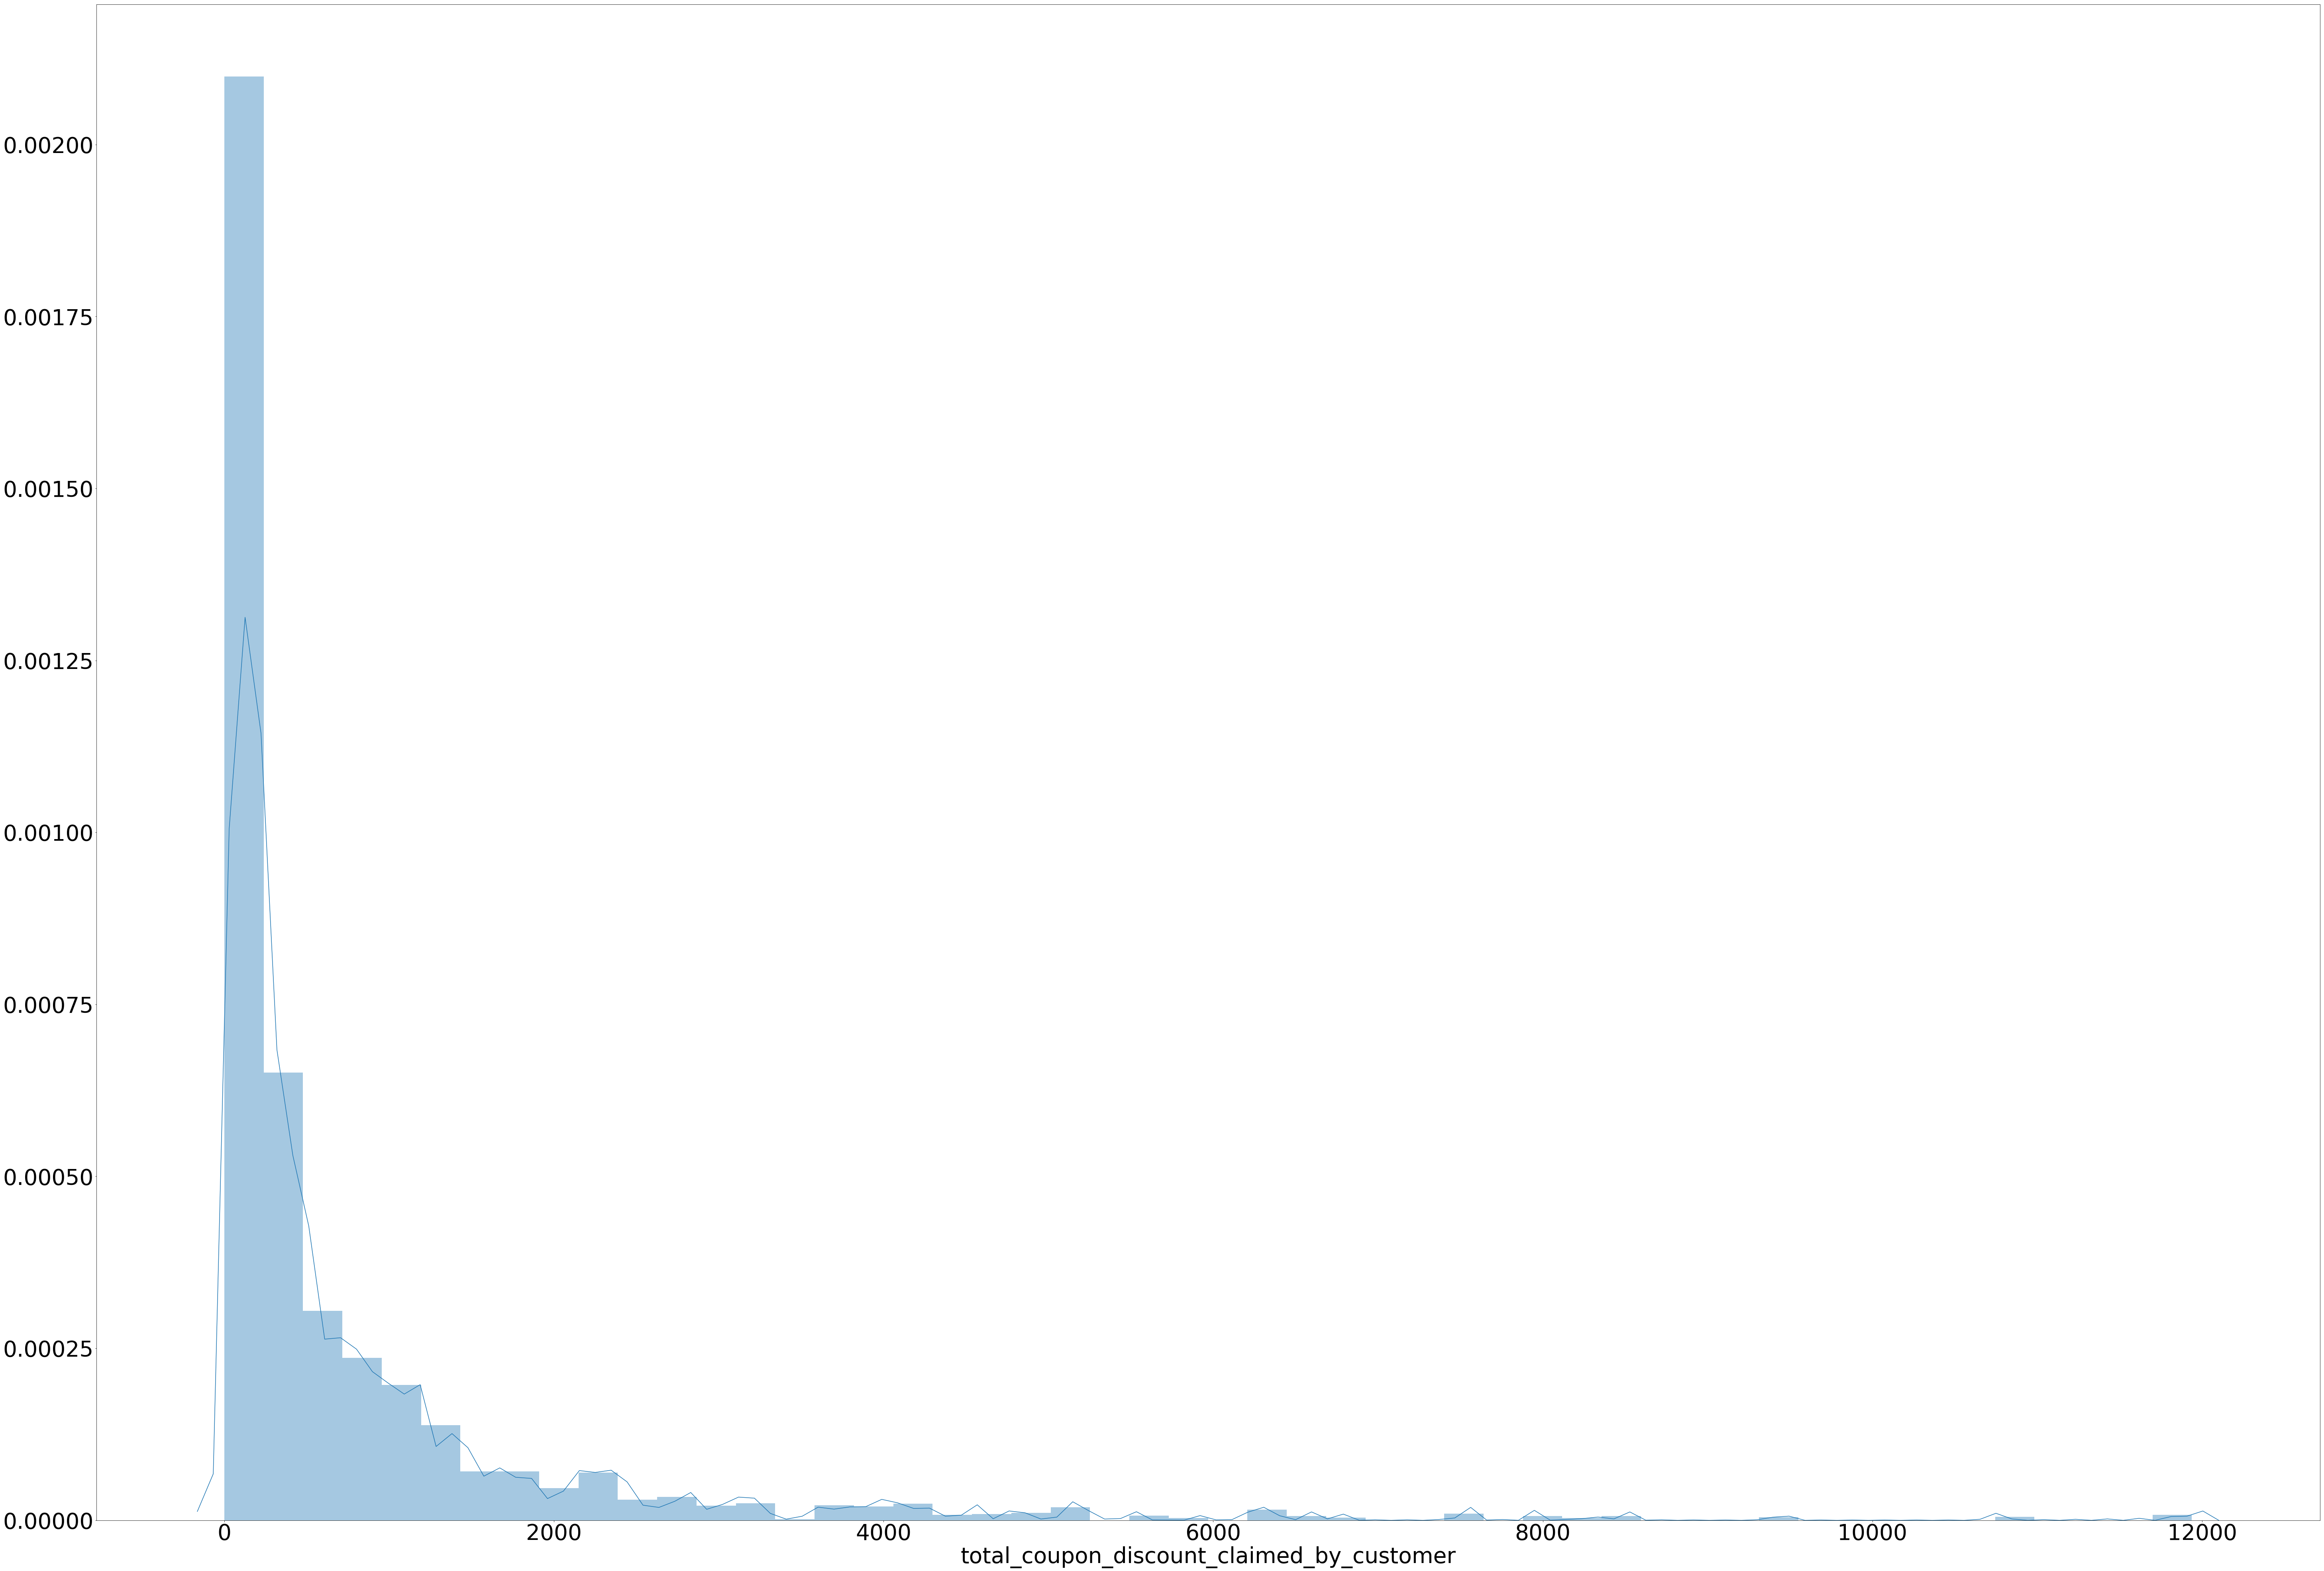

In [29]:
sns.distplot(merged_data['total_coupon_discount_claimed_by_customer'])

### coupon_claiming_category_of_customer

In [30]:
merged_data['total_coupon_discount_claimed_by_customer'].quantile(0.25)

55.209999999999994

In [31]:
discount_95_percentile_value = merged_data['total_coupon_discount_claimed_by_customer'].quantile(0.95)
discount_90_percentile_value = merged_data['total_coupon_discount_claimed_by_customer'].quantile(0.90)
discount_80_percentile_value = merged_data['total_coupon_discount_claimed_by_customer'].quantile(0.80)
discount_50_percentile_value = merged_data['total_coupon_discount_claimed_by_customer'].quantile(0.50)
discount_25_percentile_value = merged_data['total_coupon_discount_claimed_by_customer'].quantile(0.25)

In [32]:
def get_coupon_claiming_category(x):
    if (x==0):
        return 0
    elif (x<discount_25_percentile_value):
        return 1
    elif (x<discount_50_percentile_value):
        return 2
    elif (x<discount_80_percentile_value):
        return 3
    elif (x<discount_90_percentile_value):
        return 4
    else:
        return 5
merged_data['coupon_claiming_category_of_customer'] =merged_data['total_coupon_discount_claimed_by_customer'].apply(get_coupon_claiming_category)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


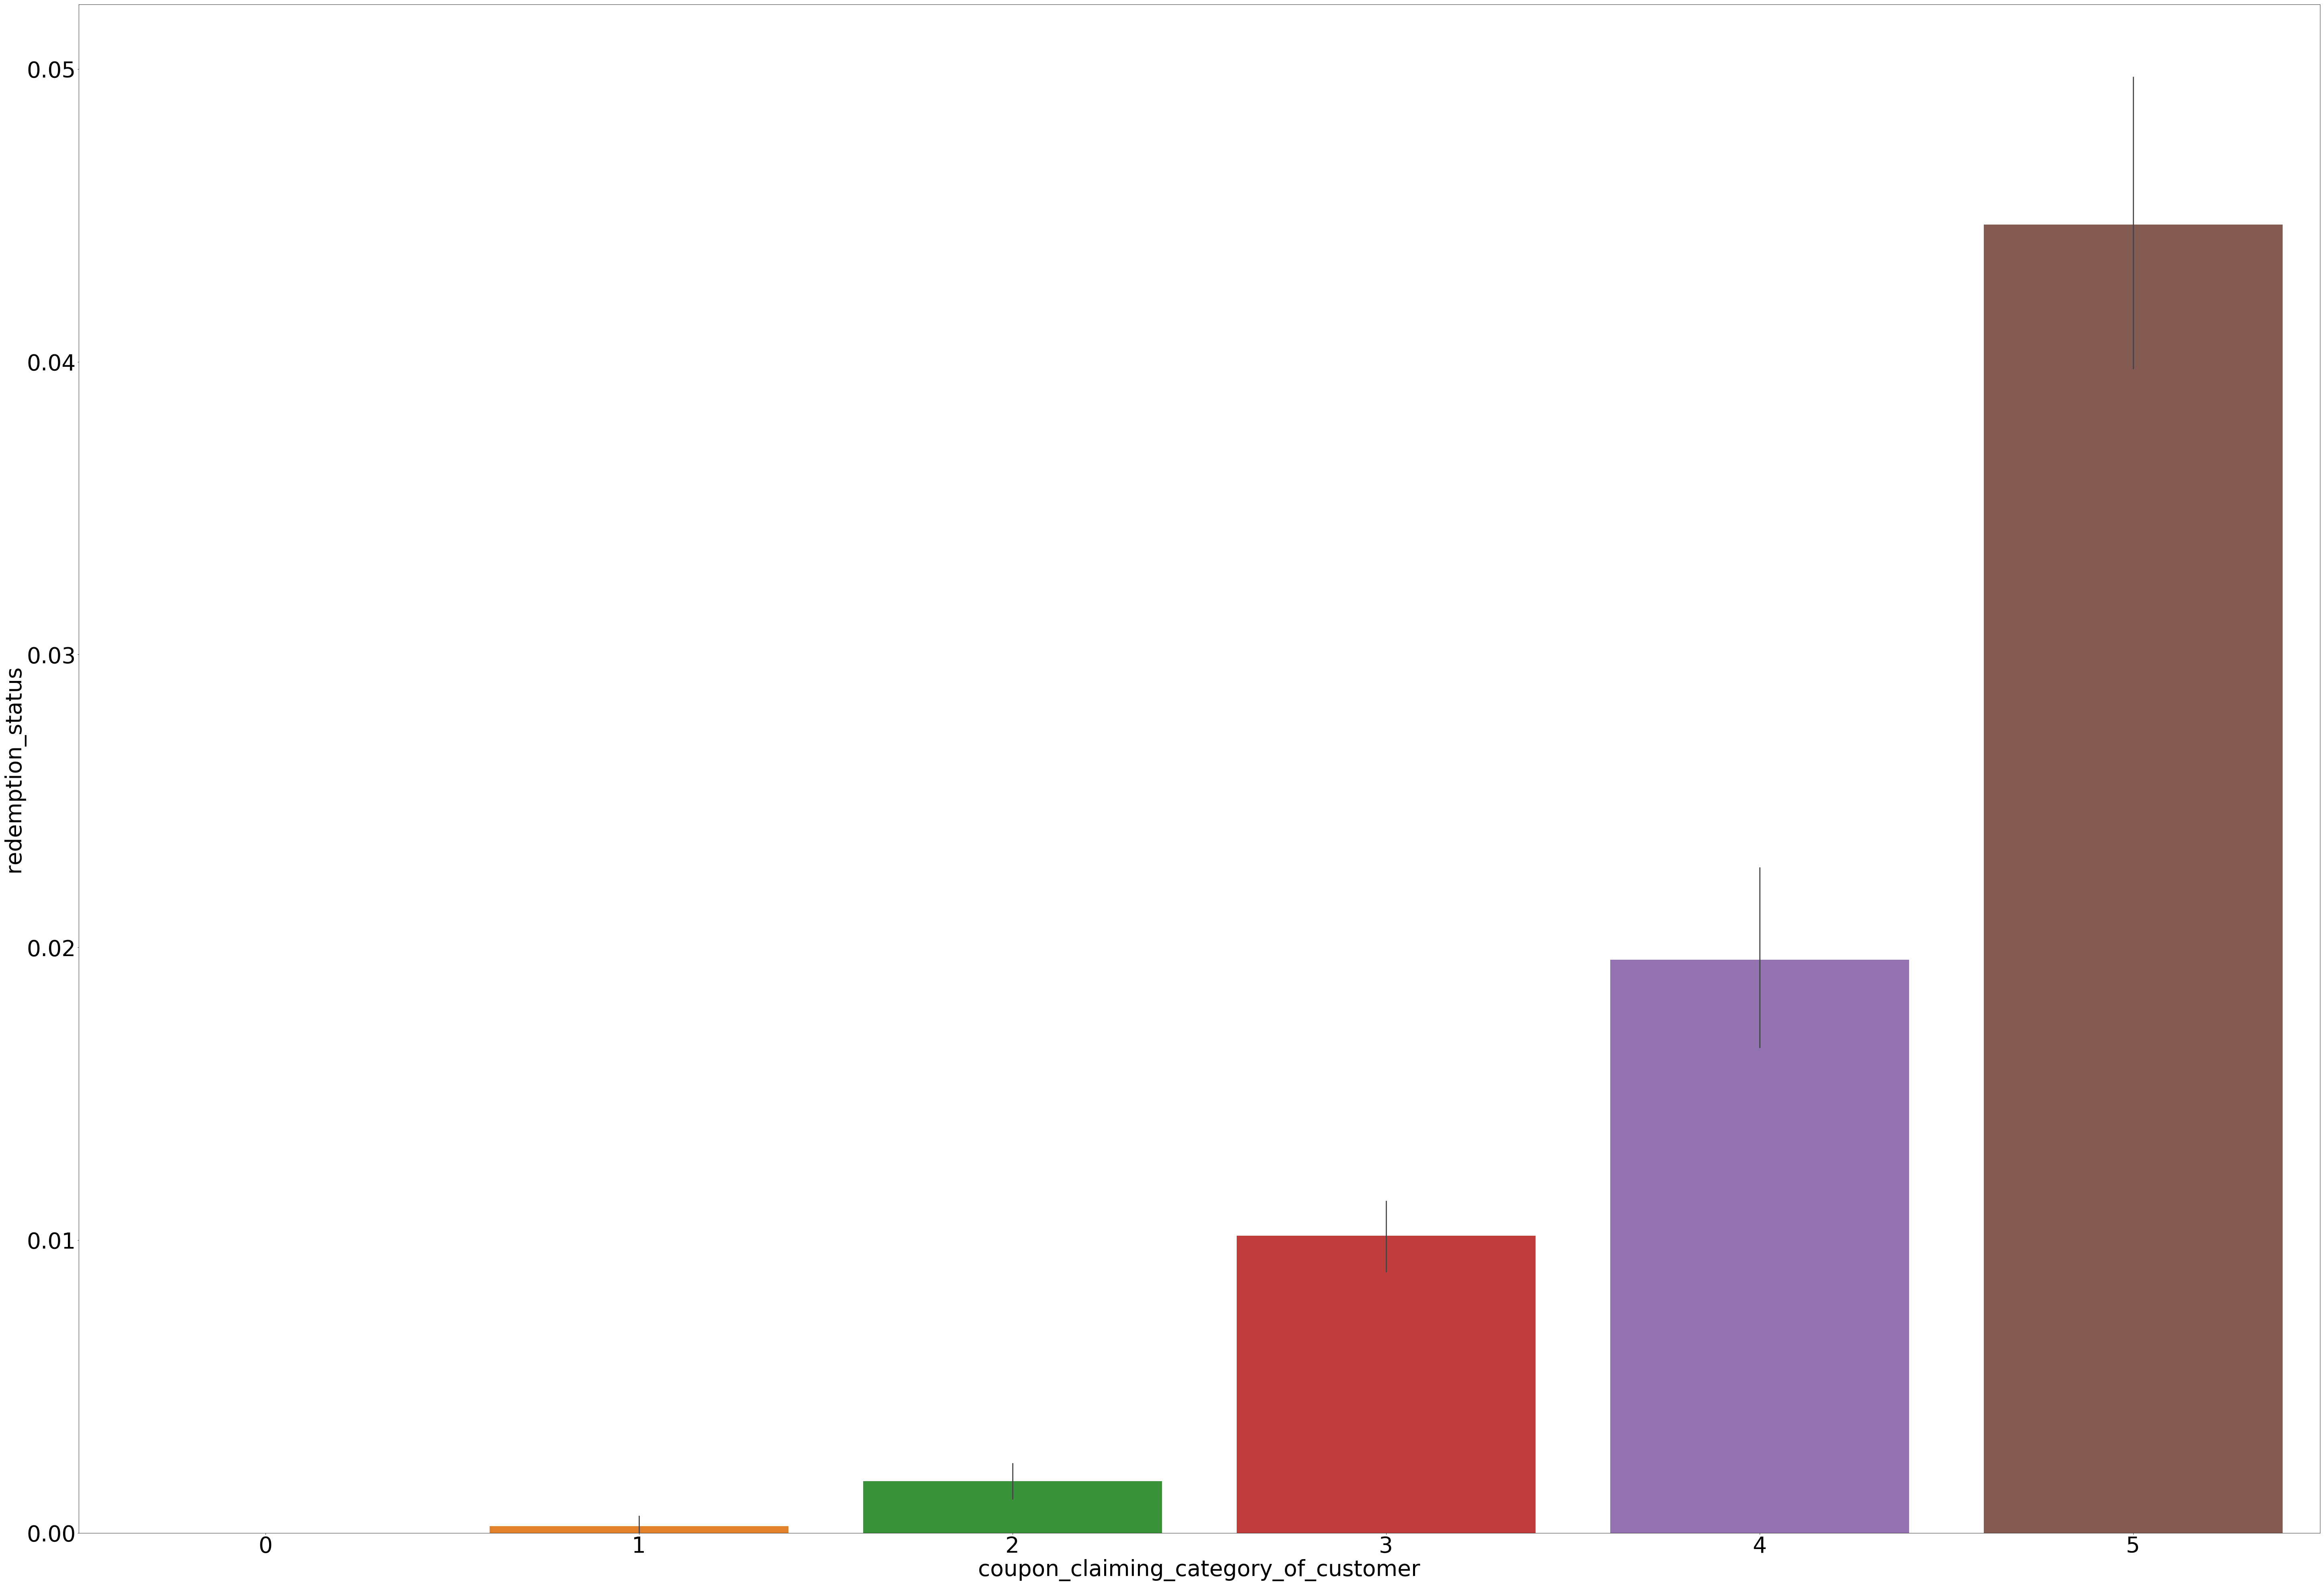

In [33]:
sns.barplot(x="coupon_claiming_category_of_customer", y="redemption_status", data=merged_data)

All customers who have no coupon transaction amount will never redeem a coupon

Finding the percentage of these customers in train and test

In [34]:
(merged_data[(merged_data.is_test == 1) & (merged_data.customer_id.isin(customer_transaction_data_on_coupons.customer_id.to_list()))].shape[0]/merged_data[merged_data.is_test == 1].shape[0])*100

87.63588579620118

For the rest 12.5% straightaway predict a zero.

In [35]:
(merged_data[(merged_data.is_test == 0) & (merged_data.customer_id.isin(customer_transaction_data_on_coupons.customer_id.to_list()))].shape[0]/merged_data[merged_data.is_test == 0].shape[0])*100

84.10596026490066

Neglect these values in train dataset

### most_bought_category_of_user

In [36]:
grouped_df = customer_transaction_data.groupby(by=['customer_id'])
grouped_df


In [ ]:
customer_transaction_data.groupby(['customer_id','category']).apply(lambda x: print(x))

In [41]:
customer_ids=[]
most_popular_category = []
for name, group in grouped_df:
    customer_ids.append(name)
    most_popular_category.append(group.describe(include='all')['category']['top'])
    print ("Handled customer id: ", name)

Handled customer id:  1
Handled customer id:  2
Handled customer id:  3
Handled customer id:  4
Handled customer id:  5
Handled customer id:  6
Handled customer id:  7
Handled customer id:  8
Handled customer id:  9
Handled customer id:  10
Handled customer id:  11
Handled customer id:  12
Handled customer id:  13
Handled customer id:  14
Handled customer id:  15
Handled customer id:  16
Handled customer id:  17
Handled customer id:  18
Handled customer id:  19
Handled customer id:  20
Handled customer id:  21
Handled customer id:  22
Handled customer id:  23
Handled customer id:  24
Handled customer id:  25
Handled customer id:  26
Handled customer id:  27
Handled customer id:  28
Handled customer id:  29
Handled customer id:  30
Handled customer id:  31
Handled customer id:  32
Handled customer id:  33
Handled customer id:  34
Handled customer id:  35
Handled customer id:  36
Handled customer id:  37
Handled customer id:  38
Handled customer id:  39
Handled customer id:  40
Handled c

Handled customer id:  322
Handled customer id:  323
Handled customer id:  324
Handled customer id:  325
Handled customer id:  326
Handled customer id:  327
Handled customer id:  328
Handled customer id:  329
Handled customer id:  330
Handled customer id:  331
Handled customer id:  332
Handled customer id:  333
Handled customer id:  334
Handled customer id:  335
Handled customer id:  336
Handled customer id:  337
Handled customer id:  338
Handled customer id:  339
Handled customer id:  340
Handled customer id:  341
Handled customer id:  342
Handled customer id:  343
Handled customer id:  344
Handled customer id:  345
Handled customer id:  346
Handled customer id:  347
Handled customer id:  348
Handled customer id:  349
Handled customer id:  350
Handled customer id:  351
Handled customer id:  352
Handled customer id:  353
Handled customer id:  354
Handled customer id:  355
Handled customer id:  356
Handled customer id:  357
Handled customer id:  358
Handled customer id:  359
Handled cust

Handled customer id:  644
Handled customer id:  645
Handled customer id:  646
Handled customer id:  647
Handled customer id:  648
Handled customer id:  649
Handled customer id:  650
Handled customer id:  651
Handled customer id:  652
Handled customer id:  653
Handled customer id:  654
Handled customer id:  655
Handled customer id:  656
Handled customer id:  657
Handled customer id:  658
Handled customer id:  659
Handled customer id:  660
Handled customer id:  661
Handled customer id:  662
Handled customer id:  663
Handled customer id:  664
Handled customer id:  665
Handled customer id:  666
Handled customer id:  667
Handled customer id:  668
Handled customer id:  669
Handled customer id:  670
Handled customer id:  671
Handled customer id:  672
Handled customer id:  673
Handled customer id:  674
Handled customer id:  675
Handled customer id:  676
Handled customer id:  677
Handled customer id:  678
Handled customer id:  679
Handled customer id:  680
Handled customer id:  681
Handled cust

Handled customer id:  961
Handled customer id:  962
Handled customer id:  963
Handled customer id:  964
Handled customer id:  965
Handled customer id:  966
Handled customer id:  967
Handled customer id:  968
Handled customer id:  969
Handled customer id:  970
Handled customer id:  971
Handled customer id:  972
Handled customer id:  973
Handled customer id:  974
Handled customer id:  975
Handled customer id:  976
Handled customer id:  977
Handled customer id:  978
Handled customer id:  979
Handled customer id:  980
Handled customer id:  981
Handled customer id:  982
Handled customer id:  983
Handled customer id:  984
Handled customer id:  985
Handled customer id:  986
Handled customer id:  987
Handled customer id:  988
Handled customer id:  989
Handled customer id:  990
Handled customer id:  991
Handled customer id:  992
Handled customer id:  993
Handled customer id:  994
Handled customer id:  995
Handled customer id:  996
Handled customer id:  997
Handled customer id:  998
Handled cust

Handled customer id:  1271
Handled customer id:  1272
Handled customer id:  1273
Handled customer id:  1274
Handled customer id:  1275
Handled customer id:  1276
Handled customer id:  1277
Handled customer id:  1278
Handled customer id:  1279
Handled customer id:  1280
Handled customer id:  1281
Handled customer id:  1282
Handled customer id:  1283
Handled customer id:  1284
Handled customer id:  1285
Handled customer id:  1286
Handled customer id:  1287
Handled customer id:  1288
Handled customer id:  1289
Handled customer id:  1290
Handled customer id:  1291
Handled customer id:  1292
Handled customer id:  1293
Handled customer id:  1294
Handled customer id:  1295
Handled customer id:  1296
Handled customer id:  1297
Handled customer id:  1298
Handled customer id:  1299
Handled customer id:  1300
Handled customer id:  1301
Handled customer id:  1302
Handled customer id:  1303
Handled customer id:  1304
Handled customer id:  1305
Handled customer id:  1306
Handled customer id:  1307
H

Handled customer id:  1576
Handled customer id:  1577
Handled customer id:  1578
Handled customer id:  1579
Handled customer id:  1580
Handled customer id:  1581
Handled customer id:  1582


In [47]:
favourite_categories = pd.Series(most_popular_category,index=customer_ids)

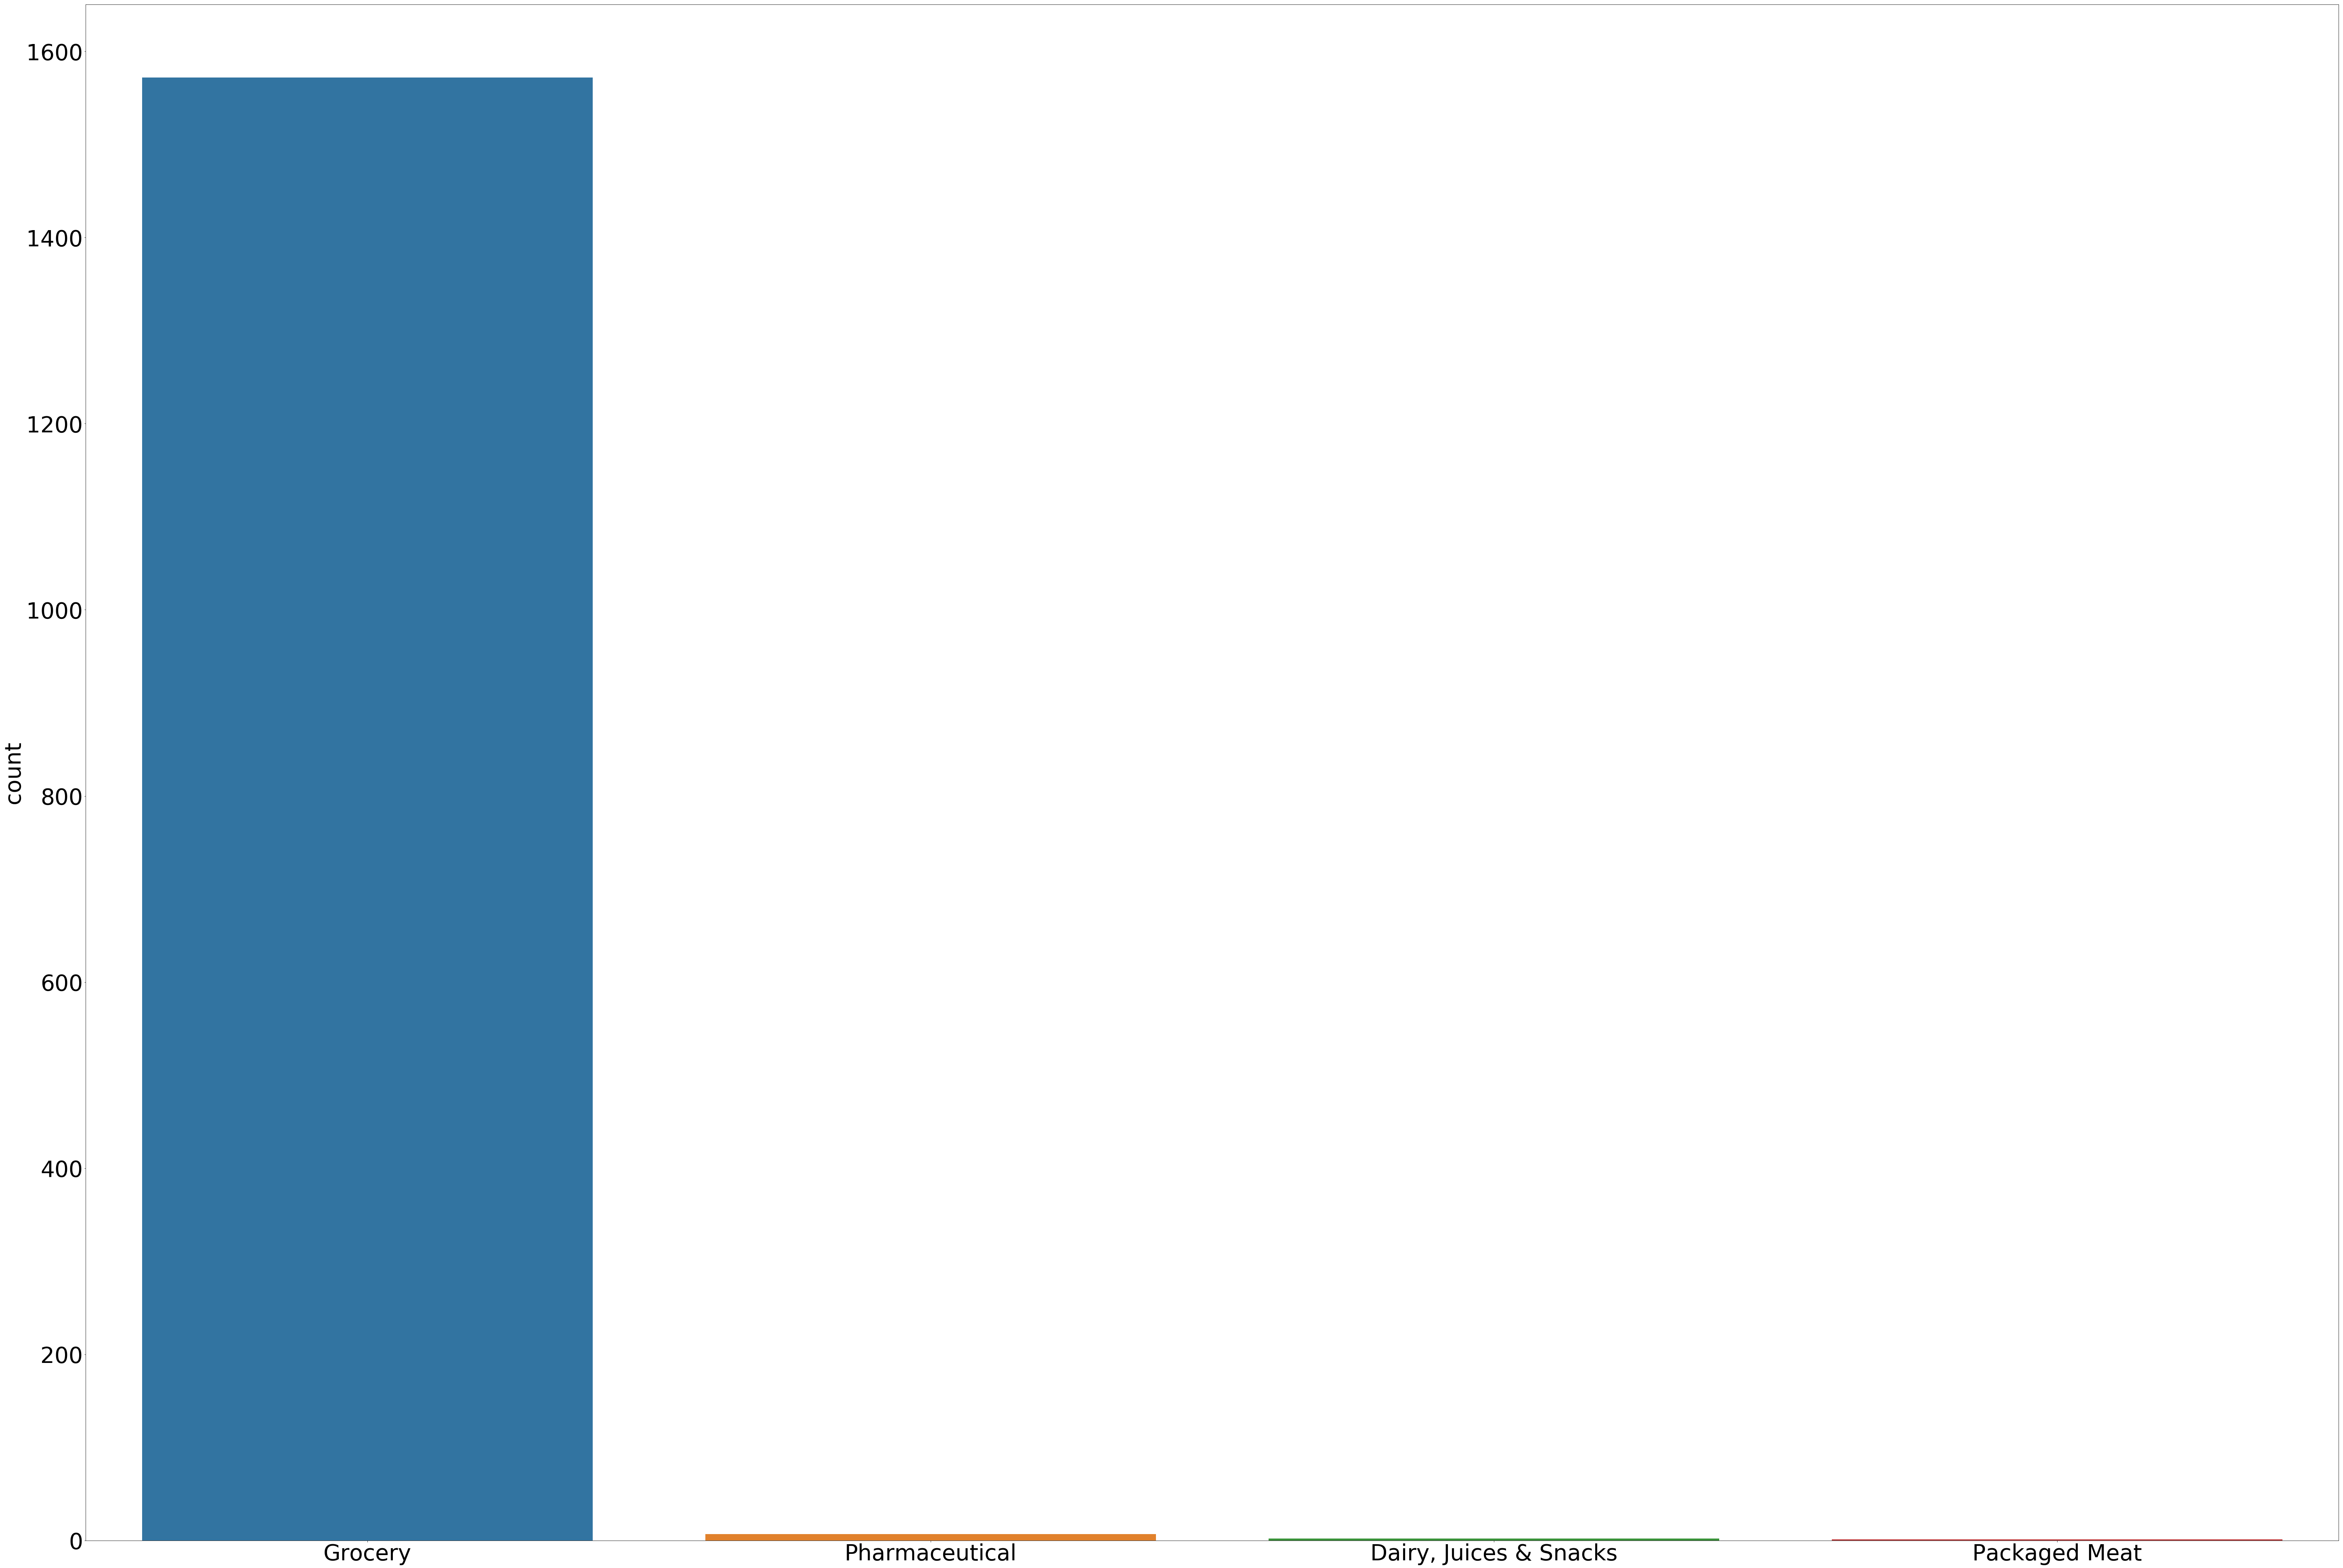

In [48]:
sns.countplot(favourite_categories)

In [50]:
merged_data['most_bought_category_of_user'] = merged_data['customer_id'].apply(lambda x: favourite_categories[x])

### is_coupon_category1_same_as_customer_most_bought_category

In [85]:
merged_data['is_coupon_category1_same_as_customer_most_bought_category'] = merged_data.apply(lambda row: 1 if (row.coupon_available_on_category_1 == row.most_bought_category_of_user) else 0, axis=1)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


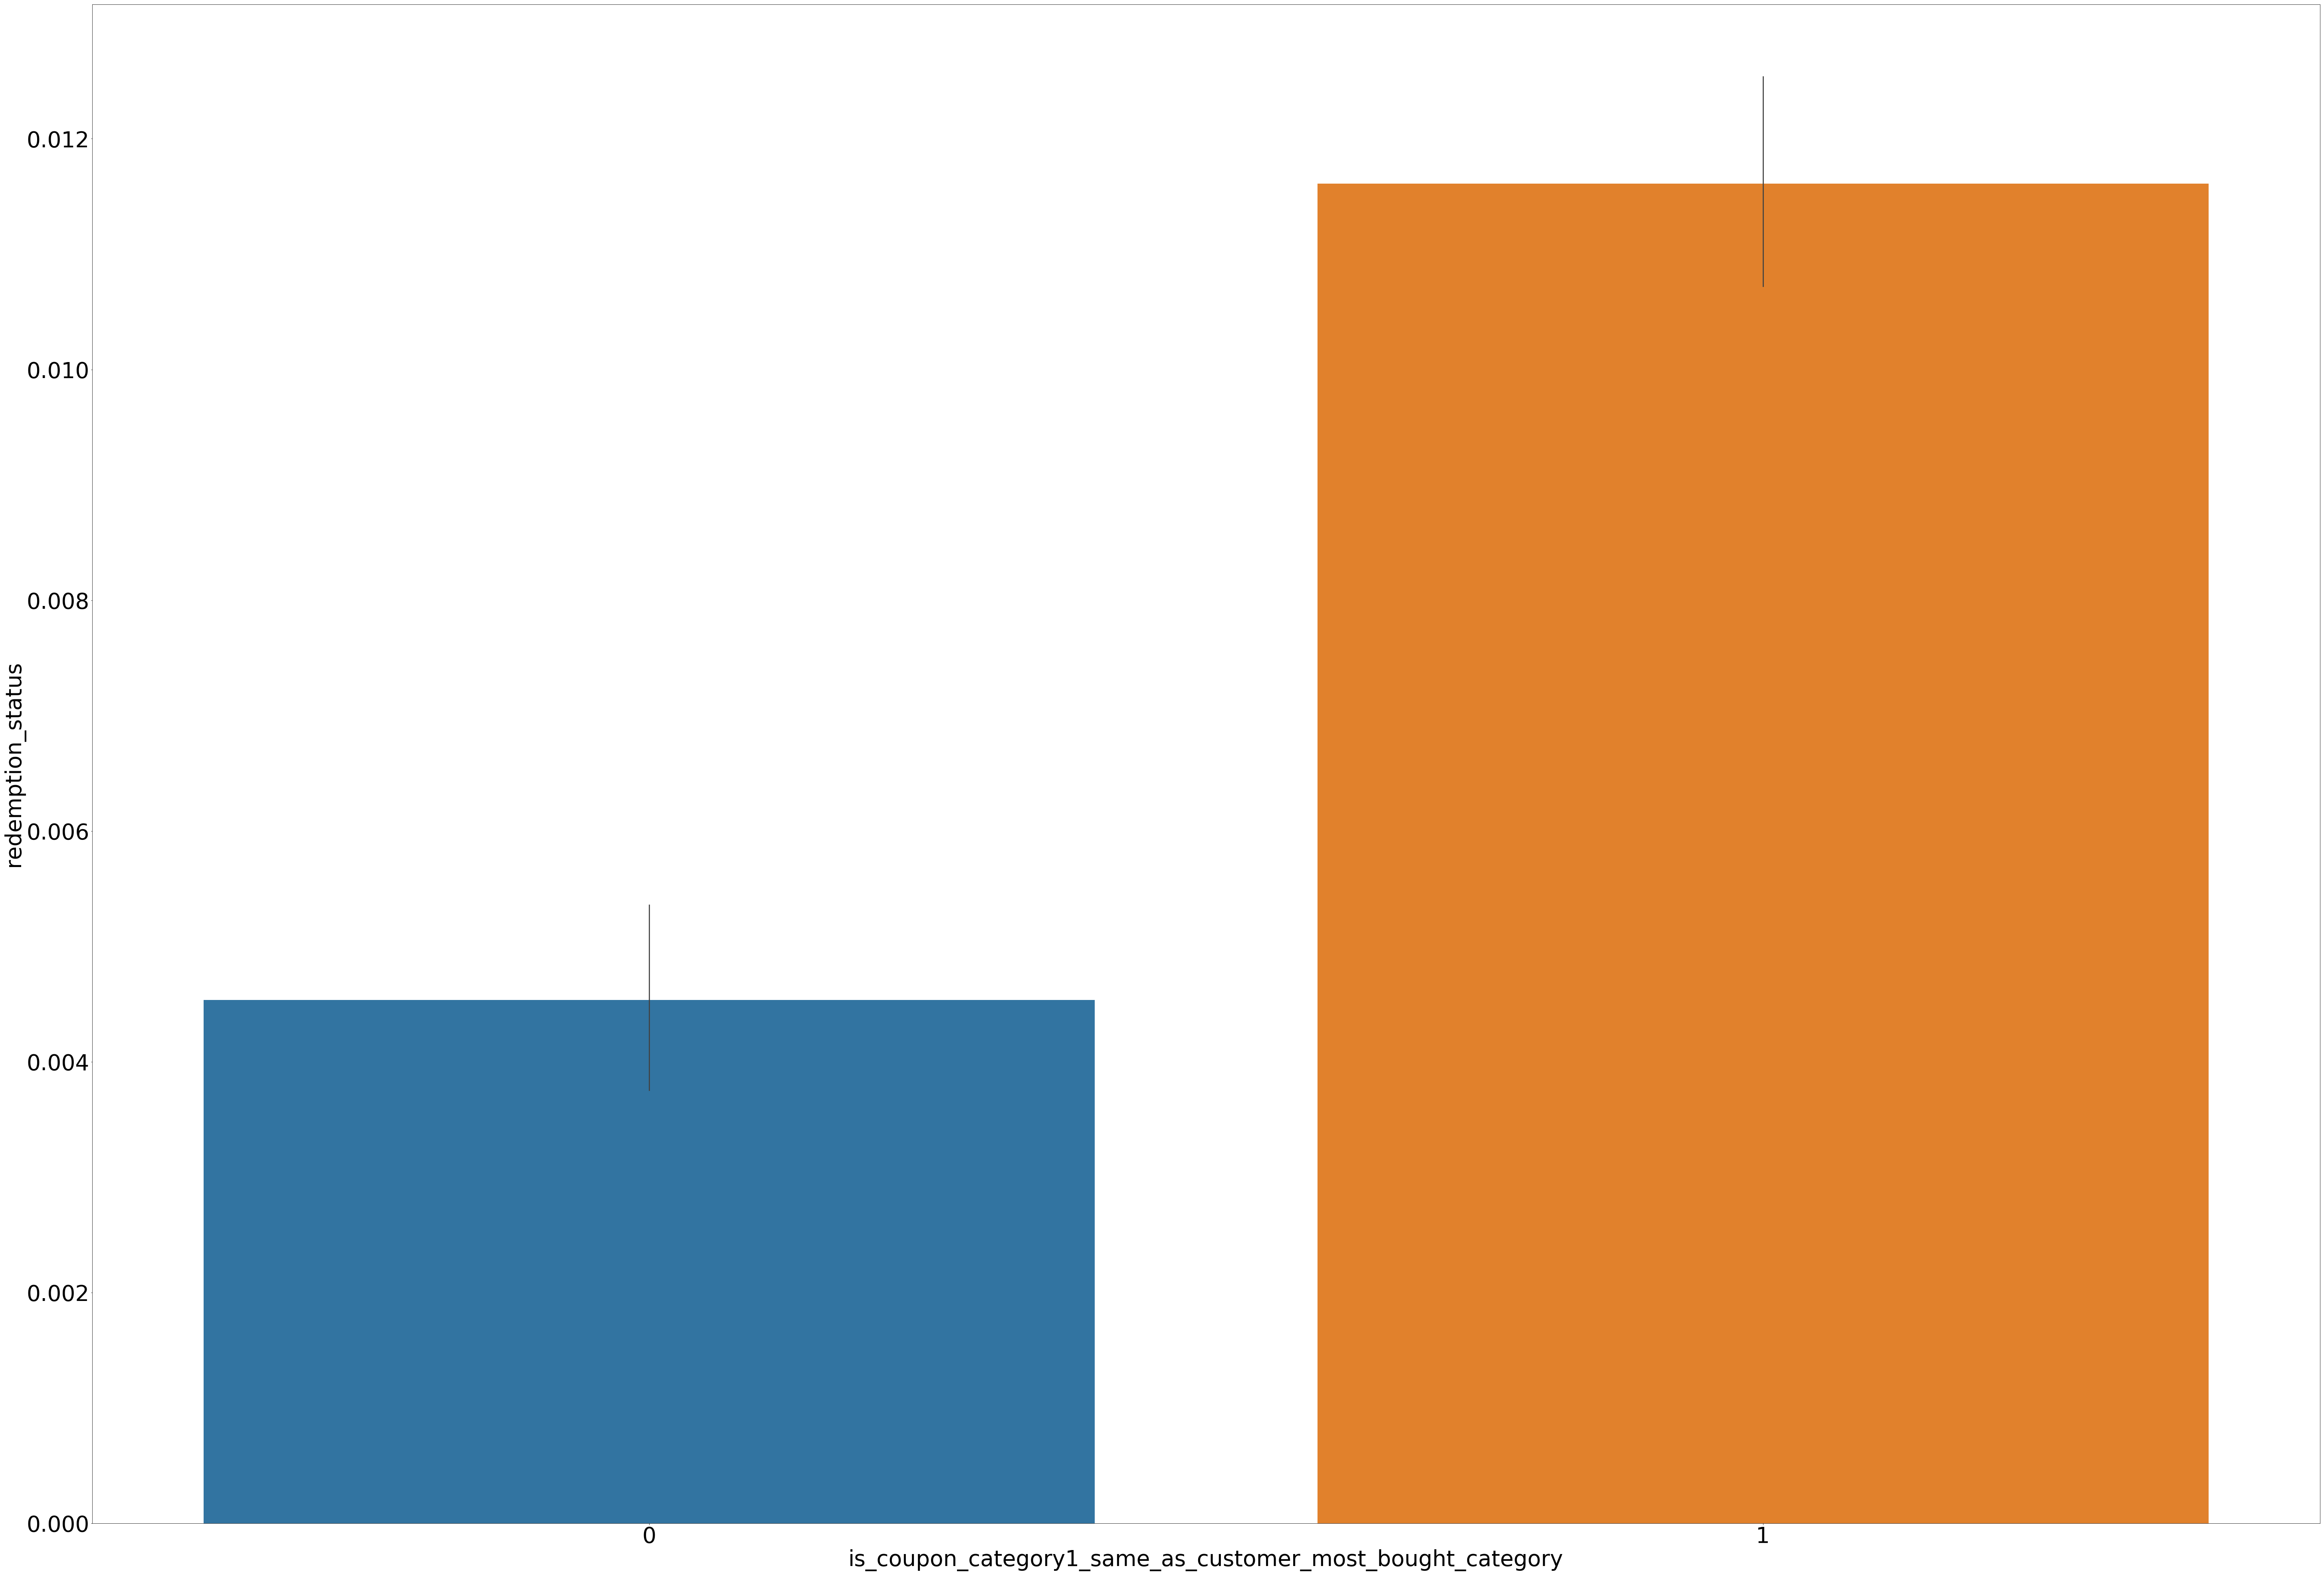

In [86]:
sns.barplot(x="is_coupon_category1_same_as_customer_most_bought_category", y="redemption_status", data=merged_data)

### is_brand1_same_as_most_favourite_brand_of_user_in_category1

In [64]:
grouped_df = customer_transaction_data.groupby(by=['customer_id', 'category'])
grouped_df

In [77]:
customer_ids=[]
category = []
most_favourite_brand1 = []
most_favourite_brand2 = []
for name, group in grouped_df:
    customer_ids.append(name[0])
    category.append(name[1])
    c = Counter(group.brand.to_list())
    most_favourite_brand1.append(c.most_common(2)[0][0])
    print ("Most favourite brand for user: ",name[0]," in category: ", name[1], " is: ",c.most_common(2)[0][0])
    if (len(c.most_common(2)) >1):
        most_favourite_brand2.append(c.most_common(2)[1][0])
        print ("Second Most favourite brand for user: ",name[0]," in category: ", name[1], " is: ",c.most_common(2)[1][0])
    else:
        most_favourite_brand2.append(c.most_common(2)[0][0])

Most favourite brand for user:  1  in category:  Bakery  is:  1
Second Most favourite brand for user:  1  in category:  Bakery  is:  154
Most favourite brand for user:  1  in category:  Dairy, Juices & Snacks  is:  522
Second Most favourite brand for user:  1  in category:  Dairy, Juices & Snacks  is:  592
Most favourite brand for user:  1  in category:  Grocery  is:  141
Second Most favourite brand for user:  1  in category:  Grocery  is:  56
Most favourite brand for user:  1  in category:  Meat  is:  3235
Second Most favourite brand for user:  1  in category:  Meat  is:  1113
Most favourite brand for user:  1  in category:  Natural Products  is:  1487
Second Most favourite brand for user:  1  in category:  Natural Products  is:  56
Most favourite brand for user:  1  in category:  Packaged Meat  is:  1898
Second Most favourite brand for user:  1  in category:  Packaged Meat  is:  989
Most favourite brand for user:  1  in category:  Pharmaceutical  is:  1981
Second Most favourite brand

Second Most favourite brand for user:  16  in category:  Packaged Meat  is:  984
Most favourite brand for user:  16  in category:  Pharmaceutical  is:  482
Second Most favourite brand for user:  16  in category:  Pharmaceutical  is:  686
Most favourite brand for user:  16  in category:  Skin & Hair Care  is:  56
Second Most favourite brand for user:  16  in category:  Skin & Hair Care  is:  1420
Most favourite brand for user:  17  in category:  Bakery  is:  1620
Second Most favourite brand for user:  17  in category:  Bakery  is:  4680
Most favourite brand for user:  17  in category:  Fuel  is:  56
Most favourite brand for user:  17  in category:  Grocery  is:  56
Second Most favourite brand for user:  17  in category:  Grocery  is:  1447
Most favourite brand for user:  17  in category:  Meat  is:  4208
Second Most favourite brand for user:  17  in category:  Meat  is:  4213
Most favourite brand for user:  17  in category:  Miscellaneous  is:  1862
Most favourite brand for user:  17  i

Second Most favourite brand for user:  30  in category:  Seafood  is:  241
Most favourite brand for user:  31  in category:  Dairy, Juices & Snacks  is:  56
Most favourite brand for user:  31  in category:  Fuel  is:  56
Most favourite brand for user:  31  in category:  Grocery  is:  56
Second Most favourite brand for user:  31  in category:  Grocery  is:  89
Most favourite brand for user:  31  in category:  Meat  is:  56
Second Most favourite brand for user:  31  in category:  Meat  is:  2589
Most favourite brand for user:  31  in category:  Natural Products  is:  56
Second Most favourite brand for user:  31  in category:  Natural Products  is:  602
Most favourite brand for user:  31  in category:  Packaged Meat  is:  56
Most favourite brand for user:  31  in category:  Pharmaceutical  is:  1149
Second Most favourite brand for user:  31  in category:  Pharmaceutical  is:  158
Most favourite brand for user:  32  in category:  Grocery  is:  56
Second Most favourite brand for user:  32  

Second Most favourite brand for user:  40  in category:  Seafood  is:  661
Most favourite brand for user:  41  in category:  Bakery  is:  574
Second Most favourite brand for user:  41  in category:  Bakery  is:  56
Most favourite brand for user:  41  in category:  Dairy, Juices & Snacks  is:  1966
Second Most favourite brand for user:  41  in category:  Dairy, Juices & Snacks  is:  1807
Most favourite brand for user:  41  in category:  Fuel  is:  56
Most favourite brand for user:  41  in category:  Grocery  is:  1447
Second Most favourite brand for user:  41  in category:  Grocery  is:  56
Most favourite brand for user:  41  in category:  Meat  is:  3235
Second Most favourite brand for user:  41  in category:  Meat  is:  2548
Most favourite brand for user:  41  in category:  Miscellaneous  is:  1
Most favourite brand for user:  41  in category:  Natural Products  is:  1
Second Most favourite brand for user:  41  in category:  Natural Products  is:  56
Most favourite brand for user:  41

Most favourite brand for user:  51  in category:  Dairy, Juices & Snacks  is:  789
Most favourite brand for user:  51  in category:  Grocery  is:  56
Second Most favourite brand for user:  51  in category:  Grocery  is:  2074
Most favourite brand for user:  51  in category:  Meat  is:  4235
Second Most favourite brand for user:  51  in category:  Meat  is:  3777
Most favourite brand for user:  51  in category:  Miscellaneous  is:  3498
Most favourite brand for user:  51  in category:  Natural Products  is:  1
Second Most favourite brand for user:  51  in category:  Natural Products  is:  56
Most favourite brand for user:  51  in category:  Packaged Meat  is:  1278
Second Most favourite brand for user:  51  in category:  Packaged Meat  is:  4700
Most favourite brand for user:  51  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  51  in category:  Pharmaceutical  is:  1041
Most favourite brand for user:  51  in category:  Seafood  is:  56
Most favourite brand 

Second Most favourite brand for user:  61  in category:  Packaged Meat  is:  350
Most favourite brand for user:  61  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  61  in category:  Pharmaceutical  is:  1041
Most favourite brand for user:  61  in category:  Prepared Food  is:  2039
Second Most favourite brand for user:  61  in category:  Prepared Food  is:  404
Most favourite brand for user:  61  in category:  Skin & Hair Care  is:  866
Second Most favourite brand for user:  61  in category:  Skin & Hair Care  is:  56
Most favourite brand for user:  62  in category:  Alcohol  is:  2240
Second Most favourite brand for user:  62  in category:  Alcohol  is:  2372
Most favourite brand for user:  62  in category:  Bakery  is:  1
Second Most favourite brand for user:  62  in category:  Bakery  is:  56
Most favourite brand for user:  62  in category:  Dairy, Juices & Snacks  is:  400
Second Most favourite brand for user:  62  in category:  Dairy, Juices & Snacks 

Most favourite brand for user:  75  in category:  Bakery  is:  1
Second Most favourite brand for user:  75  in category:  Bakery  is:  607
Most favourite brand for user:  75  in category:  Dairy, Juices & Snacks  is:  5154
Second Most favourite brand for user:  75  in category:  Dairy, Juices & Snacks  is:  56
Most favourite brand for user:  75  in category:  Flowers & Plants  is:  602
Most favourite brand for user:  75  in category:  Fuel  is:  56
Most favourite brand for user:  75  in category:  Garden  is:  602
Most favourite brand for user:  75  in category:  Grocery  is:  56
Second Most favourite brand for user:  75  in category:  Grocery  is:  946
Most favourite brand for user:  75  in category:  Meat  is:  3825
Second Most favourite brand for user:  75  in category:  Meat  is:  56
Most favourite brand for user:  75  in category:  Miscellaneous  is:  179
Most favourite brand for user:  75  in category:  Natural Products  is:  602
Second Most favourite brand for user:  75  in cate

Most favourite brand for user:  85  in category:  Meat  is:  3513
Second Most favourite brand for user:  85  in category:  Meat  is:  3773
Most favourite brand for user:  85  in category:  Natural Products  is:  1
Second Most favourite brand for user:  85  in category:  Natural Products  is:  56
Most favourite brand for user:  85  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  85  in category:  Packaged Meat  is:  1278
Most favourite brand for user:  85  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  85  in category:  Pharmaceutical  is:  619
Most favourite brand for user:  85  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  85  in category:  Prepared Food  is:  1
Most favourite brand for user:  85  in category:  Seafood  is:  241
Second Most favourite brand for user:  85  in category:  Seafood  is:  982
Most favourite brand for user:  85  in category:  Skin & Hair Care  is:  4370
Most favourite bran

Second Most favourite brand for user:  97  in category:  Dairy, Juices & Snacks  is:  4700
Most favourite brand for user:  97  in category:  Flowers & Plants  is:  602
Most favourite brand for user:  97  in category:  Fuel  is:  56
Most favourite brand for user:  97  in category:  Grocery  is:  56
Second Most favourite brand for user:  97  in category:  Grocery  is:  1244
Most favourite brand for user:  97  in category:  Meat  is:  2536
Second Most favourite brand for user:  97  in category:  Meat  is:  2585
Most favourite brand for user:  97  in category:  Natural Products  is:  602
Second Most favourite brand for user:  97  in category:  Natural Products  is:  1
Most favourite brand for user:  97  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  97  in category:  Packaged Meat  is:  421
Most favourite brand for user:  97  in category:  Pharmaceutical  is:  4467
Second Most favourite brand for user:  97  in category:  Pharmaceutical  is:  855
Most favourite 

Second Most favourite brand for user:  111  in category:  Prepared Food  is:  56
Most favourite brand for user:  111  in category:  Seafood  is:  982
Most favourite brand for user:  112  in category:  Bakery  is:  1863
Second Most favourite brand for user:  112  in category:  Bakery  is:  5451
Most favourite brand for user:  112  in category:  Dairy, Juices & Snacks  is:  2131
Most favourite brand for user:  112  in category:  Fuel  is:  56
Most favourite brand for user:  112  in category:  Grocery  is:  56
Second Most favourite brand for user:  112  in category:  Grocery  is:  1143
Most favourite brand for user:  112  in category:  Meat  is:  3665
Second Most favourite brand for user:  112  in category:  Meat  is:  4125
Most favourite brand for user:  112  in category:  Miscellaneous  is:  1
Second Most favourite brand for user:  112  in category:  Miscellaneous  is:  5348
Most favourite brand for user:  112  in category:  Natural Products  is:  56
Second Most favourite brand for user

Most favourite brand for user:  126  in category:  Skin & Hair Care  is:  368
Most favourite brand for user:  127  in category:  Bakery  is:  56
Second Most favourite brand for user:  127  in category:  Bakery  is:  4763
Most favourite brand for user:  127  in category:  Fuel  is:  56
Most favourite brand for user:  127  in category:  Grocery  is:  56
Second Most favourite brand for user:  127  in category:  Grocery  is:  278
Most favourite brand for user:  127  in category:  Meat  is:  3512
Second Most favourite brand for user:  127  in category:  Meat  is:  2582
Most favourite brand for user:  127  in category:  Miscellaneous  is:  5086
Most favourite brand for user:  127  in category:  Natural Products  is:  1487
Second Most favourite brand for user:  127  in category:  Natural Products  is:  56
Most favourite brand for user:  127  in category:  Packaged Meat  is:  989
Second Most favourite brand for user:  127  in category:  Packaged Meat  is:  56
Most favourite brand for user:  12

Most favourite brand for user:  140  in category:  Natural Products  is:  1487
Second Most favourite brand for user:  140  in category:  Natural Products  is:  56
Most favourite brand for user:  140  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  140  in category:  Packaged Meat  is:  984
Most favourite brand for user:  140  in category:  Pharmaceutical  is:  1501
Second Most favourite brand for user:  140  in category:  Pharmaceutical  is:  24
Most favourite brand for user:  140  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  140  in category:  Prepared Food  is:  934
Most favourite brand for user:  140  in category:  Seafood  is:  56
Second Most favourite brand for user:  140  in category:  Seafood  is:  661
Most favourite brand for user:  140  in category:  Skin & Hair Care  is:  328
Second Most favourite brand for user:  140  in category:  Skin & Hair Care  is:  4453
Most favourite brand for user:  141  in category:  Alcohol

Second Most favourite brand for user:  153  in category:  Alcohol  is:  2376
Most favourite brand for user:  153  in category:  Bakery  is:  56
Second Most favourite brand for user:  153  in category:  Bakery  is:  1
Most favourite brand for user:  153  in category:  Dairy, Juices & Snacks  is:  56
Second Most favourite brand for user:  153  in category:  Dairy, Juices & Snacks  is:  789
Most favourite brand for user:  153  in category:  Flowers & Plants  is:  578
Most favourite brand for user:  153  in category:  Garden  is:  5073
Most favourite brand for user:  153  in category:  Grocery  is:  56
Second Most favourite brand for user:  153  in category:  Grocery  is:  1025
Most favourite brand for user:  153  in category:  Meat  is:  3826
Second Most favourite brand for user:  153  in category:  Meat  is:  3767
Most favourite brand for user:  153  in category:  Miscellaneous  is:  4603
Second Most favourite brand for user:  153  in category:  Miscellaneous  is:  4
Most favourite brand

Second Most favourite brand for user:  165  in category:  Grocery  is:  487
Most favourite brand for user:  165  in category:  Meat  is:  2571
Second Most favourite brand for user:  165  in category:  Meat  is:  3858
Most favourite brand for user:  165  in category:  Natural Products  is:  56
Second Most favourite brand for user:  165  in category:  Natural Products  is:  1
Most favourite brand for user:  165  in category:  Packaged Meat  is:  1898
Second Most favourite brand for user:  165  in category:  Packaged Meat  is:  984
Most favourite brand for user:  165  in category:  Pharmaceutical  is:  4467
Second Most favourite brand for user:  165  in category:  Pharmaceutical  is:  43
Most favourite brand for user:  165  in category:  Prepared Food  is:  3423
Most favourite brand for user:  166  in category:  Alcohol  is:  2358
Most favourite brand for user:  166  in category:  Bakery  is:  1
Most favourite brand for user:  166  in category:  Dairy, Juices & Snacks  is:  789
Second Mos

Most favourite brand for user:  180  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  180  in category:  Packaged Meat  is:  1898
Most favourite brand for user:  180  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  180  in category:  Pharmaceutical  is:  686
Most favourite brand for user:  180  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  180  in category:  Prepared Food  is:  1905
Most favourite brand for user:  180  in category:  Salads  is:  2004
Most favourite brand for user:  180  in category:  Skin & Hair Care  is:  2479
Second Most favourite brand for user:  180  in category:  Skin & Hair Care  is:  1420
Most favourite brand for user:  181  in category:  Bakery  is:  56
Second Most favourite brand for user:  181  in category:  Bakery  is:  607
Most favourite brand for user:  181  in category:  Fuel  is:  56
Most favourite brand for user:  181  in category:  Grocery  is:  56
Second Most favouri

Most favourite brand for user:  194  in category:  Grocery  is:  56
Second Most favourite brand for user:  194  in category:  Grocery  is:  2025
Most favourite brand for user:  194  in category:  Meat  is:  4230
Second Most favourite brand for user:  194  in category:  Meat  is:  3749
Most favourite brand for user:  194  in category:  Miscellaneous  is:  1
Most favourite brand for user:  194  in category:  Natural Products  is:  56
Second Most favourite brand for user:  194  in category:  Natural Products  is:  602
Most favourite brand for user:  194  in category:  Packaged Meat  is:  989
Second Most favourite brand for user:  194  in category:  Packaged Meat  is:  56
Most favourite brand for user:  194  in category:  Pharmaceutical  is:  475
Second Most favourite brand for user:  194  in category:  Pharmaceutical  is:  56
Most favourite brand for user:  194  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  194  in category:  Prepared Food  is:  2150
Most fav

Second Most favourite brand for user:  206  in category:  Bakery  is:  56
Most favourite brand for user:  206  in category:  Dairy, Juices & Snacks  is:  224
Second Most favourite brand for user:  206  in category:  Dairy, Juices & Snacks  is:  4972
Most favourite brand for user:  206  in category:  Fuel  is:  56
Most favourite brand for user:  206  in category:  Grocery  is:  56
Second Most favourite brand for user:  206  in category:  Grocery  is:  89
Most favourite brand for user:  206  in category:  Meat  is:  3521
Second Most favourite brand for user:  206  in category:  Meat  is:  3520
Most favourite brand for user:  206  in category:  Natural Products  is:  1
Second Most favourite brand for user:  206  in category:  Natural Products  is:  1487
Most favourite brand for user:  206  in category:  Packaged Meat  is:  989
Second Most favourite brand for user:  206  in category:  Packaged Meat  is:  350
Most favourite brand for user:  206  in category:  Pharmaceutical  is:  56
Second 

Most favourite brand for user:  220  in category:  Grocery  is:  56
Second Most favourite brand for user:  220  in category:  Grocery  is:  487
Most favourite brand for user:  220  in category:  Meat  is:  3519
Second Most favourite brand for user:  220  in category:  Meat  is:  3530
Most favourite brand for user:  220  in category:  Natural Products  is:  1487
Second Most favourite brand for user:  220  in category:  Natural Products  is:  602
Most favourite brand for user:  220  in category:  Packaged Meat  is:  989
Second Most favourite brand for user:  220  in category:  Packaged Meat  is:  56
Most favourite brand for user:  220  in category:  Pharmaceutical  is:  158
Second Most favourite brand for user:  220  in category:  Pharmaceutical  is:  303
Most favourite brand for user:  220  in category:  Prepared Food  is:  1946
Second Most favourite brand for user:  220  in category:  Prepared Food  is:  3735
Most favourite brand for user:  220  in category:  Seafood  is:  56
Second Mo

Second Most favourite brand for user:  232  in category:  Natural Products  is:  1
Most favourite brand for user:  232  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  232  in category:  Packaged Meat  is:  1278
Most favourite brand for user:  232  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  232  in category:  Pharmaceutical  is:  4302
Most favourite brand for user:  232  in category:  Prepared Food  is:  56
Most favourite brand for user:  232  in category:  Seafood  is:  2062
Second Most favourite brand for user:  232  in category:  Seafood  is:  56
Most favourite brand for user:  232  in category:  Vegetables (cut)  is:  2794
Second Most favourite brand for user:  232  in category:  Vegetables (cut)  is:  2789
Most favourite brand for user:  233  in category:  Bakery  is:  56
Second Most favourite brand for user:  233  in category:  Bakery  is:  1
Most favourite brand for user:  233  in category:  Flowers & Plants  is:  246

Second Most favourite brand for user:  244  in category:  Bakery  is:  4763
Most favourite brand for user:  244  in category:  Grocery  is:  56
Second Most favourite brand for user:  244  in category:  Grocery  is:  278
Most favourite brand for user:  244  in category:  Meat  is:  4563
Second Most favourite brand for user:  244  in category:  Meat  is:  2582
Most favourite brand for user:  244  in category:  Miscellaneous  is:  4
Second Most favourite brand for user:  244  in category:  Miscellaneous  is:  602
Most favourite brand for user:  244  in category:  Natural Products  is:  602
Second Most favourite brand for user:  244  in category:  Natural Products  is:  56
Most favourite brand for user:  244  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  244  in category:  Packaged Meat  is:  984
Most favourite brand for user:  244  in category:  Pharmaceutical  is:  5220
Second Most favourite brand for user:  244  in category:  Pharmaceutical  is:  619
Most f

Most favourite brand for user:  257  in category:  Bakery  is:  1
Second Most favourite brand for user:  257  in category:  Bakery  is:  4763
Most favourite brand for user:  257  in category:  Flowers & Plants  is:  56
Most favourite brand for user:  257  in category:  Fuel  is:  56
Most favourite brand for user:  257  in category:  Grocery  is:  56
Second Most favourite brand for user:  257  in category:  Grocery  is:  1065
Most favourite brand for user:  257  in category:  Meat  is:  56
Second Most favourite brand for user:  257  in category:  Meat  is:  2702
Most favourite brand for user:  257  in category:  Natural Products  is:  1
Second Most favourite brand for user:  257  in category:  Natural Products  is:  602
Most favourite brand for user:  257  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  257  in category:  Packaged Meat  is:  692
Most favourite brand for user:  257  in category:  Pharmaceutical  is:  1501
Second Most favourite brand for user: 

Most favourite brand for user:  269  in category:  Skin & Hair Care  is:  4358
Second Most favourite brand for user:  269  in category:  Skin & Hair Care  is:  4453
Most favourite brand for user:  270  in category:  Alcohol  is:  2219
Second Most favourite brand for user:  270  in category:  Alcohol  is:  2372
Most favourite brand for user:  270  in category:  Bakery  is:  5451
Second Most favourite brand for user:  270  in category:  Bakery  is:  56
Most favourite brand for user:  270  in category:  Dairy, Juices & Snacks  is:  56
Second Most favourite brand for user:  270  in category:  Dairy, Juices & Snacks  is:  789
Most favourite brand for user:  270  in category:  Fuel  is:  56
Most favourite brand for user:  270  in category:  Grocery  is:  56
Second Most favourite brand for user:  270  in category:  Grocery  is:  172
Most favourite brand for user:  270  in category:  Meat  is:  3773
Second Most favourite brand for user:  270  in category:  Meat  is:  3772
Most favourite brand 

Second Most favourite brand for user:  283  in category:  Pharmaceutical  is:  1274
Most favourite brand for user:  283  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  283  in category:  Prepared Food  is:  2230
Most favourite brand for user:  283  in category:  Seafood  is:  56
Second Most favourite brand for user:  283  in category:  Seafood  is:  982
Most favourite brand for user:  283  in category:  Skin & Hair Care  is:  1420
Most favourite brand for user:  284  in category:  Bakery  is:  56
Second Most favourite brand for user:  284  in category:  Bakery  is:  1
Most favourite brand for user:  284  in category:  Dairy, Juices & Snacks  is:  4972
Most favourite brand for user:  284  in category:  Flowers & Plants  is:  602
Most favourite brand for user:  284  in category:  Grocery  is:  56
Second Most favourite brand for user:  284  in category:  Grocery  is:  1124
Most favourite brand for user:  284  in category:  Meat  is:  3513
Second Most favourite

Second Most favourite brand for user:  298  in category:  Seafood  is:  1552
Most favourite brand for user:  298  in category:  Skin & Hair Care  is:  1957
Second Most favourite brand for user:  298  in category:  Skin & Hair Care  is:  1766
Most favourite brand for user:  299  in category:  Bakery  is:  1
Second Most favourite brand for user:  299  in category:  Bakery  is:  4680
Most favourite brand for user:  299  in category:  Dairy, Juices & Snacks  is:  5096
Second Most favourite brand for user:  299  in category:  Dairy, Juices & Snacks  is:  789
Most favourite brand for user:  299  in category:  Fuel  is:  56
Most favourite brand for user:  299  in category:  Grocery  is:  56
Second Most favourite brand for user:  299  in category:  Grocery  is:  1088
Most favourite brand for user:  299  in category:  Meat  is:  2735
Second Most favourite brand for user:  299  in category:  Meat  is:  2733
Most favourite brand for user:  299  in category:  Miscellaneous  is:  56
Second Most fav

Second Most favourite brand for user:  311  in category:  Pharmaceutical  is:  2088
Most favourite brand for user:  311  in category:  Prepared Food  is:  56
Most favourite brand for user:  311  in category:  Seafood  is:  56
Second Most favourite brand for user:  311  in category:  Seafood  is:  241
Most favourite brand for user:  312  in category:  Bakery  is:  56
Second Most favourite brand for user:  312  in category:  Bakery  is:  869
Most favourite brand for user:  312  in category:  Fuel  is:  56
Most favourite brand for user:  312  in category:  Grocery  is:  56
Second Most favourite brand for user:  312  in category:  Grocery  is:  89
Most favourite brand for user:  312  in category:  Meat  is:  56
Second Most favourite brand for user:  312  in category:  Meat  is:  3773
Most favourite brand for user:  312  in category:  Natural Products  is:  56
Second Most favourite brand for user:  312  in category:  Natural Products  is:  1
Most favourite brand for user:  312  in category:

Most favourite brand for user:  326  in category:  Grocery  is:  56
Second Most favourite brand for user:  326  in category:  Grocery  is:  487
Most favourite brand for user:  326  in category:  Meat  is:  3773
Second Most favourite brand for user:  326  in category:  Meat  is:  3795
Most favourite brand for user:  326  in category:  Natural Products  is:  1637
Second Most favourite brand for user:  326  in category:  Natural Products  is:  1294
Most favourite brand for user:  326  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  326  in category:  Packaged Meat  is:  350
Most favourite brand for user:  326  in category:  Pharmaceutical  is:  619
Second Most favourite brand for user:  326  in category:  Pharmaceutical  is:  56
Most favourite brand for user:  326  in category:  Prepared Food  is:  56
Most favourite brand for user:  326  in category:  Seafood  is:  56
Second Most favourite brand for user:  326  in category:  Seafood  is:  654
Most favourite bra

Second Most favourite brand for user:  340  in category:  Dairy, Juices & Snacks  is:  168
Most favourite brand for user:  340  in category:  Grocery  is:  56
Second Most favourite brand for user:  340  in category:  Grocery  is:  1143
Most favourite brand for user:  340  in category:  Meat  is:  3229
Second Most favourite brand for user:  340  in category:  Meat  is:  3672
Most favourite brand for user:  340  in category:  Miscellaneous  is:  1714
Most favourite brand for user:  340  in category:  Natural Products  is:  602
Second Most favourite brand for user:  340  in category:  Natural Products  is:  56
Most favourite brand for user:  340  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  340  in category:  Packaged Meat  is:  1278
Most favourite brand for user:  340  in category:  Pharmaceutical  is:  1501
Second Most favourite brand for user:  340  in category:  Pharmaceutical  is:  771
Most favourite brand for user:  340  in category:  Seafood  is:  56


Second Most favourite brand for user:  352  in category:  Packaged Meat  is:  1278
Most favourite brand for user:  352  in category:  Pharmaceutical  is:  619
Second Most favourite brand for user:  352  in category:  Pharmaceutical  is:  475
Most favourite brand for user:  352  in category:  Prepared Food  is:  3984
Second Most favourite brand for user:  352  in category:  Prepared Food  is:  3424
Most favourite brand for user:  353  in category:  Bakery  is:  762
Second Most favourite brand for user:  353  in category:  Bakery  is:  4619
Most favourite brand for user:  353  in category:  Dairy, Juices & Snacks  is:  5402
Second Most favourite brand for user:  353  in category:  Dairy, Juices & Snacks  is:  168
Most favourite brand for user:  353  in category:  Flowers & Plants  is:  602
Most favourite brand for user:  353  in category:  Fuel  is:  56
Most favourite brand for user:  353  in category:  Grocery  is:  56
Second Most favourite brand for user:  353  in category:  Grocery  i

Most favourite brand for user:  366  in category:  Grocery  is:  56
Second Most favourite brand for user:  366  in category:  Grocery  is:  1101
Most favourite brand for user:  366  in category:  Meat  is:  56
Second Most favourite brand for user:  366  in category:  Meat  is:  2594
Most favourite brand for user:  366  in category:  Natural Products  is:  56
Second Most favourite brand for user:  366  in category:  Natural Products  is:  602
Most favourite brand for user:  366  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  366  in category:  Packaged Meat  is:  1105
Most favourite brand for user:  366  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  366  in category:  Pharmaceutical  is:  1162
Most favourite brand for user:  366  in category:  Prepared Food  is:  56
Most favourite brand for user:  366  in category:  Seafood  is:  56
Second Most favourite brand for user:  366  in category:  Seafood  is:  909
Most favourite brand

Most favourite brand for user:  376  in category:  Seafood  is:  56
Second Most favourite brand for user:  376  in category:  Seafood  is:  879
Most favourite brand for user:  377  in category:  Bakery  is:  1
Second Most favourite brand for user:  377  in category:  Bakery  is:  4763
Most favourite brand for user:  377  in category:  Dairy, Juices & Snacks  is:  789
Second Most favourite brand for user:  377  in category:  Dairy, Juices & Snacks  is:  1918
Most favourite brand for user:  377  in category:  Fuel  is:  56
Most favourite brand for user:  377  in category:  Grocery  is:  56
Second Most favourite brand for user:  377  in category:  Grocery  is:  89
Most favourite brand for user:  377  in category:  Meat  is:  56
Second Most favourite brand for user:  377  in category:  Meat  is:  3519
Most favourite brand for user:  377  in category:  Natural Products  is:  602
Second Most favourite brand for user:  377  in category:  Natural Products  is:  1
Most favourite brand for user:

Most favourite brand for user:  387  in category:  Skin & Hair Care  is:  1070
Most favourite brand for user:  388  in category:  Bakery  is:  56
Second Most favourite brand for user:  388  in category:  Bakery  is:  4763
Most favourite brand for user:  388  in category:  Grocery  is:  56
Second Most favourite brand for user:  388  in category:  Grocery  is:  1337
Most favourite brand for user:  388  in category:  Meat  is:  4476
Second Most favourite brand for user:  388  in category:  Meat  is:  4184
Most favourite brand for user:  388  in category:  Natural Products  is:  56
Second Most favourite brand for user:  388  in category:  Natural Products  is:  172
Most favourite brand for user:  388  in category:  Packaged Meat  is:  989
Second Most favourite brand for user:  388  in category:  Packaged Meat  is:  984
Most favourite brand for user:  388  in category:  Pharmaceutical  is:  686
Second Most favourite brand for user:  388  in category:  Pharmaceutical  is:  4376
Most favourit

Most favourite brand for user:  399  in category:  Grocery  is:  56
Second Most favourite brand for user:  399  in category:  Grocery  is:  623
Most favourite brand for user:  399  in category:  Meat  is:  3513
Second Most favourite brand for user:  399  in category:  Meat  is:  3240
Most favourite brand for user:  399  in category:  Natural Products  is:  56
Second Most favourite brand for user:  399  in category:  Natural Products  is:  602
Most favourite brand for user:  399  in category:  Packaged Meat  is:  1000
Second Most favourite brand for user:  399  in category:  Packaged Meat  is:  989
Most favourite brand for user:  399  in category:  Pharmaceutical  is:  619
Second Most favourite brand for user:  399  in category:  Pharmaceutical  is:  56
Most favourite brand for user:  399  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  399  in category:  Prepared Food  is:  3297
Most favourite brand for user:  399  in category:  Seafood  is:  982
Second Most

Most favourite brand for user:  413  in category:  Dairy, Juices & Snacks  is:  789
Second Most favourite brand for user:  413  in category:  Dairy, Juices & Snacks  is:  2271
Most favourite brand for user:  413  in category:  Fuel  is:  56
Most favourite brand for user:  413  in category:  Garden  is:  5073
Most favourite brand for user:  413  in category:  Grocery  is:  56
Second Most favourite brand for user:  413  in category:  Grocery  is:  1088
Most favourite brand for user:  413  in category:  Meat  is:  4476
Second Most favourite brand for user:  413  in category:  Meat  is:  2550
Most favourite brand for user:  413  in category:  Miscellaneous  is:  1245
Most favourite brand for user:  413  in category:  Natural Products  is:  602
Second Most favourite brand for user:  413  in category:  Natural Products  is:  1487
Most favourite brand for user:  413  in category:  Packaged Meat  is:  350
Second Most favourite brand for user:  413  in category:  Packaged Meat  is:  5091
Most f

Most favourite brand for user:  426  in category:  Bakery  is:  4619
Second Most favourite brand for user:  426  in category:  Bakery  is:  56
Most favourite brand for user:  426  in category:  Dairy, Juices & Snacks  is:  1497
Second Most favourite brand for user:  426  in category:  Dairy, Juices & Snacks  is:  923
Most favourite brand for user:  426  in category:  Flowers & Plants  is:  56
Most favourite brand for user:  426  in category:  Fuel  is:  56
Most favourite brand for user:  426  in category:  Grocery  is:  1337
Second Most favourite brand for user:  426  in category:  Grocery  is:  56
Most favourite brand for user:  426  in category:  Meat  is:  3761
Second Most favourite brand for user:  426  in category:  Meat  is:  3762
Most favourite brand for user:  426  in category:  Miscellaneous  is:  4451
Second Most favourite brand for user:  426  in category:  Miscellaneous  is:  276
Most favourite brand for user:  426  in category:  Natural Products  is:  1487
Second Most favo

Most favourite brand for user:  437  in category:  Fuel  is:  56
Most favourite brand for user:  437  in category:  Grocery  is:  56
Second Most favourite brand for user:  437  in category:  Grocery  is:  544
Most favourite brand for user:  437  in category:  Meat  is:  56
Second Most favourite brand for user:  437  in category:  Meat  is:  3765
Most favourite brand for user:  437  in category:  Miscellaneous  is:  1
Most favourite brand for user:  437  in category:  Natural Products  is:  1487
Second Most favourite brand for user:  437  in category:  Natural Products  is:  1294
Most favourite brand for user:  437  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  437  in category:  Packaged Meat  is:  989
Most favourite brand for user:  437  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  437  in category:  Pharmaceutical  is:  4409
Most favourite brand for user:  437  in category:  Prepared Food  is:  56
Second Most favourite bra

Most favourite brand for user:  448  in category:  Flowers & Plants  is:  4700
Most favourite brand for user:  448  in category:  Fuel  is:  56
Most favourite brand for user:  448  in category:  Grocery  is:  56
Second Most favourite brand for user:  448  in category:  Grocery  is:  1337
Most favourite brand for user:  448  in category:  Meat  is:  1601
Second Most favourite brand for user:  448  in category:  Meat  is:  3381
Most favourite brand for user:  448  in category:  Miscellaneous  is:  602
Most favourite brand for user:  448  in category:  Natural Products  is:  56
Second Most favourite brand for user:  448  in category:  Natural Products  is:  1487
Most favourite brand for user:  448  in category:  Packaged Meat  is:  350
Second Most favourite brand for user:  448  in category:  Packaged Meat  is:  56
Most favourite brand for user:  448  in category:  Pharmaceutical  is:  644
Second Most favourite brand for user:  448  in category:  Pharmaceutical  is:  56
Most favourite bra

Second Most favourite brand for user:  456  in category:  Garden  is:  1190
Most favourite brand for user:  456  in category:  Grocery  is:  56
Second Most favourite brand for user:  456  in category:  Grocery  is:  278
Most favourite brand for user:  456  in category:  Meat  is:  1601
Second Most favourite brand for user:  456  in category:  Meat  is:  1113
Most favourite brand for user:  456  in category:  Miscellaneous  is:  56
Second Most favourite brand for user:  456  in category:  Miscellaneous  is:  1018
Most favourite brand for user:  456  in category:  Natural Products  is:  1487
Second Most favourite brand for user:  456  in category:  Natural Products  is:  602
Most favourite brand for user:  456  in category:  Packaged Meat  is:  984
Second Most favourite brand for user:  456  in category:  Packaged Meat  is:  56
Most favourite brand for user:  456  in category:  Pharmaceutical  is:  771
Second Most favourite brand for user:  456  in category:  Pharmaceutical  is:  56
Most

Second Most favourite brand for user:  468  in category:  Prepared Food  is:  56
Most favourite brand for user:  468  in category:  Seafood  is:  56
Second Most favourite brand for user:  468  in category:  Seafood  is:  2944
Most favourite brand for user:  468  in category:  Skin & Hair Care  is:  4453
Most favourite brand for user:  469  in category:  Bakery  is:  1710
Most favourite brand for user:  469  in category:  Grocery  is:  56
Second Most favourite brand for user:  469  in category:  Grocery  is:  487
Most favourite brand for user:  469  in category:  Meat  is:  56
Second Most favourite brand for user:  469  in category:  Meat  is:  2653
Most favourite brand for user:  469  in category:  Natural Products  is:  1
Second Most favourite brand for user:  469  in category:  Natural Products  is:  1487
Most favourite brand for user:  469  in category:  Packaged Meat  is:  350
Second Most favourite brand for user:  469  in category:  Packaged Meat  is:  989
Most favourite brand for

Most favourite brand for user:  482  in category:  Dairy, Juices & Snacks  is:  1975
Second Most favourite brand for user:  482  in category:  Dairy, Juices & Snacks  is:  923
Most favourite brand for user:  482  in category:  Fuel  is:  56
Most favourite brand for user:  482  in category:  Grocery  is:  56
Second Most favourite brand for user:  482  in category:  Grocery  is:  946
Most favourite brand for user:  482  in category:  Meat  is:  56
Second Most favourite brand for user:  482  in category:  Meat  is:  3765
Most favourite brand for user:  482  in category:  Natural Products  is:  1487
Second Most favourite brand for user:  482  in category:  Natural Products  is:  2069
Most favourite brand for user:  482  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  482  in category:  Packaged Meat  is:  1278
Most favourite brand for user:  482  in category:  Pharmaceutical  is:  1274
Second Most favourite brand for user:  482  in category:  Pharmaceutical  is:

Second Most favourite brand for user:  492  in category:  Dairy, Juices & Snacks  is:  487
Most favourite brand for user:  492  in category:  Grocery  is:  2084
Second Most favourite brand for user:  492  in category:  Grocery  is:  141
Most favourite brand for user:  492  in category:  Natural Products  is:  1487
Second Most favourite brand for user:  492  in category:  Natural Products  is:  582
Most favourite brand for user:  492  in category:  Packaged Meat  is:  1555
Second Most favourite brand for user:  492  in category:  Packaged Meat  is:  989
Most favourite brand for user:  492  in category:  Pharmaceutical  is:  686
Second Most favourite brand for user:  492  in category:  Pharmaceutical  is:  158
Most favourite brand for user:  492  in category:  Prepared Food  is:  3620
Second Most favourite brand for user:  492  in category:  Prepared Food  is:  4512
Most favourite brand for user:  492  in category:  Salads  is:  2004
Most favourite brand for user:  492  in category:  Ski

Second Most favourite brand for user:  504  in category:  Pharmaceutical  is:  619
Most favourite brand for user:  504  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  504  in category:  Prepared Food  is:  1308
Most favourite brand for user:  504  in category:  Seafood  is:  56
Most favourite brand for user:  505  in category:  Bakery  is:  56
Second Most favourite brand for user:  505  in category:  Bakery  is:  762
Most favourite brand for user:  505  in category:  Grocery  is:  56
Second Most favourite brand for user:  505  in category:  Grocery  is:  623
Most favourite brand for user:  505  in category:  Meat  is:  1393
Second Most favourite brand for user:  505  in category:  Meat  is:  2712
Most favourite brand for user:  505  in category:  Natural Products  is:  1
Second Most favourite brand for user:  505  in category:  Natural Products  is:  602
Most favourite brand for user:  505  in category:  Packaged Meat  is:  989
Second Most favourite brand f

Most favourite brand for user:  520  in category:  Miscellaneous  is:  4878
Most favourite brand for user:  520  in category:  Natural Products  is:  56
Second Most favourite brand for user:  520  in category:  Natural Products  is:  602
Most favourite brand for user:  520  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  520  in category:  Packaged Meat  is:  350
Most favourite brand for user:  520  in category:  Pharmaceutical  is:  158
Second Most favourite brand for user:  520  in category:  Pharmaceutical  is:  56
Most favourite brand for user:  520  in category:  Prepared Food  is:  56
Most favourite brand for user:  520  in category:  Restauarant  is:  1
Most favourite brand for user:  520  in category:  Salads  is:  3534
Most favourite brand for user:  520  in category:  Seafood  is:  56
Most favourite brand for user:  520  in category:  Skin & Hair Care  is:  5100
Most favourite brand for user:  521  in category:  Bakery  is:  56
Second Most favourit

Most favourite brand for user:  533  in category:  Natural Products  is:  1487
Second Most favourite brand for user:  533  in category:  Natural Products  is:  56
Most favourite brand for user:  533  in category:  Packaged Meat  is:  989
Second Most favourite brand for user:  533  in category:  Packaged Meat  is:  56
Most favourite brand for user:  533  in category:  Pharmaceutical  is:  101
Second Most favourite brand for user:  533  in category:  Pharmaceutical  is:  303
Most favourite brand for user:  533  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  533  in category:  Prepared Food  is:  190
Most favourite brand for user:  533  in category:  Seafood  is:  56
Second Most favourite brand for user:  533  in category:  Seafood  is:  5251
Most favourite brand for user:  533  in category:  Skin & Hair Care  is:  1470
Second Most favourite brand for user:  533  in category:  Skin & Hair Care  is:  866
Most favourite brand for user:  533  in category:  Travel

Second Most favourite brand for user:  546  in category:  Meat  is:  3767
Most favourite brand for user:  546  in category:  Miscellaneous  is:  3528
Most favourite brand for user:  546  in category:  Natural Products  is:  602
Second Most favourite brand for user:  546  in category:  Natural Products  is:  1487
Most favourite brand for user:  546  in category:  Packaged Meat  is:  350
Second Most favourite brand for user:  546  in category:  Packaged Meat  is:  1898
Most favourite brand for user:  546  in category:  Pharmaceutical  is:  482
Second Most favourite brand for user:  546  in category:  Pharmaceutical  is:  56
Most favourite brand for user:  546  in category:  Prepared Food  is:  3621
Second Most favourite brand for user:  546  in category:  Prepared Food  is:  56
Most favourite brand for user:  546  in category:  Restauarant  is:  1
Most favourite brand for user:  546  in category:  Seafood  is:  56
Second Most favourite brand for user:  546  in category:  Seafood  is:  80

Most favourite brand for user:  559  in category:  Natural Products  is:  602
Second Most favourite brand for user:  559  in category:  Natural Products  is:  56
Most favourite brand for user:  559  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  559  in category:  Packaged Meat  is:  1094
Most favourite brand for user:  559  in category:  Pharmaceutical  is:  303
Second Most favourite brand for user:  559  in category:  Pharmaceutical  is:  619
Most favourite brand for user:  559  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  559  in category:  Prepared Food  is:  1094
Most favourite brand for user:  559  in category:  Seafood  is:  56
Most favourite brand for user:  559  in category:  Skin & Hair Care  is:  1070
Most favourite brand for user:  560  in category:  Bakery  is:  1
Second Most favourite brand for user:  560  in category:  Bakery  is:  56
Most favourite brand for user:  560  in category:  Dairy, Juices & Snacks  is:

Most favourite brand for user:  571  in category:  Dairy, Juices & Snacks  is:  4991
Second Most favourite brand for user:  571  in category:  Dairy, Juices & Snacks  is:  128
Most favourite brand for user:  571  in category:  Flowers & Plants  is:  602
Second Most favourite brand for user:  571  in category:  Flowers & Plants  is:  2365
Most favourite brand for user:  571  in category:  Fuel  is:  56
Most favourite brand for user:  571  in category:  Grocery  is:  56
Second Most favourite brand for user:  571  in category:  Grocery  is:  1088
Most favourite brand for user:  571  in category:  Meat  is:  56
Second Most favourite brand for user:  571  in category:  Meat  is:  3082
Most favourite brand for user:  571  in category:  Miscellaneous  is:  56
Second Most favourite brand for user:  571  in category:  Miscellaneous  is:  1253
Most favourite brand for user:  571  in category:  Natural Products  is:  1
Second Most favourite brand for user:  571  in category:  Natural Products  is

Second Most favourite brand for user:  582  in category:  Meat  is:  56
Most favourite brand for user:  582  in category:  Natural Products  is:  56
Second Most favourite brand for user:  582  in category:  Natural Products  is:  1
Most favourite brand for user:  582  in category:  Packaged Meat  is:  984
Second Most favourite brand for user:  582  in category:  Packaged Meat  is:  350
Most favourite brand for user:  582  in category:  Pharmaceutical  is:  97
Second Most favourite brand for user:  582  in category:  Pharmaceutical  is:  2035
Most favourite brand for user:  582  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  582  in category:  Prepared Food  is:  1308
Most favourite brand for user:  582  in category:  Seafood  is:  56
Most favourite brand for user:  582  in category:  Skin & Hair Care  is:  56
Most favourite brand for user:  582  in category:  Travel  is:  1
Most favourite brand for user:  583  in category:  Bakery  is:  3196
Second Most fav

Most favourite brand for user:  593  in category:  Skin & Hair Care  is:  236
Second Most favourite brand for user:  593  in category:  Skin & Hair Care  is:  2013
Most favourite brand for user:  594  in category:  Bakery  is:  56
Second Most favourite brand for user:  594  in category:  Bakery  is:  1710
Most favourite brand for user:  594  in category:  Fuel  is:  56
Most favourite brand for user:  594  in category:  Grocery  is:  56
Second Most favourite brand for user:  594  in category:  Grocery  is:  2320
Most favourite brand for user:  594  in category:  Meat  is:  3513
Second Most favourite brand for user:  594  in category:  Meat  is:  3512
Most favourite brand for user:  594  in category:  Natural Products  is:  602
Second Most favourite brand for user:  594  in category:  Natural Products  is:  56
Most favourite brand for user:  594  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  594  in category:  Packaged Meat  is:  350
Most favourite brand for

Most favourite brand for user:  605  in category:  Meat  is:  2746
Second Most favourite brand for user:  605  in category:  Meat  is:  3826
Most favourite brand for user:  605  in category:  Natural Products  is:  56
Second Most favourite brand for user:  605  in category:  Natural Products  is:  1
Most favourite brand for user:  605  in category:  Packaged Meat  is:  984
Second Most favourite brand for user:  605  in category:  Packaged Meat  is:  702
Most favourite brand for user:  605  in category:  Pharmaceutical  is:  619
Second Most favourite brand for user:  605  in category:  Pharmaceutical  is:  539
Most favourite brand for user:  605  in category:  Prepared Food  is:  3400
Most favourite brand for user:  605  in category:  Seafood  is:  56
Second Most favourite brand for user:  605  in category:  Seafood  is:  2157
Most favourite brand for user:  606  in category:  Bakery  is:  56
Second Most favourite brand for user:  606  in category:  Bakery  is:  1
Most favourite brand f

Most favourite brand for user:  618  in category:  Skin & Hair Care  is:  1224
Most favourite brand for user:  619  in category:  Alcohol  is:  2355
Second Most favourite brand for user:  619  in category:  Alcohol  is:  2302
Most favourite brand for user:  619  in category:  Bakery  is:  1
Second Most favourite brand for user:  619  in category:  Bakery  is:  869
Most favourite brand for user:  619  in category:  Dairy, Juices & Snacks  is:  5154
Most favourite brand for user:  619  in category:  Flowers & Plants  is:  602
Second Most favourite brand for user:  619  in category:  Flowers & Plants  is:  56
Most favourite brand for user:  619  in category:  Grocery  is:  56
Second Most favourite brand for user:  619  in category:  Grocery  is:  89
Most favourite brand for user:  619  in category:  Meat  is:  56
Second Most favourite brand for user:  619  in category:  Meat  is:  4191
Most favourite brand for user:  619  in category:  Miscellaneous  is:  5086
Most favourite brand for use

Second Most favourite brand for user:  629  in category:  Meat  is:  4476
Most favourite brand for user:  629  in category:  Natural Products  is:  602
Second Most favourite brand for user:  629  in category:  Natural Products  is:  1
Most favourite brand for user:  629  in category:  Packaged Meat  is:  989
Second Most favourite brand for user:  629  in category:  Packaged Meat  is:  56
Most favourite brand for user:  629  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  629  in category:  Pharmaceutical  is:  4325
Most favourite brand for user:  629  in category:  Prepared Food  is:  2021
Second Most favourite brand for user:  629  in category:  Prepared Food  is:  2230
Most favourite brand for user:  629  in category:  Skin & Hair Care  is:  866
Most favourite brand for user:  630  in category:  Alcohol  is:  2128
Most favourite brand for user:  630  in category:  Grocery  is:  56
Second Most favourite brand for user:  630  in category:  Grocery  is:  89


Second Most favourite brand for user:  641  in category:  Grocery  is:  4817
Most favourite brand for user:  641  in category:  Meat  is:  3519
Second Most favourite brand for user:  641  in category:  Meat  is:  56
Most favourite brand for user:  641  in category:  Natural Products  is:  1
Second Most favourite brand for user:  641  in category:  Natural Products  is:  1487
Most favourite brand for user:  641  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  641  in category:  Packaged Meat  is:  1000
Most favourite brand for user:  641  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  641  in category:  Pharmaceutical  is:  771
Most favourite brand for user:  641  in category:  Seafood  is:  826
Most favourite brand for user:  642  in category:  Bakery  is:  56
Second Most favourite brand for user:  642  in category:  Bakery  is:  1710
Most favourite brand for user:  642  in category:  Dairy, Juices & Snacks  is:  789
Most favour

Most favourite brand for user:  653  in category:  Packaged Meat  is:  989
Second Most favourite brand for user:  653  in category:  Packaged Meat  is:  1898
Most favourite brand for user:  653  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  653  in category:  Pharmaceutical  is:  4425
Most favourite brand for user:  653  in category:  Prepared Food  is:  3449
Second Most favourite brand for user:  653  in category:  Prepared Food  is:  56
Most favourite brand for user:  653  in category:  Seafood  is:  56
Most favourite brand for user:  653  in category:  Skin & Hair Care  is:  56
Most favourite brand for user:  654  in category:  Bakery  is:  5117
Second Most favourite brand for user:  654  in category:  Bakery  is:  1
Most favourite brand for user:  654  in category:  Grocery  is:  56
Second Most favourite brand for user:  654  in category:  Grocery  is:  212
Most favourite brand for user:  654  in category:  Meat  is:  2713
Second Most favourite brand 

Second Most favourite brand for user:  666  in category:  Grocery  is:  544
Most favourite brand for user:  666  in category:  Meat  is:  56
Second Most favourite brand for user:  666  in category:  Meat  is:  3773
Most favourite brand for user:  666  in category:  Natural Products  is:  1
Second Most favourite brand for user:  666  in category:  Natural Products  is:  1487
Most favourite brand for user:  666  in category:  Packaged Meat  is:  1555
Second Most favourite brand for user:  666  in category:  Packaged Meat  is:  56
Most favourite brand for user:  666  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  666  in category:  Pharmaceutical  is:  158
Most favourite brand for user:  666  in category:  Prepared Food  is:  3706
Second Most favourite brand for user:  666  in category:  Prepared Food  is:  1270
Most favourite brand for user:  666  in category:  Salads  is:  2004
Most favourite brand for user:  666  in category:  Seafood  is:  654
Second Most

Most favourite brand for user:  676  in category:  Dairy, Juices & Snacks  is:  4972
Most favourite brand for user:  676  in category:  Grocery  is:  56
Second Most favourite brand for user:  676  in category:  Grocery  is:  1124
Most favourite brand for user:  676  in category:  Meat  is:  56
Second Most favourite brand for user:  676  in category:  Meat  is:  1113
Most favourite brand for user:  676  in category:  Natural Products  is:  172
Second Most favourite brand for user:  676  in category:  Natural Products  is:  1
Most favourite brand for user:  676  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  676  in category:  Packaged Meat  is:  989
Most favourite brand for user:  676  in category:  Pharmaceutical  is:  771
Second Most favourite brand for user:  676  in category:  Pharmaceutical  is:  619
Most favourite brand for user:  676  in category:  Prepared Food  is:  702
Second Most favourite brand for user:  676  in category:  Prepared Food  is:  31

Most favourite brand for user:  690  in category:  Dairy, Juices & Snacks  is:  548
Second Most favourite brand for user:  690  in category:  Dairy, Juices & Snacks  is:  522
Most favourite brand for user:  690  in category:  Flowers & Plants  is:  5206
Most favourite brand for user:  690  in category:  Fuel  is:  56
Most favourite brand for user:  690  in category:  Grocery  is:  278
Second Most favourite brand for user:  690  in category:  Grocery  is:  56
Most favourite brand for user:  690  in category:  Meat  is:  3521
Second Most favourite brand for user:  690  in category:  Meat  is:  3520
Most favourite brand for user:  690  in category:  Miscellaneous  is:  1294
Most favourite brand for user:  690  in category:  Natural Products  is:  1487
Second Most favourite brand for user:  690  in category:  Natural Products  is:  602
Most favourite brand for user:  690  in category:  Packaged Meat  is:  1105
Second Most favourite brand for user:  690  in category:  Packaged Meat  is:  98

Second Most favourite brand for user:  704  in category:  Grocery  is:  544
Most favourite brand for user:  704  in category:  Meat  is:  1393
Second Most favourite brand for user:  704  in category:  Meat  is:  56
Most favourite brand for user:  704  in category:  Natural Products  is:  602
Second Most favourite brand for user:  704  in category:  Natural Products  is:  56
Most favourite brand for user:  704  in category:  Packaged Meat  is:  350
Second Most favourite brand for user:  704  in category:  Packaged Meat  is:  56
Most favourite brand for user:  704  in category:  Pharmaceutical  is:  4467
Second Most favourite brand for user:  704  in category:  Pharmaceutical  is:  482
Most favourite brand for user:  704  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  704  in category:  Prepared Food  is:  3191
Most favourite brand for user:  705  in category:  Alcohol  is:  2268
Second Most favourite brand for user:  705  in category:  Alcohol  is:  2372
Mos

Most favourite brand for user:  715  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  715  in category:  Prepared Food  is:  3264
Most favourite brand for user:  715  in category:  Skin & Hair Care  is:  56
Most favourite brand for user:  715  in category:  Travel  is:  2069
Most favourite brand for user:  716  in category:  Alcohol  is:  2358
Second Most favourite brand for user:  716  in category:  Alcohol  is:  284
Most favourite brand for user:  716  in category:  Bakery  is:  56
Second Most favourite brand for user:  716  in category:  Bakery  is:  1
Most favourite brand for user:  716  in category:  Dairy, Juices & Snacks  is:  4972
Second Most favourite brand for user:  716  in category:  Dairy, Juices & Snacks  is:  789
Most favourite brand for user:  716  in category:  Flowers & Plants  is:  2884
Most favourite brand for user:  716  in category:  Fuel  is:  56
Most favourite brand for user:  716  in category:  Grocery  is:  56
Second Most favourite b

Second Most favourite brand for user:  729  in category:  Pharmaceutical  is:  158
Most favourite brand for user:  729  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  729  in category:  Prepared Food  is:  5340
Most favourite brand for user:  729  in category:  Seafood  is:  56
Second Most favourite brand for user:  729  in category:  Seafood  is:  982
Most favourite brand for user:  729  in category:  Skin & Hair Care  is:  866
Second Most favourite brand for user:  729  in category:  Skin & Hair Care  is:  4940
Most favourite brand for user:  730  in category:  Grocery  is:  56
Second Most favourite brand for user:  730  in category:  Grocery  is:  278
Most favourite brand for user:  730  in category:  Meat  is:  56
Second Most favourite brand for user:  730  in category:  Meat  is:  3795
Most favourite brand for user:  730  in category:  Natural Products  is:  1
Second Most favourite brand for user:  730  in category:  Natural Products  is:  1487
Most fa

Most favourite brand for user:  743  in category:  Fuel  is:  56
Most favourite brand for user:  743  in category:  Grocery  is:  56
Second Most favourite brand for user:  743  in category:  Grocery  is:  89
Most favourite brand for user:  743  in category:  Natural Products  is:  1
Second Most favourite brand for user:  743  in category:  Natural Products  is:  56
Most favourite brand for user:  743  in category:  Packaged Meat  is:  984
Second Most favourite brand for user:  743  in category:  Packaged Meat  is:  56
Most favourite brand for user:  743  in category:  Pharmaceutical  is:  619
Second Most favourite brand for user:  743  in category:  Pharmaceutical  is:  673
Most favourite brand for user:  743  in category:  Prepared Food  is:  404
Second Most favourite brand for user:  743  in category:  Prepared Food  is:  2062
Most favourite brand for user:  744  in category:  Bakery  is:  1
Second Most favourite brand for user:  744  in category:  Bakery  is:  56
Most favourite bran

Most favourite brand for user:  755  in category:  Skin & Hair Care  is:  866
Second Most favourite brand for user:  755  in category:  Skin & Hair Care  is:  4365
Most favourite brand for user:  756  in category:  Bakery  is:  56
Second Most favourite brand for user:  756  in category:  Bakery  is:  291
Most favourite brand for user:  756  in category:  Dairy, Juices & Snacks  is:  5154
Second Most favourite brand for user:  756  in category:  Dairy, Juices & Snacks  is:  400
Most favourite brand for user:  756  in category:  Fuel  is:  56
Most favourite brand for user:  756  in category:  Grocery  is:  56
Second Most favourite brand for user:  756  in category:  Grocery  is:  369
Most favourite brand for user:  756  in category:  Meat  is:  1601
Second Most favourite brand for user:  756  in category:  Meat  is:  2755
Most favourite brand for user:  756  in category:  Natural Products  is:  602
Second Most favourite brand for user:  756  in category:  Natural Products  is:  56
Most f

Most favourite brand for user:  769  in category:  Natural Products  is:  602
Second Most favourite brand for user:  769  in category:  Natural Products  is:  1487
Most favourite brand for user:  769  in category:  Packaged Meat  is:  1278
Second Most favourite brand for user:  769  in category:  Packaged Meat  is:  56
Most favourite brand for user:  769  in category:  Pharmaceutical  is:  482
Second Most favourite brand for user:  769  in category:  Pharmaceutical  is:  56
Most favourite brand for user:  769  in category:  Prepared Food  is:  1946
Second Most favourite brand for user:  769  in category:  Prepared Food  is:  56
Most favourite brand for user:  769  in category:  Seafood  is:  4700
Second Most favourite brand for user:  769  in category:  Seafood  is:  809
Most favourite brand for user:  769  in category:  Skin & Hair Care  is:  56
Second Most favourite brand for user:  769  in category:  Skin & Hair Care  is:  1760
Most favourite brand for user:  770  in category:  Bake

Second Most favourite brand for user:  782  in category:  Garden  is:  4545
Most favourite brand for user:  782  in category:  Grocery  is:  56
Second Most favourite brand for user:  782  in category:  Grocery  is:  946
Most favourite brand for user:  782  in category:  Meat  is:  4177
Second Most favourite brand for user:  782  in category:  Meat  is:  3026
Most favourite brand for user:  782  in category:  Miscellaneous  is:  602
Second Most favourite brand for user:  782  in category:  Miscellaneous  is:  1
Most favourite brand for user:  782  in category:  Natural Products  is:  1
Second Most favourite brand for user:  782  in category:  Natural Products  is:  602
Most favourite brand for user:  782  in category:  Packaged Meat  is:  1898
Second Most favourite brand for user:  782  in category:  Packaged Meat  is:  56
Most favourite brand for user:  782  in category:  Pharmaceutical  is:  779
Second Most favourite brand for user:  782  in category:  Pharmaceutical  is:  4467
Most f

Most favourite brand for user:  795  in category:  Prepared Food  is:  2147
Second Most favourite brand for user:  795  in category:  Prepared Food  is:  1096
Most favourite brand for user:  795  in category:  Seafood  is:  67
Most favourite brand for user:  795  in category:  Skin & Hair Care  is:  1760
Second Most favourite brand for user:  795  in category:  Skin & Hair Care  is:  4453
Most favourite brand for user:  795  in category:  Travel  is:  1
Most favourite brand for user:  795  in category:  Vegetables (cut)  is:  2789
Most favourite brand for user:  796  in category:  Bakery  is:  56
Second Most favourite brand for user:  796  in category:  Bakery  is:  5131
Most favourite brand for user:  796  in category:  Dairy, Juices & Snacks  is:  2178
Second Most favourite brand for user:  796  in category:  Dairy, Juices & Snacks  is:  224
Most favourite brand for user:  796  in category:  Fuel  is:  56
Most favourite brand for user:  796  in category:  Grocery  is:  56
Second Most

Second Most favourite brand for user:  809  in category:  Bakery  is:  5451
Most favourite brand for user:  809  in category:  Dairy, Juices & Snacks  is:  5023
Second Most favourite brand for user:  809  in category:  Dairy, Juices & Snacks  is:  2076
Most favourite brand for user:  809  in category:  Fuel  is:  56
Most favourite brand for user:  809  in category:  Grocery  is:  56
Second Most favourite brand for user:  809  in category:  Grocery  is:  89
Most favourite brand for user:  809  in category:  Meat  is:  56
Second Most favourite brand for user:  809  in category:  Meat  is:  3672
Most favourite brand for user:  809  in category:  Miscellaneous  is:  1
Most favourite brand for user:  809  in category:  Natural Products  is:  602
Second Most favourite brand for user:  809  in category:  Natural Products  is:  56
Most favourite brand for user:  809  in category:  Packaged Meat  is:  1278
Second Most favourite brand for user:  809  in category:  Packaged Meat  is:  989
Most fa

Second Most favourite brand for user:  823  in category:  Pharmaceutical  is:  56
Most favourite brand for user:  823  in category:  Prepared Food  is:  56
Most favourite brand for user:  823  in category:  Seafood  is:  56
Second Most favourite brand for user:  823  in category:  Seafood  is:  4700
Most favourite brand for user:  823  in category:  Skin & Hair Care  is:  862
Second Most favourite brand for user:  823  in category:  Skin & Hair Care  is:  1319
Most favourite brand for user:  824  in category:  Bakery  is:  56
Most favourite brand for user:  824  in category:  Dairy, Juices & Snacks  is:  56
Most favourite brand for user:  824  in category:  Flowers & Plants  is:  2461
Most favourite brand for user:  824  in category:  Fuel  is:  56
Most favourite brand for user:  824  in category:  Grocery  is:  56
Second Most favourite brand for user:  824  in category:  Grocery  is:  1337
Most favourite brand for user:  824  in category:  Meat  is:  3082
Most favourite brand for user

Second Most favourite brand for user:  836  in category:  Pharmaceutical  is:  4890
Most favourite brand for user:  836  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  836  in category:  Prepared Food  is:  3617
Most favourite brand for user:  836  in category:  Restauarant  is:  1
Most favourite brand for user:  836  in category:  Seafood  is:  826
Second Most favourite brand for user:  836  in category:  Seafood  is:  56
Most favourite brand for user:  837  in category:  Bakery  is:  1
Second Most favourite brand for user:  837  in category:  Bakery  is:  574
Most favourite brand for user:  837  in category:  Grocery  is:  56
Second Most favourite brand for user:  837  in category:  Grocery  is:  89
Most favourite brand for user:  837  in category:  Meat  is:  2582
Second Most favourite brand for user:  837  in category:  Meat  is:  3781
Most favourite brand for user:  837  in category:  Natural Products  is:  56
Second Most favourite brand for user:  837

Second Most favourite brand for user:  848  in category:  Meat  is:  3519
Most favourite brand for user:  848  in category:  Natural Products  is:  56
Second Most favourite brand for user:  848  in category:  Natural Products  is:  602
Most favourite brand for user:  848  in category:  Packaged Meat  is:  2011
Second Most favourite brand for user:  848  in category:  Packaged Meat  is:  56
Most favourite brand for user:  848  in category:  Pharmaceutical  is:  1149
Second Most favourite brand for user:  848  in category:  Pharmaceutical  is:  158
Most favourite brand for user:  848  in category:  Prepared Food  is:  3595
Second Most favourite brand for user:  848  in category:  Prepared Food  is:  3594
Most favourite brand for user:  848  in category:  Seafood  is:  5251
Second Most favourite brand for user:  848  in category:  Seafood  is:  56
Most favourite brand for user:  848  in category:  Travel  is:  1
Most favourite brand for user:  849  in category:  Bakery  is:  1710
Second M

Most favourite brand for user:  859  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  859  in category:  Packaged Meat  is:  1898
Most favourite brand for user:  859  in category:  Pharmaceutical  is:  619
Second Most favourite brand for user:  859  in category:  Pharmaceutical  is:  303
Most favourite brand for user:  859  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  859  in category:  Prepared Food  is:  3135
Most favourite brand for user:  859  in category:  Seafood  is:  56
Second Most favourite brand for user:  859  in category:  Seafood  is:  809
Most favourite brand for user:  860  in category:  Bakery  is:  1
Second Most favourite brand for user:  860  in category:  Bakery  is:  1620
Most favourite brand for user:  860  in category:  Dairy, Juices & Snacks  is:  140
Second Most favourite brand for user:  860  in category:  Dairy, Juices & Snacks  is:  5470
Most favourite brand for user:  860  in category:  Grocery  is:  

Most favourite brand for user:  872  in category:  Meat  is:  3244
Second Most favourite brand for user:  872  in category:  Meat  is:  3774
Most favourite brand for user:  872  in category:  Natural Products  is:  56
Second Most favourite brand for user:  872  in category:  Natural Products  is:  602
Most favourite brand for user:  872  in category:  Packaged Meat  is:  1714
Second Most favourite brand for user:  872  in category:  Packaged Meat  is:  984
Most favourite brand for user:  872  in category:  Pharmaceutical  is:  619
Second Most favourite brand for user:  872  in category:  Pharmaceutical  is:  230
Most favourite brand for user:  872  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  872  in category:  Prepared Food  is:  1094
Most favourite brand for user:  872  in category:  Seafood  is:  982
Most favourite brand for user:  872  in category:  Skin & Hair Care  is:  756
Second Most favourite brand for user:  872  in category:  Skin & Hair Care  

Second Most favourite brand for user:  885  in category:  Bakery  is:  4707
Most favourite brand for user:  885  in category:  Dairy, Juices & Snacks  is:  400
Second Most favourite brand for user:  885  in category:  Dairy, Juices & Snacks  is:  789
Most favourite brand for user:  885  in category:  Grocery  is:  56
Second Most favourite brand for user:  885  in category:  Grocery  is:  714
Most favourite brand for user:  885  in category:  Meat  is:  3244
Second Most favourite brand for user:  885  in category:  Meat  is:  3089
Most favourite brand for user:  885  in category:  Natural Products  is:  1
Second Most favourite brand for user:  885  in category:  Natural Products  is:  56
Most favourite brand for user:  885  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  885  in category:  Packaged Meat  is:  989
Most favourite brand for user:  885  in category:  Pharmaceutical  is:  1274
Second Most favourite brand for user:  885  in category:  Pharmaceutica

Most favourite brand for user:  898  in category:  Packaged Meat  is:  1898
Second Most favourite brand for user:  898  in category:  Packaged Meat  is:  56
Most favourite brand for user:  898  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  898  in category:  Pharmaceutical  is:  686
Most favourite brand for user:  898  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  898  in category:  Prepared Food  is:  3191
Most favourite brand for user:  898  in category:  Seafood  is:  982
Second Most favourite brand for user:  898  in category:  Seafood  is:  5251
Most favourite brand for user:  898  in category:  Skin & Hair Care  is:  4358
Second Most favourite brand for user:  898  in category:  Skin & Hair Care  is:  4453
Most favourite brand for user:  899  in category:  Alcohol  is:  2128
Second Most favourite brand for user:  899  in category:  Alcohol  is:  2358
Most favourite brand for user:  899  in category:  Bakery  is:  1993
S

Second Most favourite brand for user:  912  in category:  Natural Products  is:  1487
Most favourite brand for user:  912  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  912  in category:  Packaged Meat  is:  984
Most favourite brand for user:  912  in category:  Pharmaceutical  is:  4467
Second Most favourite brand for user:  912  in category:  Pharmaceutical  is:  771
Most favourite brand for user:  912  in category:  Prepared Food  is:  1096
Second Most favourite brand for user:  912  in category:  Prepared Food  is:  2425
Most favourite brand for user:  912  in category:  Seafood  is:  56
Most favourite brand for user:  913  in category:  Bakery  is:  56
Second Most favourite brand for user:  913  in category:  Bakery  is:  607
Most favourite brand for user:  913  in category:  Flowers & Plants  is:  602
Most favourite brand for user:  913  in category:  Grocery  is:  56
Second Most favourite brand for user:  913  in category:  Grocery  is:  89
Most fav

Most favourite brand for user:  925  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  925  in category:  Pharmaceutical  is:  2037
Most favourite brand for user:  925  in category:  Prepared Food  is:  56
Most favourite brand for user:  925  in category:  Seafood  is:  5371
Most favourite brand for user:  926  in category:  Alcohol  is:  2164
Second Most favourite brand for user:  926  in category:  Alcohol  is:  5331
Most favourite brand for user:  926  in category:  Bakery  is:  1
Second Most favourite brand for user:  926  in category:  Bakery  is:  56
Most favourite brand for user:  926  in category:  Dairy, Juices & Snacks  is:  4972
Second Most favourite brand for user:  926  in category:  Dairy, Juices & Snacks  is:  1497
Most favourite brand for user:  926  in category:  Flowers & Plants  is:  602
Second Most favourite brand for user:  926  in category:  Flowers & Plants  is:  2365
Most favourite brand for user:  926  in category:  Fuel  is:  56
Most

Second Most favourite brand for user:  938  in category:  Packaged Meat  is:  56
Most favourite brand for user:  938  in category:  Pharmaceutical  is:  619
Second Most favourite brand for user:  938  in category:  Pharmaceutical  is:  2410
Most favourite brand for user:  938  in category:  Prepared Food  is:  56
Most favourite brand for user:  938  in category:  Skin & Hair Care  is:  2307
Second Most favourite brand for user:  938  in category:  Skin & Hair Care  is:  1104
Most favourite brand for user:  939  in category:  Bakery  is:  1620
Second Most favourite brand for user:  939  in category:  Bakery  is:  5117
Most favourite brand for user:  939  in category:  Dairy, Juices & Snacks  is:  1332
Second Most favourite brand for user:  939  in category:  Dairy, Juices & Snacks  is:  789
Most favourite brand for user:  939  in category:  Grocery  is:  56
Second Most favourite brand for user:  939  in category:  Grocery  is:  1124
Most favourite brand for user:  939  in category:  Mea

Second Most favourite brand for user:  951  in category:  Bakery  is:  4700
Most favourite brand for user:  951  in category:  Dairy, Juices & Snacks  is:  522
Second Most favourite brand for user:  951  in category:  Dairy, Juices & Snacks  is:  548
Most favourite brand for user:  951  in category:  Flowers & Plants  is:  602
Most favourite brand for user:  951  in category:  Garden  is:  602
Second Most favourite brand for user:  951  in category:  Garden  is:  1190
Most favourite brand for user:  951  in category:  Grocery  is:  56
Second Most favourite brand for user:  951  in category:  Grocery  is:  278
Most favourite brand for user:  951  in category:  Meat  is:  3802
Second Most favourite brand for user:  951  in category:  Meat  is:  2735
Most favourite brand for user:  951  in category:  Natural Products  is:  1
Second Most favourite brand for user:  951  in category:  Natural Products  is:  1915
Most favourite brand for user:  951  in category:  Packaged Meat  is:  1898
Seco

Second Most favourite brand for user:  964  in category:  Alcohol  is:  2128
Most favourite brand for user:  964  in category:  Bakery  is:  56
Second Most favourite brand for user:  964  in category:  Bakery  is:  1502
Most favourite brand for user:  964  in category:  Flowers & Plants  is:  602
Most favourite brand for user:  964  in category:  Fuel  is:  56
Most favourite brand for user:  964  in category:  Grocery  is:  56
Second Most favourite brand for user:  964  in category:  Grocery  is:  89
Most favourite brand for user:  964  in category:  Meat  is:  56
Second Most favourite brand for user:  964  in category:  Meat  is:  3519
Most favourite brand for user:  964  in category:  Natural Products  is:  602
Second Most favourite brand for user:  964  in category:  Natural Products  is:  1
Most favourite brand for user:  964  in category:  Packaged Meat  is:  989
Second Most favourite brand for user:  964  in category:  Packaged Meat  is:  56
Most favourite brand for user:  964  i

Most favourite brand for user:  977  in category:  Miscellaneous  is:  1
Most favourite brand for user:  977  in category:  Natural Products  is:  602
Second Most favourite brand for user:  977  in category:  Natural Products  is:  1
Most favourite brand for user:  977  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  977  in category:  Packaged Meat  is:  1000
Most favourite brand for user:  977  in category:  Pharmaceutical  is:  1501
Second Most favourite brand for user:  977  in category:  Pharmaceutical  is:  30
Most favourite brand for user:  977  in category:  Seafood  is:  241
Second Most favourite brand for user:  977  in category:  Seafood  is:  4700
Most favourite brand for user:  977  in category:  Skin & Hair Care  is:  816
Most favourite brand for user:  978  in category:  Alcohol  is:  2164
Second Most favourite brand for user:  978  in category:  Alcohol  is:  2372
Most favourite brand for user:  978  in category:  Bakery  is:  1993
Second Mos

Second Most favourite brand for user:  989  in category:  Skin & Hair Care  is:  1470
Most favourite brand for user:  990  in category:  Bakery  is:  1950
Second Most favourite brand for user:  990  in category:  Bakery  is:  56
Most favourite brand for user:  990  in category:  Dairy, Juices & Snacks  is:  4972
Second Most favourite brand for user:  990  in category:  Dairy, Juices & Snacks  is:  498
Most favourite brand for user:  990  in category:  Grocery  is:  56
Second Most favourite brand for user:  990  in category:  Grocery  is:  487
Most favourite brand for user:  990  in category:  Meat  is:  56
Second Most favourite brand for user:  990  in category:  Meat  is:  2629
Most favourite brand for user:  990  in category:  Miscellaneous  is:  56
Second Most favourite brand for user:  990  in category:  Miscellaneous  is:  866
Most favourite brand for user:  990  in category:  Natural Products  is:  446
Second Most favourite brand for user:  990  in category:  Natural Products  is

Most favourite brand for user:  1003  in category:  Meat  is:  1179
Second Most favourite brand for user:  1003  in category:  Meat  is:  2716
Most favourite brand for user:  1003  in category:  Natural Products  is:  602
Second Most favourite brand for user:  1003  in category:  Natural Products  is:  56
Most favourite brand for user:  1003  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  1003  in category:  Packaged Meat  is:  910
Most favourite brand for user:  1003  in category:  Pharmaceutical  is:  4467
Second Most favourite brand for user:  1003  in category:  Pharmaceutical  is:  482
Most favourite brand for user:  1003  in category:  Prepared Food  is:  333
Second Most favourite brand for user:  1003  in category:  Prepared Food  is:  56
Most favourite brand for user:  1003  in category:  Seafood  is:  56
Second Most favourite brand for user:  1003  in category:  Seafood  is:  809
Most favourite brand for user:  1004  in category:  Bakery  is:  56
S

Most favourite brand for user:  1016  in category:  Bakery  is:  56
Second Most favourite brand for user:  1016  in category:  Bakery  is:  762
Most favourite brand for user:  1016  in category:  Dairy, Juices & Snacks  is:  56
Second Most favourite brand for user:  1016  in category:  Dairy, Juices & Snacks  is:  5154
Most favourite brand for user:  1016  in category:  Flowers & Plants  is:  4700
Most favourite brand for user:  1016  in category:  Fuel  is:  56
Most favourite brand for user:  1016  in category:  Grocery  is:  56
Second Most favourite brand for user:  1016  in category:  Grocery  is:  681
Most favourite brand for user:  1016  in category:  Meat  is:  3521
Second Most favourite brand for user:  1016  in category:  Meat  is:  4476
Most favourite brand for user:  1016  in category:  Miscellaneous  is:  56
Second Most favourite brand for user:  1016  in category:  Miscellaneous  is:  1
Most favourite brand for user:  1016  in category:  Natural Products  is:  1
Second Most

Second Most favourite brand for user:  1029  in category:  Natural Products  is:  56
Most favourite brand for user:  1029  in category:  Pharmaceutical  is:  1533
Second Most favourite brand for user:  1029  in category:  Pharmaceutical  is:  56
Most favourite brand for user:  1029  in category:  Prepared Food  is:  267
Most favourite brand for user:  1029  in category:  Seafood  is:  56
Most favourite brand for user:  1029  in category:  Skin & Hair Care  is:  4360
Most favourite brand for user:  1030  in category:  Grocery  is:  1564
Second Most favourite brand for user:  1030  in category:  Grocery  is:  56
Most favourite brand for user:  1030  in category:  Meat  is:  2662
Most favourite brand for user:  1030  in category:  Natural Products  is:  56
Second Most favourite brand for user:  1030  in category:  Natural Products  is:  1
Most favourite brand for user:  1030  in category:  Packaged Meat  is:  1278
Second Most favourite brand for user:  1030  in category:  Packaged Meat  i

Second Most favourite brand for user:  1042  in category:  Seafood  is:  4700
Most favourite brand for user:  1043  in category:  Bakery  is:  4961
Second Most favourite brand for user:  1043  in category:  Bakery  is:  4986
Most favourite brand for user:  1043  in category:  Dairy, Juices & Snacks  is:  739
Most favourite brand for user:  1043  in category:  Flowers & Plants  is:  602
Most favourite brand for user:  1043  in category:  Fuel  is:  56
Most favourite brand for user:  1043  in category:  Grocery  is:  56
Second Most favourite brand for user:  1043  in category:  Grocery  is:  89
Most favourite brand for user:  1043  in category:  Meat  is:  56
Second Most favourite brand for user:  1043  in category:  Meat  is:  2527
Most favourite brand for user:  1043  in category:  Natural Products  is:  56
Second Most favourite brand for user:  1043  in category:  Natural Products  is:  602
Most favourite brand for user:  1043  in category:  Packaged Meat  is:  56
Second Most favourit

Most favourite brand for user:  1052  in category:  Prepared Food  is:  1350
Most favourite brand for user:  1052  in category:  Seafood  is:  56
Most favourite brand for user:  1052  in category:  Skin & Hair Care  is:  866
Second Most favourite brand for user:  1052  in category:  Skin & Hair Care  is:  4360
Most favourite brand for user:  1053  in category:  Fuel  is:  56
Most favourite brand for user:  1053  in category:  Grocery  is:  56
Second Most favourite brand for user:  1053  in category:  Grocery  is:  212
Most favourite brand for user:  1053  in category:  Meat  is:  3762
Second Most favourite brand for user:  1053  in category:  Meat  is:  3761
Most favourite brand for user:  1053  in category:  Natural Products  is:  56
Second Most favourite brand for user:  1053  in category:  Natural Products  is:  602
Most favourite brand for user:  1053  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  1053  in category:  Packaged Meat  is:  910
Most favour

Second Most favourite brand for user:  1065  in category:  Skin & Hair Care  is:  56
Most favourite brand for user:  1066  in category:  Dairy, Juices & Snacks  is:  789
Most favourite brand for user:  1066  in category:  Grocery  is:  56
Second Most favourite brand for user:  1066  in category:  Grocery  is:  1088
Most favourite brand for user:  1066  in category:  Meat  is:  4476
Second Most favourite brand for user:  1066  in category:  Meat  is:  2629
Most favourite brand for user:  1066  in category:  Natural Products  is:  56
Second Most favourite brand for user:  1066  in category:  Natural Products  is:  602
Most favourite brand for user:  1066  in category:  Packaged Meat  is:  350
Most favourite brand for user:  1067  in category:  Bakery  is:  56
Second Most favourite brand for user:  1067  in category:  Bakery  is:  4763
Most favourite brand for user:  1067  in category:  Dairy, Juices & Snacks  is:  789
Second Most favourite brand for user:  1067  in category:  Dairy, Juic

Most favourite brand for user:  1079  in category:  Natural Products  is:  1487
Second Most favourite brand for user:  1079  in category:  Natural Products  is:  602
Most favourite brand for user:  1079  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  1079  in category:  Packaged Meat  is:  1555
Most favourite brand for user:  1079  in category:  Pharmaceutical  is:  619
Second Most favourite brand for user:  1079  in category:  Pharmaceutical  is:  102
Most favourite brand for user:  1079  in category:  Seafood  is:  982
Most favourite brand for user:  1080  in category:  Bakery  is:  56
Most favourite brand for user:  1080  in category:  Fuel  is:  56
Most favourite brand for user:  1080  in category:  Grocery  is:  56
Second Most favourite brand for user:  1080  in category:  Grocery  is:  946
Most favourite brand for user:  1080  in category:  Meat  is:  56
Most favourite brand for user:  1080  in category:  Natural Products  is:  1
Second Most favourite

Most favourite brand for user:  1092  in category:  Bakery  is:  56
Second Most favourite brand for user:  1092  in category:  Bakery  is:  4529
Most favourite brand for user:  1092  in category:  Dairy, Juices & Snacks  is:  4972
Most favourite brand for user:  1092  in category:  Flowers & Plants  is:  5305
Most favourite brand for user:  1092  in category:  Grocery  is:  56
Second Most favourite brand for user:  1092  in category:  Grocery  is:  487
Most favourite brand for user:  1092  in category:  Meat  is:  2655
Second Most favourite brand for user:  1092  in category:  Meat  is:  1882
Most favourite brand for user:  1092  in category:  Natural Products  is:  602
Second Most favourite brand for user:  1092  in category:  Natural Products  is:  1
Most favourite brand for user:  1092  in category:  Packaged Meat  is:  989
Second Most favourite brand for user:  1092  in category:  Packaged Meat  is:  79
Most favourite brand for user:  1092  in category:  Pharmaceutical  is:  482
Se

Second Most favourite brand for user:  1104  in category:  Grocery  is:  280
Most favourite brand for user:  1104  in category:  Meat  is:  2639
Second Most favourite brand for user:  1104  in category:  Meat  is:  2669
Most favourite brand for user:  1104  in category:  Miscellaneous  is:  602
Most favourite brand for user:  1104  in category:  Natural Products  is:  56
Second Most favourite brand for user:  1104  in category:  Natural Products  is:  1
Most favourite brand for user:  1104  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  1104  in category:  Packaged Meat  is:  1278
Most favourite brand for user:  1104  in category:  Pharmaceutical  is:  1762
Second Most favourite brand for user:  1104  in category:  Pharmaceutical  is:  771
Most favourite brand for user:  1104  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  1104  in category:  Prepared Food  is:  2230
Most favourite brand for user:  1104  in category:  Seafood  i

Second Most favourite brand for user:  1113  in category:  Packaged Meat  is:  56
Most favourite brand for user:  1113  in category:  Pharmaceutical  is:  1149
Second Most favourite brand for user:  1113  in category:  Pharmaceutical  is:  158
Most favourite brand for user:  1113  in category:  Seafood  is:  56
Second Most favourite brand for user:  1113  in category:  Seafood  is:  654
Most favourite brand for user:  1113  in category:  Skin & Hair Care  is:  4831
Most favourite brand for user:  1113  in category:  Travel  is:  2069
Most favourite brand for user:  1114  in category:  Bakery  is:  56
Second Most favourite brand for user:  1114  in category:  Bakery  is:  1620
Most favourite brand for user:  1114  in category:  Dairy, Juices & Snacks  is:  4541
Most favourite brand for user:  1114  in category:  Fuel  is:  56
Most favourite brand for user:  1114  in category:  Grocery  is:  56
Second Most favourite brand for user:  1114  in category:  Grocery  is:  1088
Most favourite b

Most favourite brand for user:  1124  in category:  Skin & Hair Care  is:  4358
Second Most favourite brand for user:  1124  in category:  Skin & Hair Care  is:  1760
Most favourite brand for user:  1125  in category:  Alcohol  is:  1103
Most favourite brand for user:  1125  in category:  Bakery  is:  56
Second Most favourite brand for user:  1125  in category:  Bakery  is:  1
Most favourite brand for user:  1125  in category:  Dairy, Juices & Snacks  is:  2457
Second Most favourite brand for user:  1125  in category:  Dairy, Juices & Snacks  is:  1497
Most favourite brand for user:  1125  in category:  Flowers & Plants  is:  602
Most favourite brand for user:  1125  in category:  Grocery  is:  1088
Second Most favourite brand for user:  1125  in category:  Grocery  is:  56
Most favourite brand for user:  1125  in category:  Meat  is:  4064
Second Most favourite brand for user:  1125  in category:  Meat  is:  3519
Most favourite brand for user:  1125  in category:  Natural Products  is

Most favourite brand for user:  1134  in category:  Bakery  is:  56
Second Most favourite brand for user:  1134  in category:  Bakery  is:  177
Most favourite brand for user:  1134  in category:  Dairy, Juices & Snacks  is:  789
Second Most favourite brand for user:  1134  in category:  Dairy, Juices & Snacks  is:  5154
Most favourite brand for user:  1134  in category:  Fuel  is:  56
Most favourite brand for user:  1134  in category:  Grocery  is:  56
Second Most favourite brand for user:  1134  in category:  Grocery  is:  487
Most favourite brand for user:  1134  in category:  Meat  is:  3521
Second Most favourite brand for user:  1134  in category:  Meat  is:  3761
Most favourite brand for user:  1134  in category:  Natural Products  is:  602
Second Most favourite brand for user:  1134  in category:  Natural Products  is:  1
Most favourite brand for user:  1134  in category:  Packaged Meat  is:  989
Second Most favourite brand for user:  1134  in category:  Packaged Meat  is:  1898


Most favourite brand for user:  1145  in category:  Natural Products  is:  1
Second Most favourite brand for user:  1145  in category:  Natural Products  is:  602
Most favourite brand for user:  1145  in category:  Packaged Meat  is:  350
Second Most favourite brand for user:  1145  in category:  Packaged Meat  is:  989
Most favourite brand for user:  1145  in category:  Pharmaceutical  is:  1162
Second Most favourite brand for user:  1145  in category:  Pharmaceutical  is:  56
Most favourite brand for user:  1145  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  1145  in category:  Prepared Food  is:  4577
Most favourite brand for user:  1145  in category:  Seafood  is:  982
Second Most favourite brand for user:  1145  in category:  Seafood  is:  241
Most favourite brand for user:  1145  in category:  Skin & Hair Care  is:  1470
Second Most favourite brand for user:  1145  in category:  Skin & Hair Care  is:  328
Most favourite brand for user:  1146  in cate

Second Most favourite brand for user:  1155  in category:  Meat  is:  3751
Most favourite brand for user:  1155  in category:  Natural Products  is:  602
Second Most favourite brand for user:  1155  in category:  Natural Products  is:  1
Most favourite brand for user:  1155  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  1155  in category:  Packaged Meat  is:  1142
Most favourite brand for user:  1155  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  1155  in category:  Pharmaceutical  is:  1885
Most favourite brand for user:  1155  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  1155  in category:  Prepared Food  is:  3840
Most favourite brand for user:  1155  in category:  Seafood  is:  2157
Second Most favourite brand for user:  1155  in category:  Seafood  is:  982
Most favourite brand for user:  1155  in category:  Travel  is:  2069
Most favourite brand for user:  1156  in category:  Bakery  is:  

Most favourite brand for user:  1164  in category:  Alcohol  is:  2372
Second Most favourite brand for user:  1164  in category:  Alcohol  is:  2292
Most favourite brand for user:  1164  in category:  Bakery  is:  56
Second Most favourite brand for user:  1164  in category:  Bakery  is:  4529
Most favourite brand for user:  1164  in category:  Dairy, Juices & Snacks  is:  4972
Most favourite brand for user:  1164  in category:  Grocery  is:  56
Second Most favourite brand for user:  1164  in category:  Grocery  is:  487
Most favourite brand for user:  1164  in category:  Meat  is:  56
Second Most favourite brand for user:  1164  in category:  Meat  is:  3492
Most favourite brand for user:  1164  in category:  Miscellaneous  is:  89
Most favourite brand for user:  1164  in category:  Natural Products  is:  56
Second Most favourite brand for user:  1164  in category:  Natural Products  is:  1
Most favourite brand for user:  1164  in category:  Packaged Meat  is:  56
Second Most favourite

Second Most favourite brand for user:  1175  in category:  Dairy, Juices & Snacks  is:  4800
Most favourite brand for user:  1175  in category:  Grocery  is:  56
Second Most favourite brand for user:  1175  in category:  Grocery  is:  1796
Most favourite brand for user:  1175  in category:  Meat  is:  1882
Most favourite brand for user:  1175  in category:  Natural Products  is:  1
Second Most favourite brand for user:  1175  in category:  Natural Products  is:  602
Most favourite brand for user:  1175  in category:  Pharmaceutical  is:  1470
Second Most favourite brand for user:  1175  in category:  Pharmaceutical  is:  619
Most favourite brand for user:  1176  in category:  Bakery  is:  56
Most favourite brand for user:  1176  in category:  Dairy, Juices & Snacks  is:  56
Second Most favourite brand for user:  1176  in category:  Dairy, Juices & Snacks  is:  666
Most favourite brand for user:  1176  in category:  Fuel  is:  56
Most favourite brand for user:  1176  in category:  Groce

Second Most favourite brand for user:  1185  in category:  Natural Products  is:  602
Most favourite brand for user:  1185  in category:  Packaged Meat  is:  1045
Second Most favourite brand for user:  1185  in category:  Packaged Meat  is:  350
Most favourite brand for user:  1185  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  1185  in category:  Pharmaceutical  is:  619
Most favourite brand for user:  1185  in category:  Prepared Food  is:  404
Second Most favourite brand for user:  1185  in category:  Prepared Food  is:  1494
Most favourite brand for user:  1185  in category:  Seafood  is:  56
Second Most favourite brand for user:  1185  in category:  Seafood  is:  5225
Most favourite brand for user:  1185  in category:  Vegetables (cut)  is:  2789
Most favourite brand for user:  1186  in category:  Bakery  is:  56
Second Most favourite brand for user:  1186  in category:  Bakery  is:  1502
Most favourite brand for user:  1186  in category:  Dairy, Jui

Second Most favourite brand for user:  1197  in category:  Meat  is:  2525
Most favourite brand for user:  1197  in category:  Miscellaneous  is:  3216
Second Most favourite brand for user:  1197  in category:  Miscellaneous  is:  1
Most favourite brand for user:  1197  in category:  Natural Products  is:  602
Second Most favourite brand for user:  1197  in category:  Natural Products  is:  56
Most favourite brand for user:  1197  in category:  Packaged Meat  is:  350
Second Most favourite brand for user:  1197  in category:  Packaged Meat  is:  1358
Most favourite brand for user:  1197  in category:  Pharmaceutical  is:  619
Second Most favourite brand for user:  1197  in category:  Pharmaceutical  is:  56
Most favourite brand for user:  1197  in category:  Prepared Food  is:  4810
Second Most favourite brand for user:  1197  in category:  Prepared Food  is:  1094
Most favourite brand for user:  1197  in category:  Salads  is:  1
Second Most favourite brand for user:  1197  in categor

Most favourite brand for user:  1207  in category:  Travel  is:  2069
Most favourite brand for user:  1208  in category:  Bakery  is:  56
Second Most favourite brand for user:  1208  in category:  Bakery  is:  607
Most favourite brand for user:  1208  in category:  Dairy, Juices & Snacks  is:  708
Second Most favourite brand for user:  1208  in category:  Dairy, Juices & Snacks  is:  789
Most favourite brand for user:  1208  in category:  Flowers & Plants  is:  578
Second Most favourite brand for user:  1208  in category:  Flowers & Plants  is:  537
Most favourite brand for user:  1208  in category:  Fuel  is:  56
Most favourite brand for user:  1208  in category:  Grocery  is:  1101
Second Most favourite brand for user:  1208  in category:  Grocery  is:  56
Most favourite brand for user:  1208  in category:  Meat  is:  2511
Second Most favourite brand for user:  1208  in category:  Meat  is:  2509
Most favourite brand for user:  1208  in category:  Miscellaneous  is:  56
Second Most f

Second Most favourite brand for user:  1219  in category:  Packaged Meat  is:  1000
Most favourite brand for user:  1219  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  1219  in category:  Pharmaceutical  is:  1262
Most favourite brand for user:  1219  in category:  Seafood  is:  3009
Second Most favourite brand for user:  1219  in category:  Seafood  is:  3198
Most favourite brand for user:  1219  in category:  Skin & Hair Care  is:  866
Most favourite brand for user:  1220  in category:  Bakery  is:  1993
Second Most favourite brand for user:  1220  in category:  Bakery  is:  1
Most favourite brand for user:  1220  in category:  Dairy, Juices & Snacks  is:  5470
Most favourite brand for user:  1220  in category:  Grocery  is:  56
Second Most favourite brand for user:  1220  in category:  Grocery  is:  623
Most favourite brand for user:  1220  in category:  Meat  is:  3665
Second Most favourite brand for user:  1220  in category:  Meat  is:  2680
Most fav

Second Most favourite brand for user:  1227  in category:  Packaged Meat  is:  984
Most favourite brand for user:  1227  in category:  Pharmaceutical  is:  1501
Second Most favourite brand for user:  1227  in category:  Pharmaceutical  is:  686
Most favourite brand for user:  1227  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  1227  in category:  Prepared Food  is:  4577
Most favourite brand for user:  1227  in category:  Seafood  is:  56
Second Most favourite brand for user:  1227  in category:  Seafood  is:  1382
Most favourite brand for user:  1227  in category:  Travel  is:  2069
Most favourite brand for user:  1228  in category:  Bakery  is:  56
Second Most favourite brand for user:  1228  in category:  Bakery  is:  5451
Most favourite brand for user:  1228  in category:  Dairy, Juices & Snacks  is:  1207
Second Most favourite brand for user:  1228  in category:  Dairy, Juices & Snacks  is:  5226
Most favourite brand for user:  1228  in category:  Flo

Second Most favourite brand for user:  1238  in category:  Meat  is:  3521
Most favourite brand for user:  1238  in category:  Miscellaneous  is:  56
Second Most favourite brand for user:  1238  in category:  Miscellaneous  is:  1
Most favourite brand for user:  1238  in category:  Natural Products  is:  602
Second Most favourite brand for user:  1238  in category:  Natural Products  is:  1
Most favourite brand for user:  1238  in category:  Packaged Meat  is:  1898
Second Most favourite brand for user:  1238  in category:  Packaged Meat  is:  56
Most favourite brand for user:  1238  in category:  Pharmaceutical  is:  303
Second Most favourite brand for user:  1238  in category:  Pharmaceutical  is:  951
Most favourite brand for user:  1238  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  1238  in category:  Prepared Food  is:  3324
Most favourite brand for user:  1238  in category:  Salads  is:  2004
Second Most favourite brand for user:  1238  in category:

Most favourite brand for user:  1251  in category:  Fuel  is:  56
Most favourite brand for user:  1251  in category:  Grocery  is:  56
Second Most favourite brand for user:  1251  in category:  Grocery  is:  946
Most favourite brand for user:  1251  in category:  Meat  is:  3234
Second Most favourite brand for user:  1251  in category:  Meat  is:  1113
Most favourite brand for user:  1251  in category:  Natural Products  is:  1
Second Most favourite brand for user:  1251  in category:  Natural Products  is:  56
Most favourite brand for user:  1251  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  1251  in category:  Packaged Meat  is:  350
Most favourite brand for user:  1251  in category:  Pharmaceutical  is:  1617
Second Most favourite brand for user:  1251  in category:  Pharmaceutical  is:  2088
Most favourite brand for user:  1251  in category:  Prepared Food  is:  4577
Most favourite brand for user:  1251  in category:  Skin & Hair Care  is:  4358
Secon

Second Most favourite brand for user:  1261  in category:  Packaged Meat  is:  56
Most favourite brand for user:  1261  in category:  Pharmaceutical  is:  482
Second Most favourite brand for user:  1261  in category:  Pharmaceutical  is:  771
Most favourite brand for user:  1261  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  1261  in category:  Prepared Food  is:  3180
Most favourite brand for user:  1261  in category:  Seafood  is:  2970
Most favourite brand for user:  1262  in category:  Bakery  is:  56
Second Most favourite brand for user:  1262  in category:  Bakery  is:  4529
Most favourite brand for user:  1262  in category:  Grocery  is:  133
Second Most favourite brand for user:  1262  in category:  Grocery  is:  56
Most favourite brand for user:  1262  in category:  Meat  is:  1179
Second Most favourite brand for user:  1262  in category:  Meat  is:  2580
Most favourite brand for user:  1262  in category:  Natural Products  is:  602
Second Most fa

Most favourite brand for user:  1272  in category:  Meat  is:  3795
Second Most favourite brand for user:  1272  in category:  Meat  is:  2626
Most favourite brand for user:  1272  in category:  Natural Products  is:  1487
Second Most favourite brand for user:  1272  in category:  Natural Products  is:  56
Most favourite brand for user:  1272  in category:  Packaged Meat  is:  910
Second Most favourite brand for user:  1272  in category:  Packaged Meat  is:  1278
Most favourite brand for user:  1272  in category:  Pharmaceutical  is:  5220
Second Most favourite brand for user:  1272  in category:  Pharmaceutical  is:  4467
Most favourite brand for user:  1272  in category:  Prepared Food  is:  56
Most favourite brand for user:  1272  in category:  Seafood  is:  2985
Most favourite brand for user:  1273  in category:  Bakery  is:  56
Second Most favourite brand for user:  1273  in category:  Bakery  is:  1620
Most favourite brand for user:  1273  in category:  Dairy, Juices & Snacks  is

Second Most favourite brand for user:  1284  in category:  Packaged Meat  is:  1278
Most favourite brand for user:  1284  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  1284  in category:  Pharmaceutical  is:  189
Most favourite brand for user:  1284  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  1284  in category:  Prepared Food  is:  3343
Most favourite brand for user:  1284  in category:  Seafood  is:  982
Second Most favourite brand for user:  1284  in category:  Seafood  is:  56
Most favourite brand for user:  1285  in category:  Alcohol  is:  2331
Second Most favourite brand for user:  1285  in category:  Alcohol  is:  4495
Most favourite brand for user:  1285  in category:  Bakery  is:  56
Second Most favourite brand for user:  1285  in category:  Bakery  is:  762
Most favourite brand for user:  1285  in category:  Dairy, Juices & Snacks  is:  789
Second Most favourite brand for user:  1285  in category:  Dairy, Juices 

Most favourite brand for user:  1295  in category:  Natural Products  is:  56
Second Most favourite brand for user:  1295  in category:  Natural Products  is:  602
Most favourite brand for user:  1295  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  1295  in category:  Packaged Meat  is:  989
Most favourite brand for user:  1295  in category:  Pharmaceutical  is:  619
Second Most favourite brand for user:  1295  in category:  Pharmaceutical  is:  686
Most favourite brand for user:  1295  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  1295  in category:  Prepared Food  is:  4028
Most favourite brand for user:  1295  in category:  Seafood  is:  56
Second Most favourite brand for user:  1295  in category:  Seafood  is:  809
Most favourite brand for user:  1296  in category:  Bakery  is:  56
Second Most favourite brand for user:  1296  in category:  Bakery  is:  4548
Most favourite brand for user:  1296  in category:  Dairy, Juices &

Second Most favourite brand for user:  1305  in category:  Prepared Food  is:  1094
Most favourite brand for user:  1305  in category:  Seafood  is:  56
Most favourite brand for user:  1305  in category:  Skin & Hair Care  is:  1845
Second Most favourite brand for user:  1305  in category:  Skin & Hair Care  is:  1505
Most favourite brand for user:  1306  in category:  Alcohol  is:  2346
Most favourite brand for user:  1306  in category:  Bakery  is:  56
Second Most favourite brand for user:  1306  in category:  Bakery  is:  1
Most favourite brand for user:  1306  in category:  Grocery  is:  56
Second Most favourite brand for user:  1306  in category:  Grocery  is:  212
Most favourite brand for user:  1306  in category:  Meat  is:  3677
Second Most favourite brand for user:  1306  in category:  Meat  is:  3497
Most favourite brand for user:  1306  in category:  Natural Products  is:  602
Second Most favourite brand for user:  1306  in category:  Natural Products  is:  1
Most favourite 

Most favourite brand for user:  1317  in category:  Meat  is:  56
Second Most favourite brand for user:  1317  in category:  Meat  is:  3799
Most favourite brand for user:  1317  in category:  Natural Products  is:  602
Second Most favourite brand for user:  1317  in category:  Natural Products  is:  56
Most favourite brand for user:  1317  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  1317  in category:  Packaged Meat  is:  1898
Most favourite brand for user:  1317  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  1317  in category:  Pharmaceutical  is:  1501
Most favourite brand for user:  1317  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  1317  in category:  Prepared Food  is:  3605
Most favourite brand for user:  1317  in category:  Salads  is:  1
Second Most favourite brand for user:  1317  in category:  Salads  is:  2004
Most favourite brand for user:  1317  in category:  Seafood  is:  912
Se

Most favourite brand for user:  1329  in category:  Bakery  is:  56
Second Most favourite brand for user:  1329  in category:  Bakery  is:  4961
Most favourite brand for user:  1329  in category:  Grocery  is:  56
Second Most favourite brand for user:  1329  in category:  Grocery  is:  681
Most favourite brand for user:  1329  in category:  Meat  is:  1601
Second Most favourite brand for user:  1329  in category:  Meat  is:  2568
Most favourite brand for user:  1329  in category:  Miscellaneous  is:  1
Most favourite brand for user:  1329  in category:  Natural Products  is:  1
Second Most favourite brand for user:  1329  in category:  Natural Products  is:  602
Most favourite brand for user:  1329  in category:  Packaged Meat  is:  989
Second Most favourite brand for user:  1329  in category:  Packaged Meat  is:  1045
Most favourite brand for user:  1329  in category:  Pharmaceutical  is:  771
Second Most favourite brand for user:  1329  in category:  Pharmaceutical  is:  1211
Most fa

Second Most favourite brand for user:  1338  in category:  Seafood  is:  685
Most favourite brand for user:  1339  in category:  Bakery  is:  56
Second Most favourite brand for user:  1339  in category:  Bakery  is:  4986
Most favourite brand for user:  1339  in category:  Dairy, Juices & Snacks  is:  688
Second Most favourite brand for user:  1339  in category:  Dairy, Juices & Snacks  is:  789
Most favourite brand for user:  1339  in category:  Fuel  is:  56
Most favourite brand for user:  1339  in category:  Grocery  is:  56
Second Most favourite brand for user:  1339  in category:  Grocery  is:  487
Most favourite brand for user:  1339  in category:  Meat  is:  3521
Second Most favourite brand for user:  1339  in category:  Meat  is:  2655
Most favourite brand for user:  1339  in category:  Miscellaneous  is:  1364
Most favourite brand for user:  1339  in category:  Natural Products  is:  1
Second Most favourite brand for user:  1339  in category:  Natural Products  is:  602
Most f

Second Most favourite brand for user:  1348  in category:  Natural Products  is:  56
Most favourite brand for user:  1348  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  1348  in category:  Packaged Meat  is:  350
Most favourite brand for user:  1348  in category:  Pharmaceutical  is:  5086
Second Most favourite brand for user:  1348  in category:  Pharmaceutical  is:  816
Most favourite brand for user:  1348  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  1348  in category:  Prepared Food  is:  3986
Most favourite brand for user:  1348  in category:  Seafood  is:  56
Second Most favourite brand for user:  1348  in category:  Seafood  is:  654
Most favourite brand for user:  1348  in category:  Skin & Hair Care  is:  1760
Most favourite brand for user:  1348  in category:  Vegetables (cut)  is:  2834
Most favourite brand for user:  1349  in category:  Bakery  is:  56
Second Most favourite brand for user:  1349  in category:  Bak

Most favourite brand for user:  1360  in category:  Packaged Meat  is:  989
Second Most favourite brand for user:  1360  in category:  Packaged Meat  is:  56
Most favourite brand for user:  1360  in category:  Pharmaceutical  is:  475
Second Most favourite brand for user:  1360  in category:  Pharmaceutical  is:  771
Most favourite brand for user:  1360  in category:  Prepared Food  is:  1905
Second Most favourite brand for user:  1360  in category:  Prepared Food  is:  4700
Most favourite brand for user:  1360  in category:  Salads  is:  3043
Most favourite brand for user:  1360  in category:  Seafood  is:  56
Second Most favourite brand for user:  1360  in category:  Seafood  is:  982
Most favourite brand for user:  1360  in category:  Skin & Hair Care  is:  866
Second Most favourite brand for user:  1360  in category:  Skin & Hair Care  is:  108
Most favourite brand for user:  1361  in category:  Bakery  is:  56
Second Most favourite brand for user:  1361  in category:  Bakery  is: 

Most favourite brand for user:  1373  in category:  Grocery  is:  56
Second Most favourite brand for user:  1373  in category:  Grocery  is:  908
Most favourite brand for user:  1373  in category:  Meat  is:  3665
Second Most favourite brand for user:  1373  in category:  Meat  is:  2584
Most favourite brand for user:  1373  in category:  Natural Products  is:  1
Second Most favourite brand for user:  1373  in category:  Natural Products  is:  602
Most favourite brand for user:  1373  in category:  Packaged Meat  is:  1278
Second Most favourite brand for user:  1373  in category:  Packaged Meat  is:  1898
Most favourite brand for user:  1373  in category:  Pharmaceutical  is:  482
Second Most favourite brand for user:  1373  in category:  Pharmaceutical  is:  227
Most favourite brand for user:  1373  in category:  Prepared Food  is:  56
Most favourite brand for user:  1373  in category:  Seafood  is:  809
Most favourite brand for user:  1374  in category:  Bakery  is:  1201
Most favour

Second Most favourite brand for user:  1383  in category:  Meat  is:  3672
Most favourite brand for user:  1383  in category:  Miscellaneous  is:  602
Most favourite brand for user:  1383  in category:  Natural Products  is:  56
Second Most favourite brand for user:  1383  in category:  Natural Products  is:  1
Most favourite brand for user:  1383  in category:  Packaged Meat  is:  984
Second Most favourite brand for user:  1383  in category:  Packaged Meat  is:  56
Most favourite brand for user:  1383  in category:  Pharmaceutical  is:  1262
Second Most favourite brand for user:  1383  in category:  Pharmaceutical  is:  4467
Most favourite brand for user:  1383  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  1383  in category:  Prepared Food  is:  2021
Most favourite brand for user:  1383  in category:  Seafood  is:  661
Second Most favourite brand for user:  1383  in category:  Seafood  is:  809
Most favourite brand for user:  1383  in category:  Skin & H

Second Most favourite brand for user:  1395  in category:  Bakery  is:  4700
Most favourite brand for user:  1395  in category:  Dairy, Juices & Snacks  is:  4897
Second Most favourite brand for user:  1395  in category:  Dairy, Juices & Snacks  is:  619
Most favourite brand for user:  1395  in category:  Fuel  is:  56
Most favourite brand for user:  1395  in category:  Grocery  is:  1337
Second Most favourite brand for user:  1395  in category:  Grocery  is:  56
Most favourite brand for user:  1395  in category:  Meat  is:  4476
Second Most favourite brand for user:  1395  in category:  Meat  is:  2511
Most favourite brand for user:  1395  in category:  Miscellaneous  is:  56
Most favourite brand for user:  1395  in category:  Natural Products  is:  602
Second Most favourite brand for user:  1395  in category:  Natural Products  is:  1
Most favourite brand for user:  1395  in category:  Packaged Meat  is:  989
Most favourite brand for user:  1395  in category:  Pharmaceutical  is:  56

Most favourite brand for user:  1407  in category:  Pharmaceutical  is:  686
Second Most favourite brand for user:  1407  in category:  Pharmaceutical  is:  158
Most favourite brand for user:  1407  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  1407  in category:  Prepared Food  is:  304
Most favourite brand for user:  1407  in category:  Skin & Hair Care  is:  1070
Most favourite brand for user:  1408  in category:  Alcohol  is:  2164
Most favourite brand for user:  1408  in category:  Bakery  is:  56
Second Most favourite brand for user:  1408  in category:  Bakery  is:  1
Most favourite brand for user:  1408  in category:  Dairy, Juices & Snacks  is:  5154
Second Most favourite brand for user:  1408  in category:  Dairy, Juices & Snacks  is:  4849
Most favourite brand for user:  1408  in category:  Flowers & Plants  is:  602
Second Most favourite brand for user:  1408  in category:  Flowers & Plants  is:  56
Most favourite brand for user:  1408  in cate

Most favourite brand for user:  1418  in category:  Grocery  is:  56
Second Most favourite brand for user:  1418  in category:  Grocery  is:  487
Most favourite brand for user:  1418  in category:  Meat  is:  56
Second Most favourite brand for user:  1418  in category:  Meat  is:  3513
Most favourite brand for user:  1418  in category:  Natural Products  is:  1
Second Most favourite brand for user:  1418  in category:  Natural Products  is:  56
Most favourite brand for user:  1418  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  1418  in category:  Packaged Meat  is:  79
Most favourite brand for user:  1418  in category:  Pharmaceutical  is:  619
Second Most favourite brand for user:  1418  in category:  Pharmaceutical  is:  303
Most favourite brand for user:  1418  in category:  Prepared Food  is:  56
Most favourite brand for user:  1418  in category:  Salads  is:  2004
Most favourite brand for user:  1418  in category:  Seafood  is:  56
Most favourite bran

Most favourite brand for user:  1430  in category:  Natural Products  is:  1
Second Most favourite brand for user:  1430  in category:  Natural Products  is:  602
Most favourite brand for user:  1430  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  1430  in category:  Packaged Meat  is:  984
Most favourite brand for user:  1430  in category:  Pharmaceutical  is:  303
Second Most favourite brand for user:  1430  in category:  Pharmaceutical  is:  619
Most favourite brand for user:  1430  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  1430  in category:  Prepared Food  is:  2453
Most favourite brand for user:  1430  in category:  Restauarant  is:  1
Most favourite brand for user:  1430  in category:  Salads  is:  2004
Second Most favourite brand for user:  1430  in category:  Salads  is:  1294
Most favourite brand for user:  1430  in category:  Seafood  is:  56
Second Most favourite brand for user:  1430  in category:  Seafood  is:

Second Most favourite brand for user:  1443  in category:  Natural Products  is:  602
Most favourite brand for user:  1443  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  1443  in category:  Pharmaceutical  is:  2034
Most favourite brand for user:  1443  in category:  Prepared Food  is:  3129
Second Most favourite brand for user:  1443  in category:  Prepared Food  is:  4968
Most favourite brand for user:  1443  in category:  Seafood  is:  2965
Second Most favourite brand for user:  1443  in category:  Seafood  is:  56
Most favourite brand for user:  1443  in category:  Skin & Hair Care  is:  866
Most favourite brand for user:  1443  in category:  Travel  is:  1
Most favourite brand for user:  1444  in category:  Alcohol  is:  2372
Most favourite brand for user:  1444  in category:  Bakery  is:  56
Second Most favourite brand for user:  1444  in category:  Bakery  is:  1
Most favourite brand for user:  1444  in category:  Dairy, Juices & Snacks  is:  2457


Second Most favourite brand for user:  1455  in category:  Natural Products  is:  602
Most favourite brand for user:  1455  in category:  Packaged Meat  is:  989
Second Most favourite brand for user:  1455  in category:  Packaged Meat  is:  56
Most favourite brand for user:  1455  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  1455  in category:  Pharmaceutical  is:  619
Most favourite brand for user:  1455  in category:  Prepared Food  is:  333
Second Most favourite brand for user:  1455  in category:  Prepared Food  is:  5290
Most favourite brand for user:  1455  in category:  Seafood  is:  56
Second Most favourite brand for user:  1455  in category:  Seafood  is:  1250
Most favourite brand for user:  1455  in category:  Skin & Hair Care  is:  1760
Second Most favourite brand for user:  1455  in category:  Skin & Hair Care  is:  4359
Most favourite brand for user:  1456  in category:  Bakery  is:  56
Second Most favourite brand for user:  1456  in catego

Second Most favourite brand for user:  1467  in category:  Grocery  is:  1101
Most favourite brand for user:  1467  in category:  Meat  is:  1179
Second Most favourite brand for user:  1467  in category:  Meat  is:  3519
Most favourite brand for user:  1467  in category:  Miscellaneous  is:  56
Most favourite brand for user:  1467  in category:  Natural Products  is:  1
Second Most favourite brand for user:  1467  in category:  Natural Products  is:  56
Most favourite brand for user:  1467  in category:  Packaged Meat  is:  984
Second Most favourite brand for user:  1467  in category:  Packaged Meat  is:  1898
Most favourite brand for user:  1467  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  1467  in category:  Pharmaceutical  is:  1262
Most favourite brand for user:  1467  in category:  Prepared Food  is:  190
Second Most favourite brand for user:  1467  in category:  Prepared Food  is:  1308
Most favourite brand for user:  1467  in category:  Skin & Ha

Most favourite brand for user:  1477  in category:  Meat  is:  3512
Second Most favourite brand for user:  1477  in category:  Meat  is:  3875
Most favourite brand for user:  1477  in category:  Natural Products  is:  602
Second Most favourite brand for user:  1477  in category:  Natural Products  is:  56
Most favourite brand for user:  1477  in category:  Packaged Meat  is:  1358
Second Most favourite brand for user:  1477  in category:  Packaged Meat  is:  56
Most favourite brand for user:  1477  in category:  Pharmaceutical  is:  619
Second Most favourite brand for user:  1477  in category:  Pharmaceutical  is:  56
Most favourite brand for user:  1477  in category:  Seafood  is:  56
Most favourite brand for user:  1477  in category:  Skin & Hair Care  is:  187
Second Most favourite brand for user:  1477  in category:  Skin & Hair Care  is:  4453
Most favourite brand for user:  1477  in category:  Travel  is:  2069
Most favourite brand for user:  1478  in category:  Bakery  is:  1
Se

Most favourite brand for user:  1490  in category:  Alcohol  is:  2302
Most favourite brand for user:  1490  in category:  Bakery  is:  1
Second Most favourite brand for user:  1490  in category:  Bakery  is:  4700
Most favourite brand for user:  1490  in category:  Dairy, Juices & Snacks  is:  789
Second Most favourite brand for user:  1490  in category:  Dairy, Juices & Snacks  is:  487
Most favourite brand for user:  1490  in category:  Flowers & Plants  is:  4903
Most favourite brand for user:  1490  in category:  Fuel  is:  56
Most favourite brand for user:  1490  in category:  Grocery  is:  56
Second Most favourite brand for user:  1490  in category:  Grocery  is:  487
Most favourite brand for user:  1490  in category:  Meat  is:  3512
Second Most favourite brand for user:  1490  in category:  Meat  is:  2570
Most favourite brand for user:  1490  in category:  Miscellaneous  is:  56
Second Most favourite brand for user:  1490  in category:  Miscellaneous  is:  4431
Most favourite

Most favourite brand for user:  1501  in category:  Packaged Meat  is:  350
Second Most favourite brand for user:  1501  in category:  Packaged Meat  is:  56
Most favourite brand for user:  1501  in category:  Pharmaceutical  is:  619
Second Most favourite brand for user:  1501  in category:  Pharmaceutical  is:  303
Most favourite brand for user:  1501  in category:  Prepared Food  is:  190
Second Most favourite brand for user:  1501  in category:  Prepared Food  is:  56
Most favourite brand for user:  1501  in category:  Seafood  is:  56
Most favourite brand for user:  1502  in category:  Bakery  is:  56
Second Most favourite brand for user:  1502  in category:  Bakery  is:  1735
Most favourite brand for user:  1502  in category:  Dairy, Juices & Snacks  is:  168
Second Most favourite brand for user:  1502  in category:  Dairy, Juices & Snacks  is:  789
Most favourite brand for user:  1502  in category:  Fuel  is:  56
Most favourite brand for user:  1502  in category:  Grocery  is:  

Second Most favourite brand for user:  1515  in category:  Natural Products  is:  1487
Most favourite brand for user:  1515  in category:  Packaged Meat  is:  984
Most favourite brand for user:  1515  in category:  Pharmaceutical  is:  1342
Second Most favourite brand for user:  1515  in category:  Pharmaceutical  is:  4782
Most favourite brand for user:  1515  in category:  Skin & Hair Care  is:  1070
Second Most favourite brand for user:  1515  in category:  Skin & Hair Care  is:  866
Most favourite brand for user:  1516  in category:  Bakery  is:  1
Second Most favourite brand for user:  1516  in category:  Bakery  is:  56
Most favourite brand for user:  1516  in category:  Dairy, Juices & Snacks  is:  789
Most favourite brand for user:  1516  in category:  Flowers & Plants  is:  602
Most favourite brand for user:  1516  in category:  Garden  is:  5073
Second Most favourite brand for user:  1516  in category:  Garden  is:  1525
Most favourite brand for user:  1516  in category:  Gro

Second Most favourite brand for user:  1527  in category:  Meat  is:  3767
Most favourite brand for user:  1527  in category:  Natural Products  is:  1915
Second Most favourite brand for user:  1527  in category:  Natural Products  is:  1852
Most favourite brand for user:  1527  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  1527  in category:  Packaged Meat  is:  1278
Most favourite brand for user:  1527  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  1527  in category:  Pharmaceutical  is:  829
Most favourite brand for user:  1527  in category:  Salads  is:  2705
Most favourite brand for user:  1527  in category:  Skin & Hair Care  is:  4358
Most favourite brand for user:  1528  in category:  Bakery  is:  56
Most favourite brand for user:  1528  in category:  Fuel  is:  56
Most favourite brand for user:  1528  in category:  Grocery  is:  56
Second Most favourite brand for user:  1528  in category:  Grocery  is:  1124
Most fav

Second Most favourite brand for user:  1539  in category:  Meat  is:  3659
Most favourite brand for user:  1539  in category:  Miscellaneous  is:  56
Second Most favourite brand for user:  1539  in category:  Miscellaneous  is:  1
Most favourite brand for user:  1539  in category:  Natural Products  is:  1
Second Most favourite brand for user:  1539  in category:  Natural Products  is:  1487
Most favourite brand for user:  1539  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  1539  in category:  Packaged Meat  is:  2011
Most favourite brand for user:  1539  in category:  Pharmaceutical  is:  4467
Second Most favourite brand for user:  1539  in category:  Pharmaceutical  is:  56
Most favourite brand for user:  1539  in category:  Prepared Food  is:  56
Most favourite brand for user:  1539  in category:  Seafood  is:  56
Second Most favourite brand for user:  1539  in category:  Seafood  is:  809
Most favourite brand for user:  1540  in category:  Bakery  is: 

Second Most favourite brand for user:  1550  in category:  Bakery  is:  4557
Most favourite brand for user:  1550  in category:  Fuel  is:  56
Most favourite brand for user:  1550  in category:  Grocery  is:  56
Second Most favourite brand for user:  1550  in category:  Grocery  is:  487
Most favourite brand for user:  1550  in category:  Meat  is:  56
Second Most favourite brand for user:  1550  in category:  Meat  is:  3512
Most favourite brand for user:  1550  in category:  Miscellaneous  is:  1946
Most favourite brand for user:  1550  in category:  Natural Products  is:  1487
Second Most favourite brand for user:  1550  in category:  Natural Products  is:  56
Most favourite brand for user:  1550  in category:  Packaged Meat  is:  350
Second Most favourite brand for user:  1550  in category:  Packaged Meat  is:  56
Most favourite brand for user:  1550  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  1550  in category:  Pharmaceutical  is:  771
Most favou

Second Most favourite brand for user:  1563  in category:  Dairy, Juices & Snacks  is:  4880
Most favourite brand for user:  1563  in category:  Fuel  is:  56
Most favourite brand for user:  1563  in category:  Grocery  is:  56
Second Most favourite brand for user:  1563  in category:  Grocery  is:  487
Most favourite brand for user:  1563  in category:  Meat  is:  4153
Second Most favourite brand for user:  1563  in category:  Meat  is:  4146
Most favourite brand for user:  1563  in category:  Natural Products  is:  446
Second Most favourite brand for user:  1563  in category:  Natural Products  is:  1
Most favourite brand for user:  1563  in category:  Packaged Meat  is:  56
Second Most favourite brand for user:  1563  in category:  Packaged Meat  is:  1105
Most favourite brand for user:  1563  in category:  Pharmaceutical  is:  56
Second Most favourite brand for user:  1563  in category:  Pharmaceutical  is:  2088
Most favourite brand for user:  1563  in category:  Prepared Food  is

Most favourite brand for user:  1577  in category:  Meat  is:  2733
Second Most favourite brand for user:  1577  in category:  Meat  is:  2667
Most favourite brand for user:  1577  in category:  Natural Products  is:  1
Second Most favourite brand for user:  1577  in category:  Natural Products  is:  602
Most favourite brand for user:  1577  in category:  Packaged Meat  is:  1000
Second Most favourite brand for user:  1577  in category:  Packaged Meat  is:  350
Most favourite brand for user:  1577  in category:  Pharmaceutical  is:  1041
Second Most favourite brand for user:  1577  in category:  Pharmaceutical  is:  686
Most favourite brand for user:  1577  in category:  Prepared Food  is:  56
Second Most favourite brand for user:  1577  in category:  Prepared Food  is:  3191
Most favourite brand for user:  1577  in category:  Seafood  is:  56
Most favourite brand for user:  1577  in category:  Skin & Hair Care  is:  5174
Most favourite brand for user:  1578  in category:  Alcohol  is:

In [78]:
favourite_brand1_on_categories = pd.Series(most_favourite_brand1,index=[customer_ids, category])
favourite_brand2_on_categories = pd.Series(most_favourite_brand2,index=[customer_ids, category])
favourite_brand1_on_categories

1     Bakery                       1
      Dairy, Juices & Snacks     522
      Grocery                    141
      Meat                      3235
      Natural Products          1487
                                ... 
1582  Packaged Meat              350
      Pharmaceutical             158
      Prepared Food               56
      Seafood                   4898
      Skin & Hair Care           866
Length: 17190, dtype: int64

In [79]:
favourite_brand2_on_categories

1     Bakery                     154
      Dairy, Juices & Snacks     592
      Grocery                     56
      Meat                      1113
      Natural Products            56
                                ... 
1582  Packaged Meat              595
      Pharmaceutical            1149
      Prepared Food               56
      Seafood                   2955
      Skin & Hair Care          4357
Length: 17190, dtype: int64

In [87]:
def get_fouvorite_brand1_mapping(row):
    try:
        if (favourite_brand1_on_categories[row.customer_id, row.coupon_available_on_category_1] == row.coupon_available_on_brand_1):
            return 1
        else:
            return 0
    except:
        return 0
merged_data['is_brand1_same_as_most_favourite_brand_of_user_in_category1'] = merged_data.apply(get_fouvorite_brand1_mapping, axis=1)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


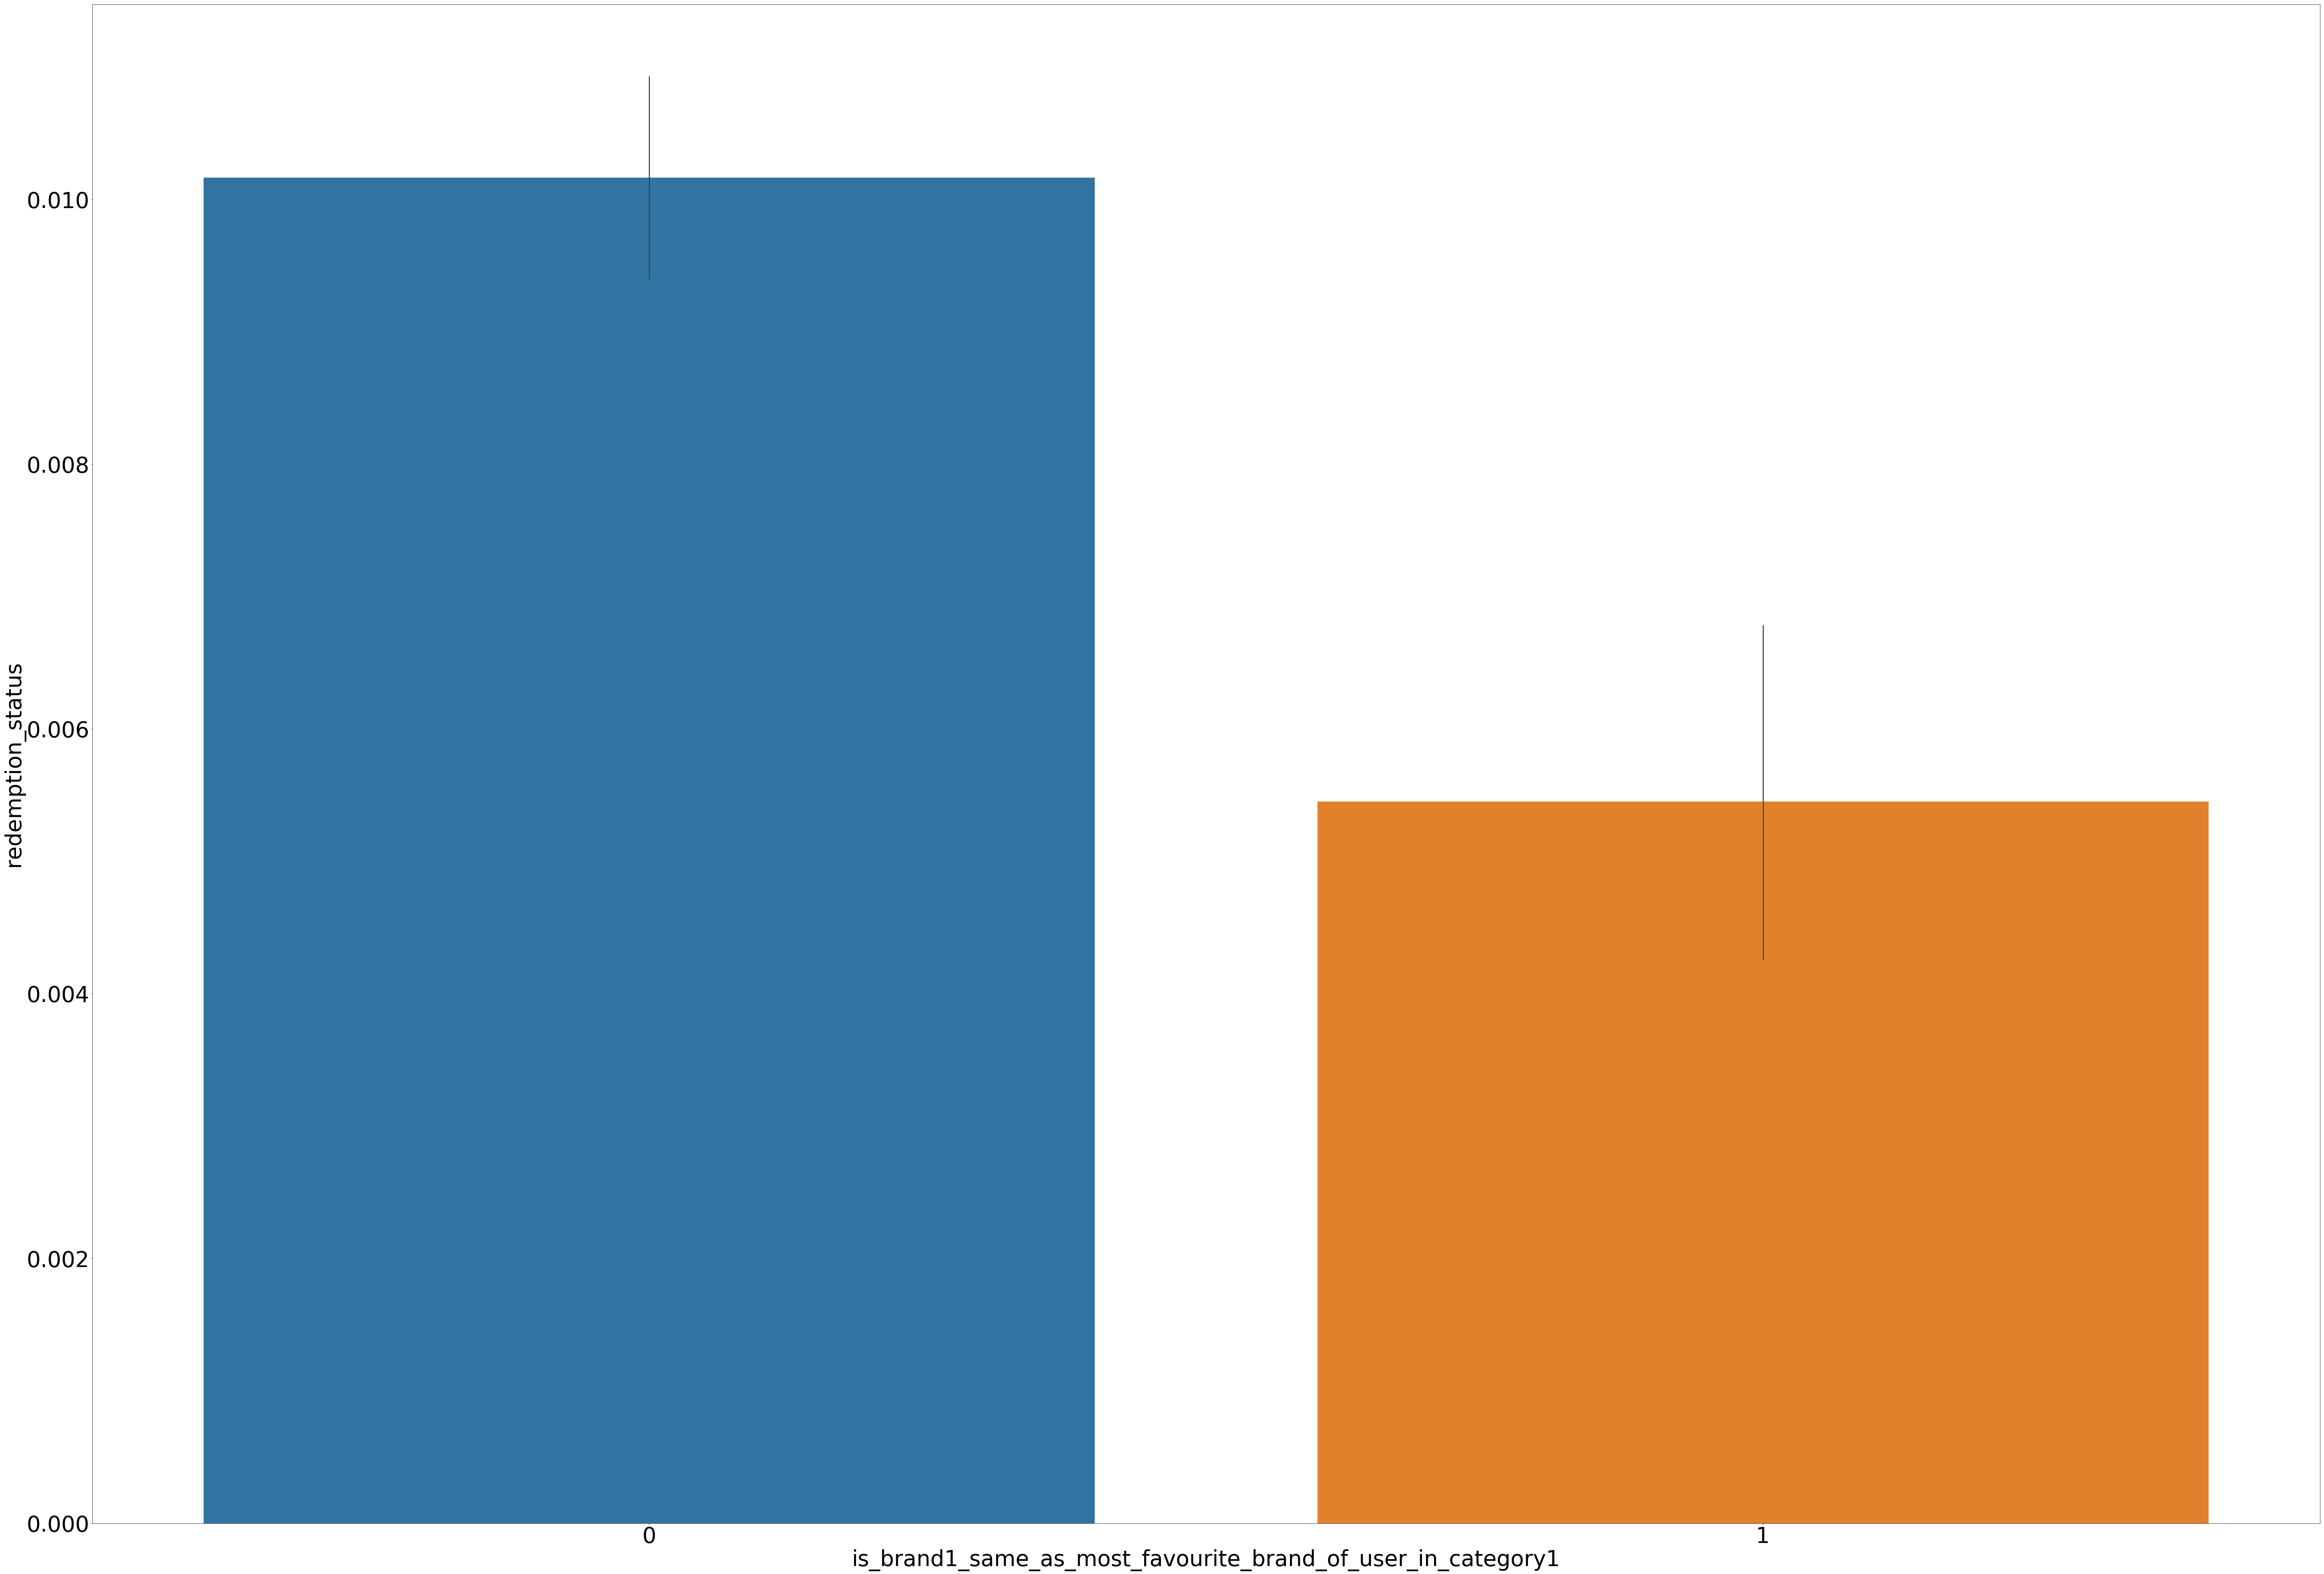

In [88]:
sns.barplot(x="is_brand1_same_as_most_favourite_brand_of_user_in_category1", y="redemption_status", data=merged_data)

### is_brand2_same_as_most_favourite_brand_of_user_in_category1

In [91]:
def get_fouvorite_brand2_mapping(row):
    try:
        if (favourite_brand1_on_categories[row.customer_id, row.coupon_available_on_category_1] == row.coupon_available_on_brand_2):
            return 1
        else:
            return 0
    except:
        return 0
merged_data['is_brand2_same_as_most_favourite_brand_of_user_in_category1'] = merged_data.apply(get_fouvorite_brand2_mapping, axis=1)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


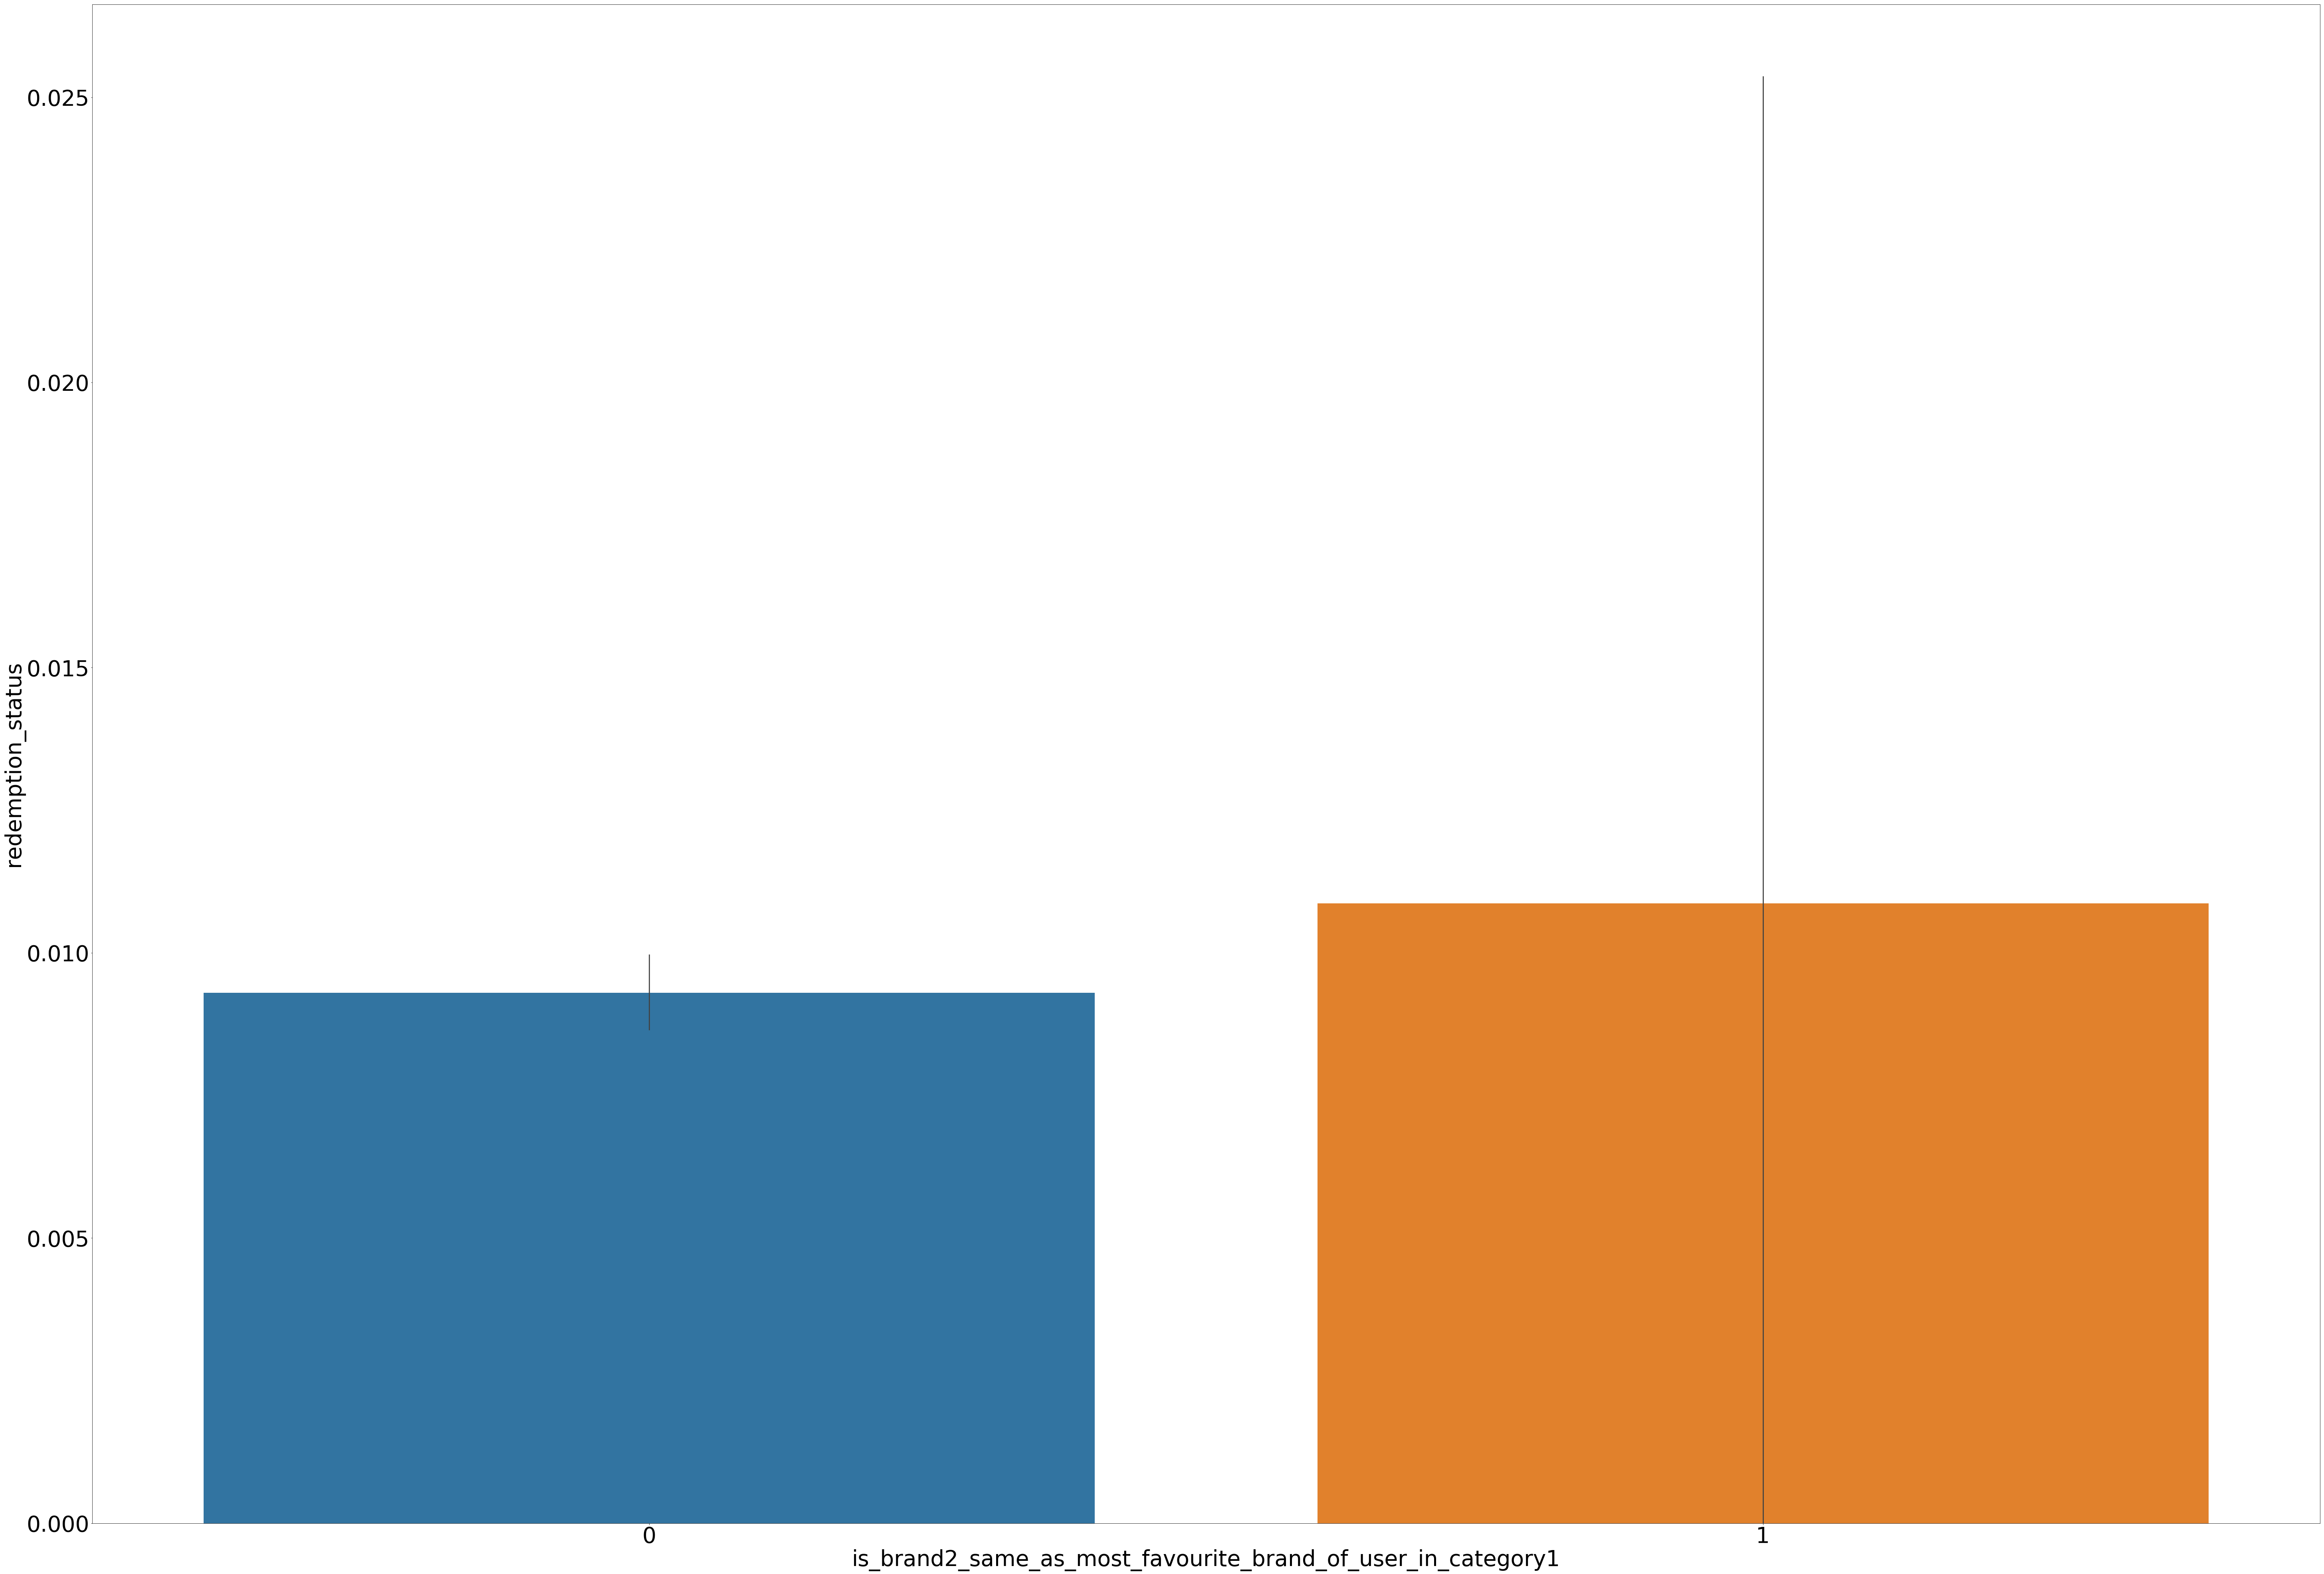

In [92]:
sns.barplot(x="is_brand2_same_as_most_favourite_brand_of_user_in_category1", y="redemption_status", data=merged_data)

### is_brand1_same_as_second_most_favourite_brand_of_user_in_category1

In [93]:
def get_secon_fouvorite_brand1_mapping(row):
    try:
        if (favourite_brand2_on_categories[row.customer_id, row.coupon_available_on_category_1] == row.coupon_available_on_brand_1):
            return 1
        else:
            return 0
    except:
        return 0
merged_data['is_brand1_same_as_second_most_favourite_brand_of_user_in_category1'] = merged_data.apply(get_secon_fouvorite_brand1_mapping, axis=1)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


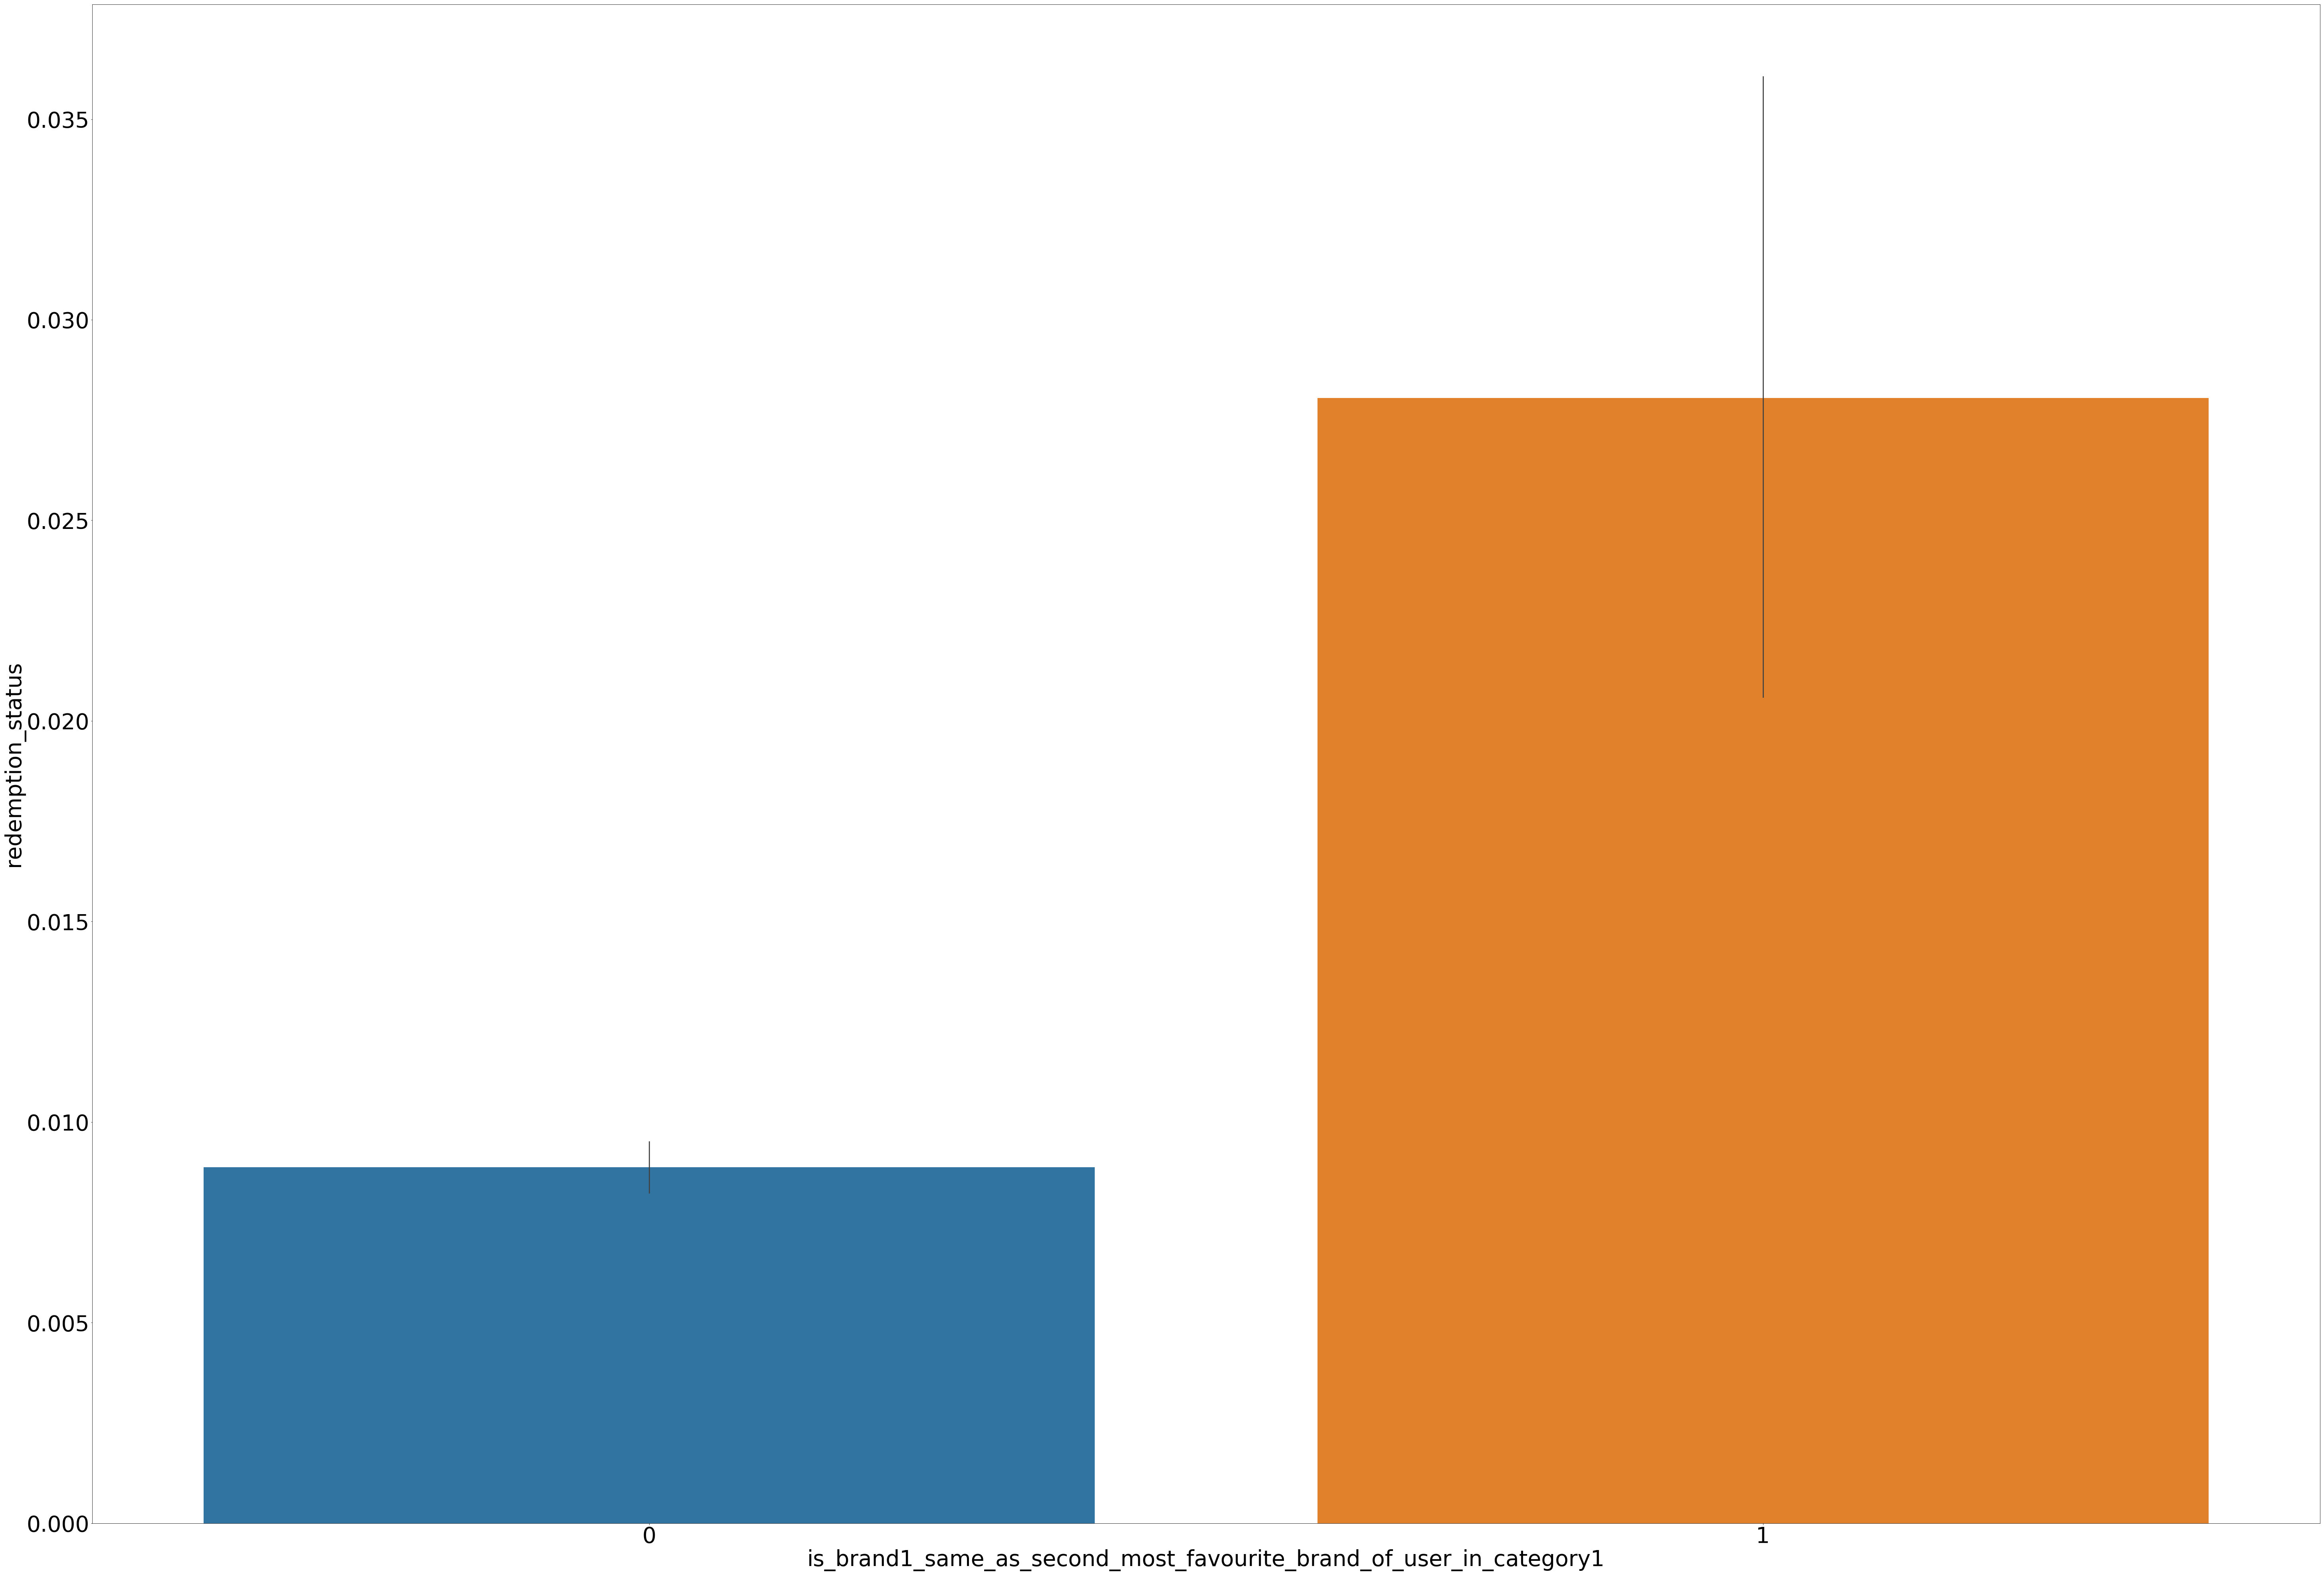

In [94]:
sns.barplot(x="is_brand1_same_as_second_most_favourite_brand_of_user_in_category1", y="redemption_status", data=merged_data)

### is_brand2_same_as_second_most_favourite_brand_of_user_in_category1

In [95]:
def get_secon_fouvorite_brand2_mapping(row):
    try:
        if (favourite_brand2_on_categories[row.customer_id, row.coupon_available_on_category_1] == row.coupon_available_on_brand_2):
            return 1
        else:
            return 0
    except:
        return 0
merged_data['is_brand2_same_as_second_most_favourite_brand_of_user_in_category1'] = merged_data.apply(get_secon_fouvorite_brand1_mapping, axis=1)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


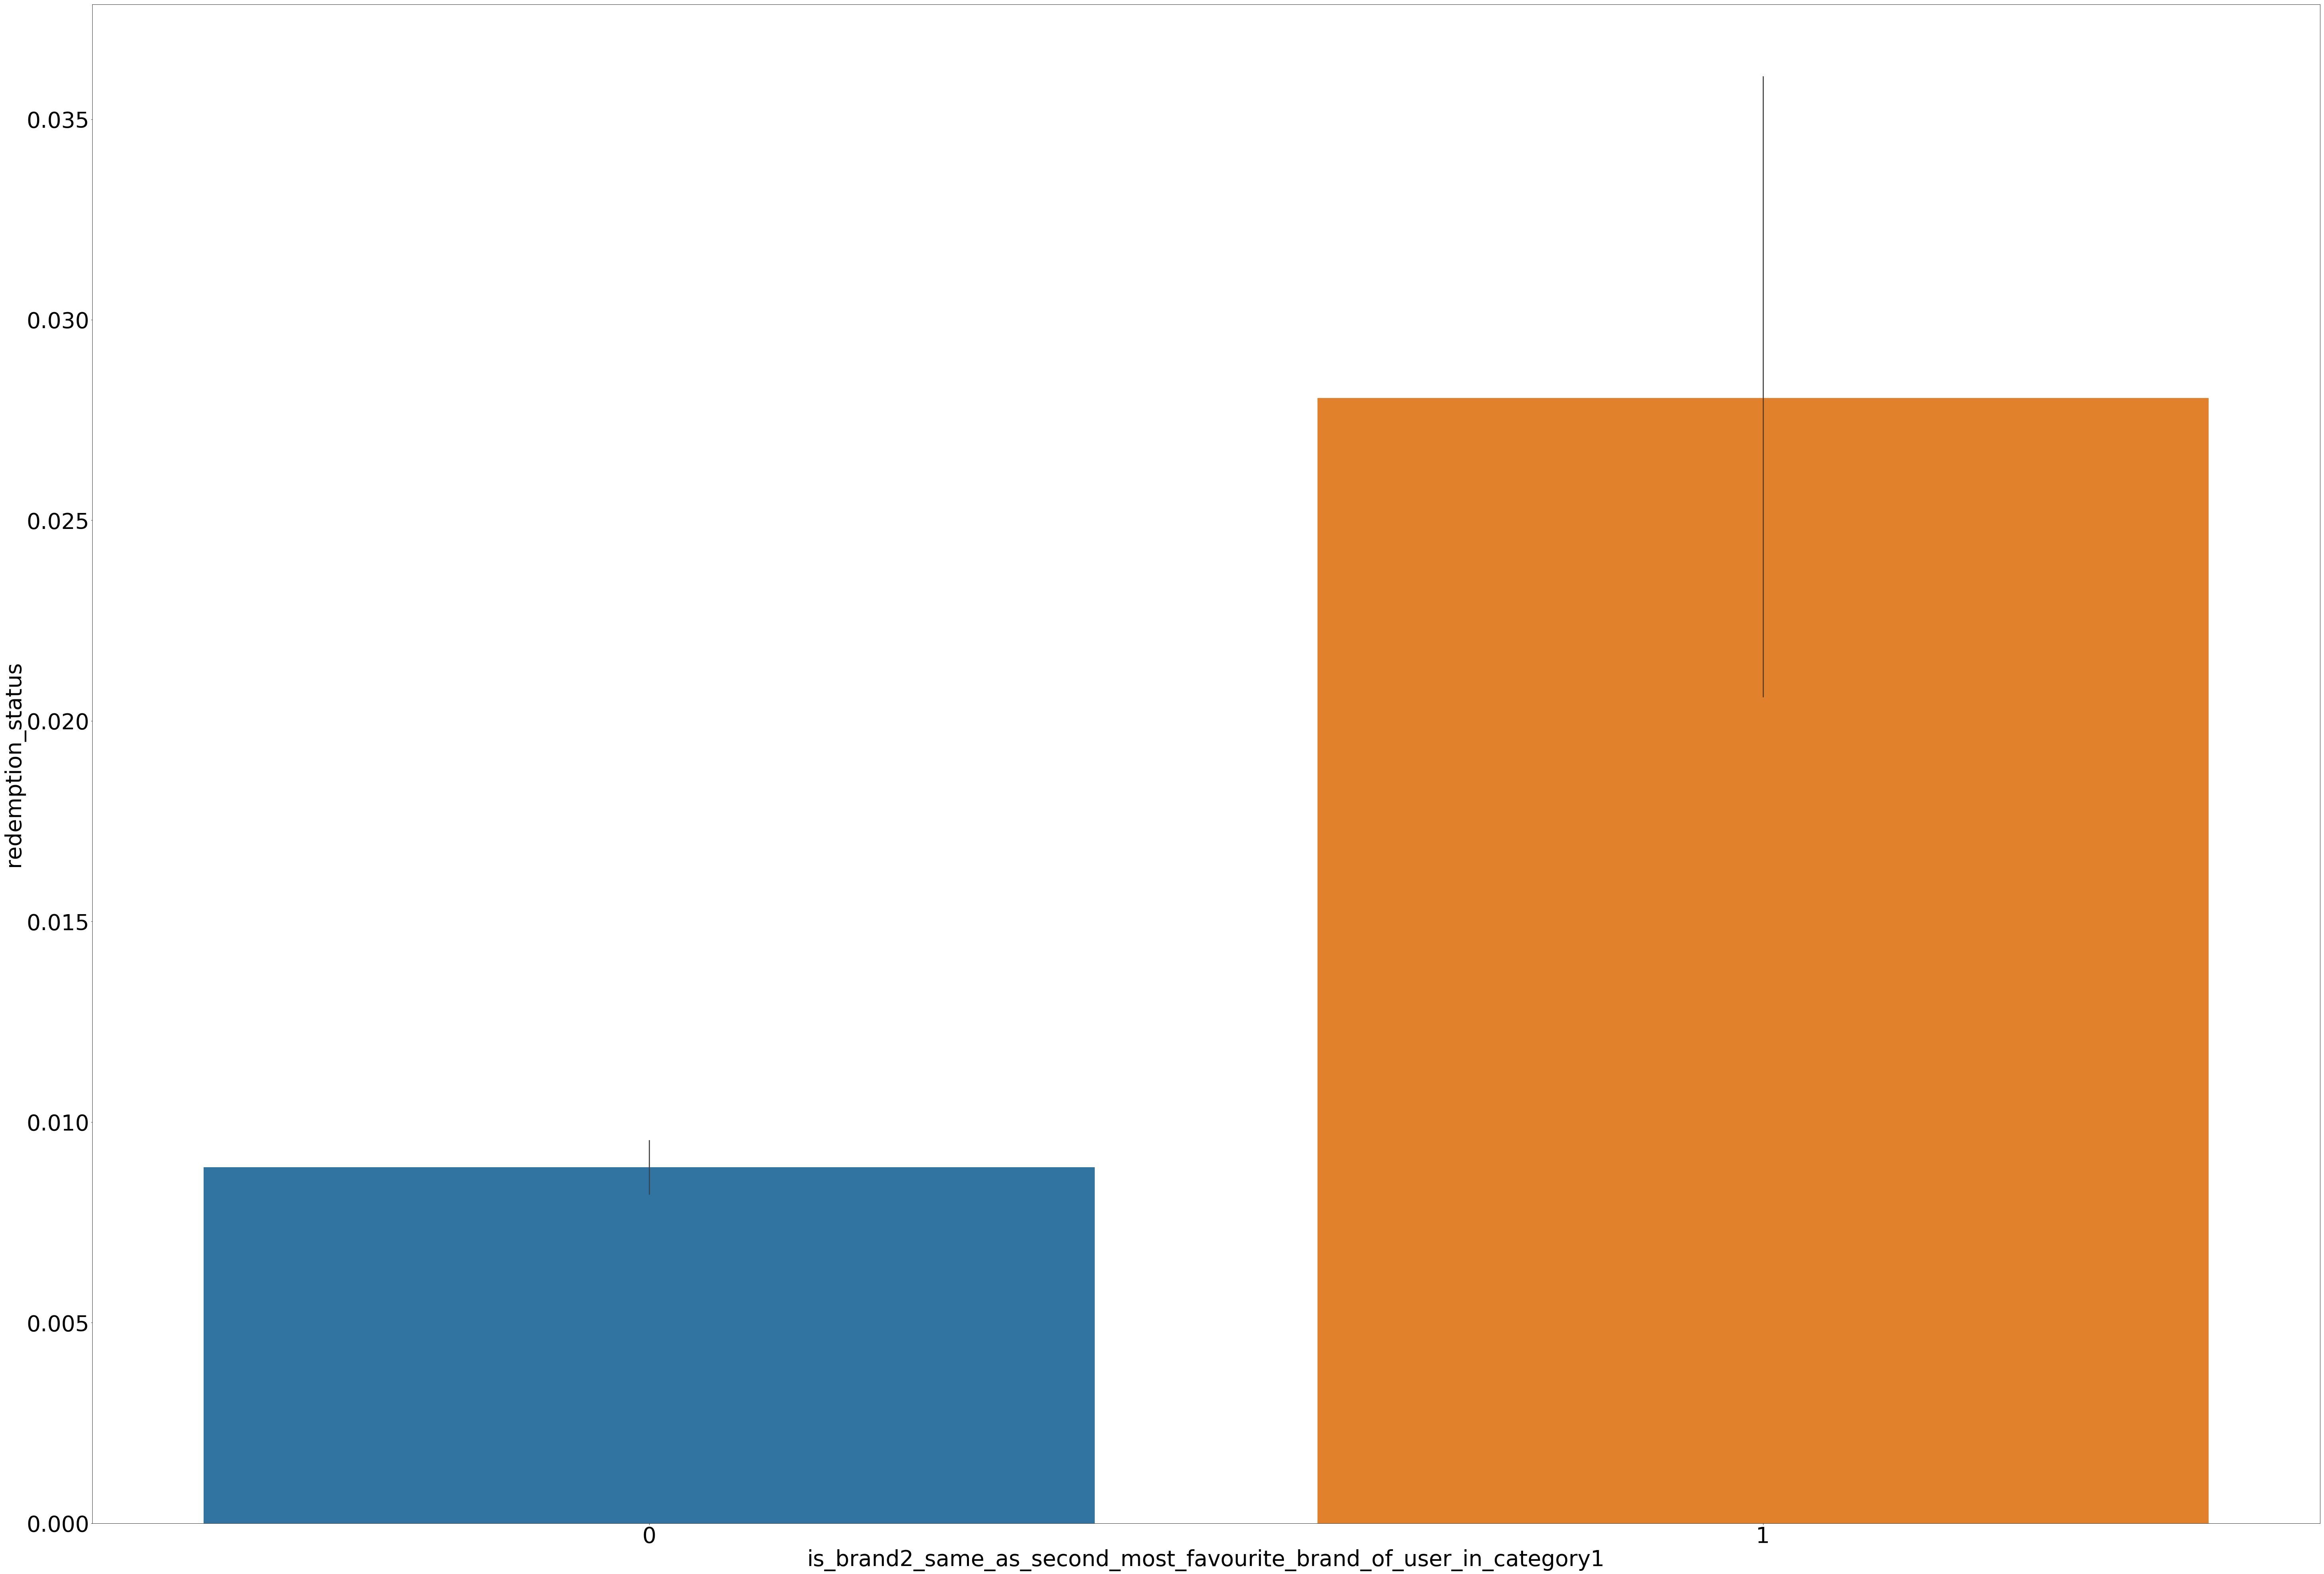

In [96]:
sns.barplot(x="is_brand2_same_as_second_most_favourite_brand_of_user_in_category1", y="redemption_status", data=merged_data)

## are_the_brands_customers_favourite_brands_for_category1

In [ ]:
are_the_brands_customers_favourite_brands_for_category1

In [98]:
def get_customers_favourite_brands_in_category1(row):
    if ((row.is_brand1_same_as_most_favourite_brand_of_user_in_category1) or 
        (row.is_brand2_same_as_most_favourite_brand_of_user_in_category1) or 
        (row.is_brand1_same_as_second_most_favourite_brand_of_user_in_category1) or
        (row.is_brand2_same_as_second_most_favourite_brand_of_user_in_category1)):
        return 1
    else:
        return 0
merged_data['are_the_brands_customers_favourite_brands_for_category1'] = merged_data.apply(get_customers_favourite_brands_in_category1, axis=1)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


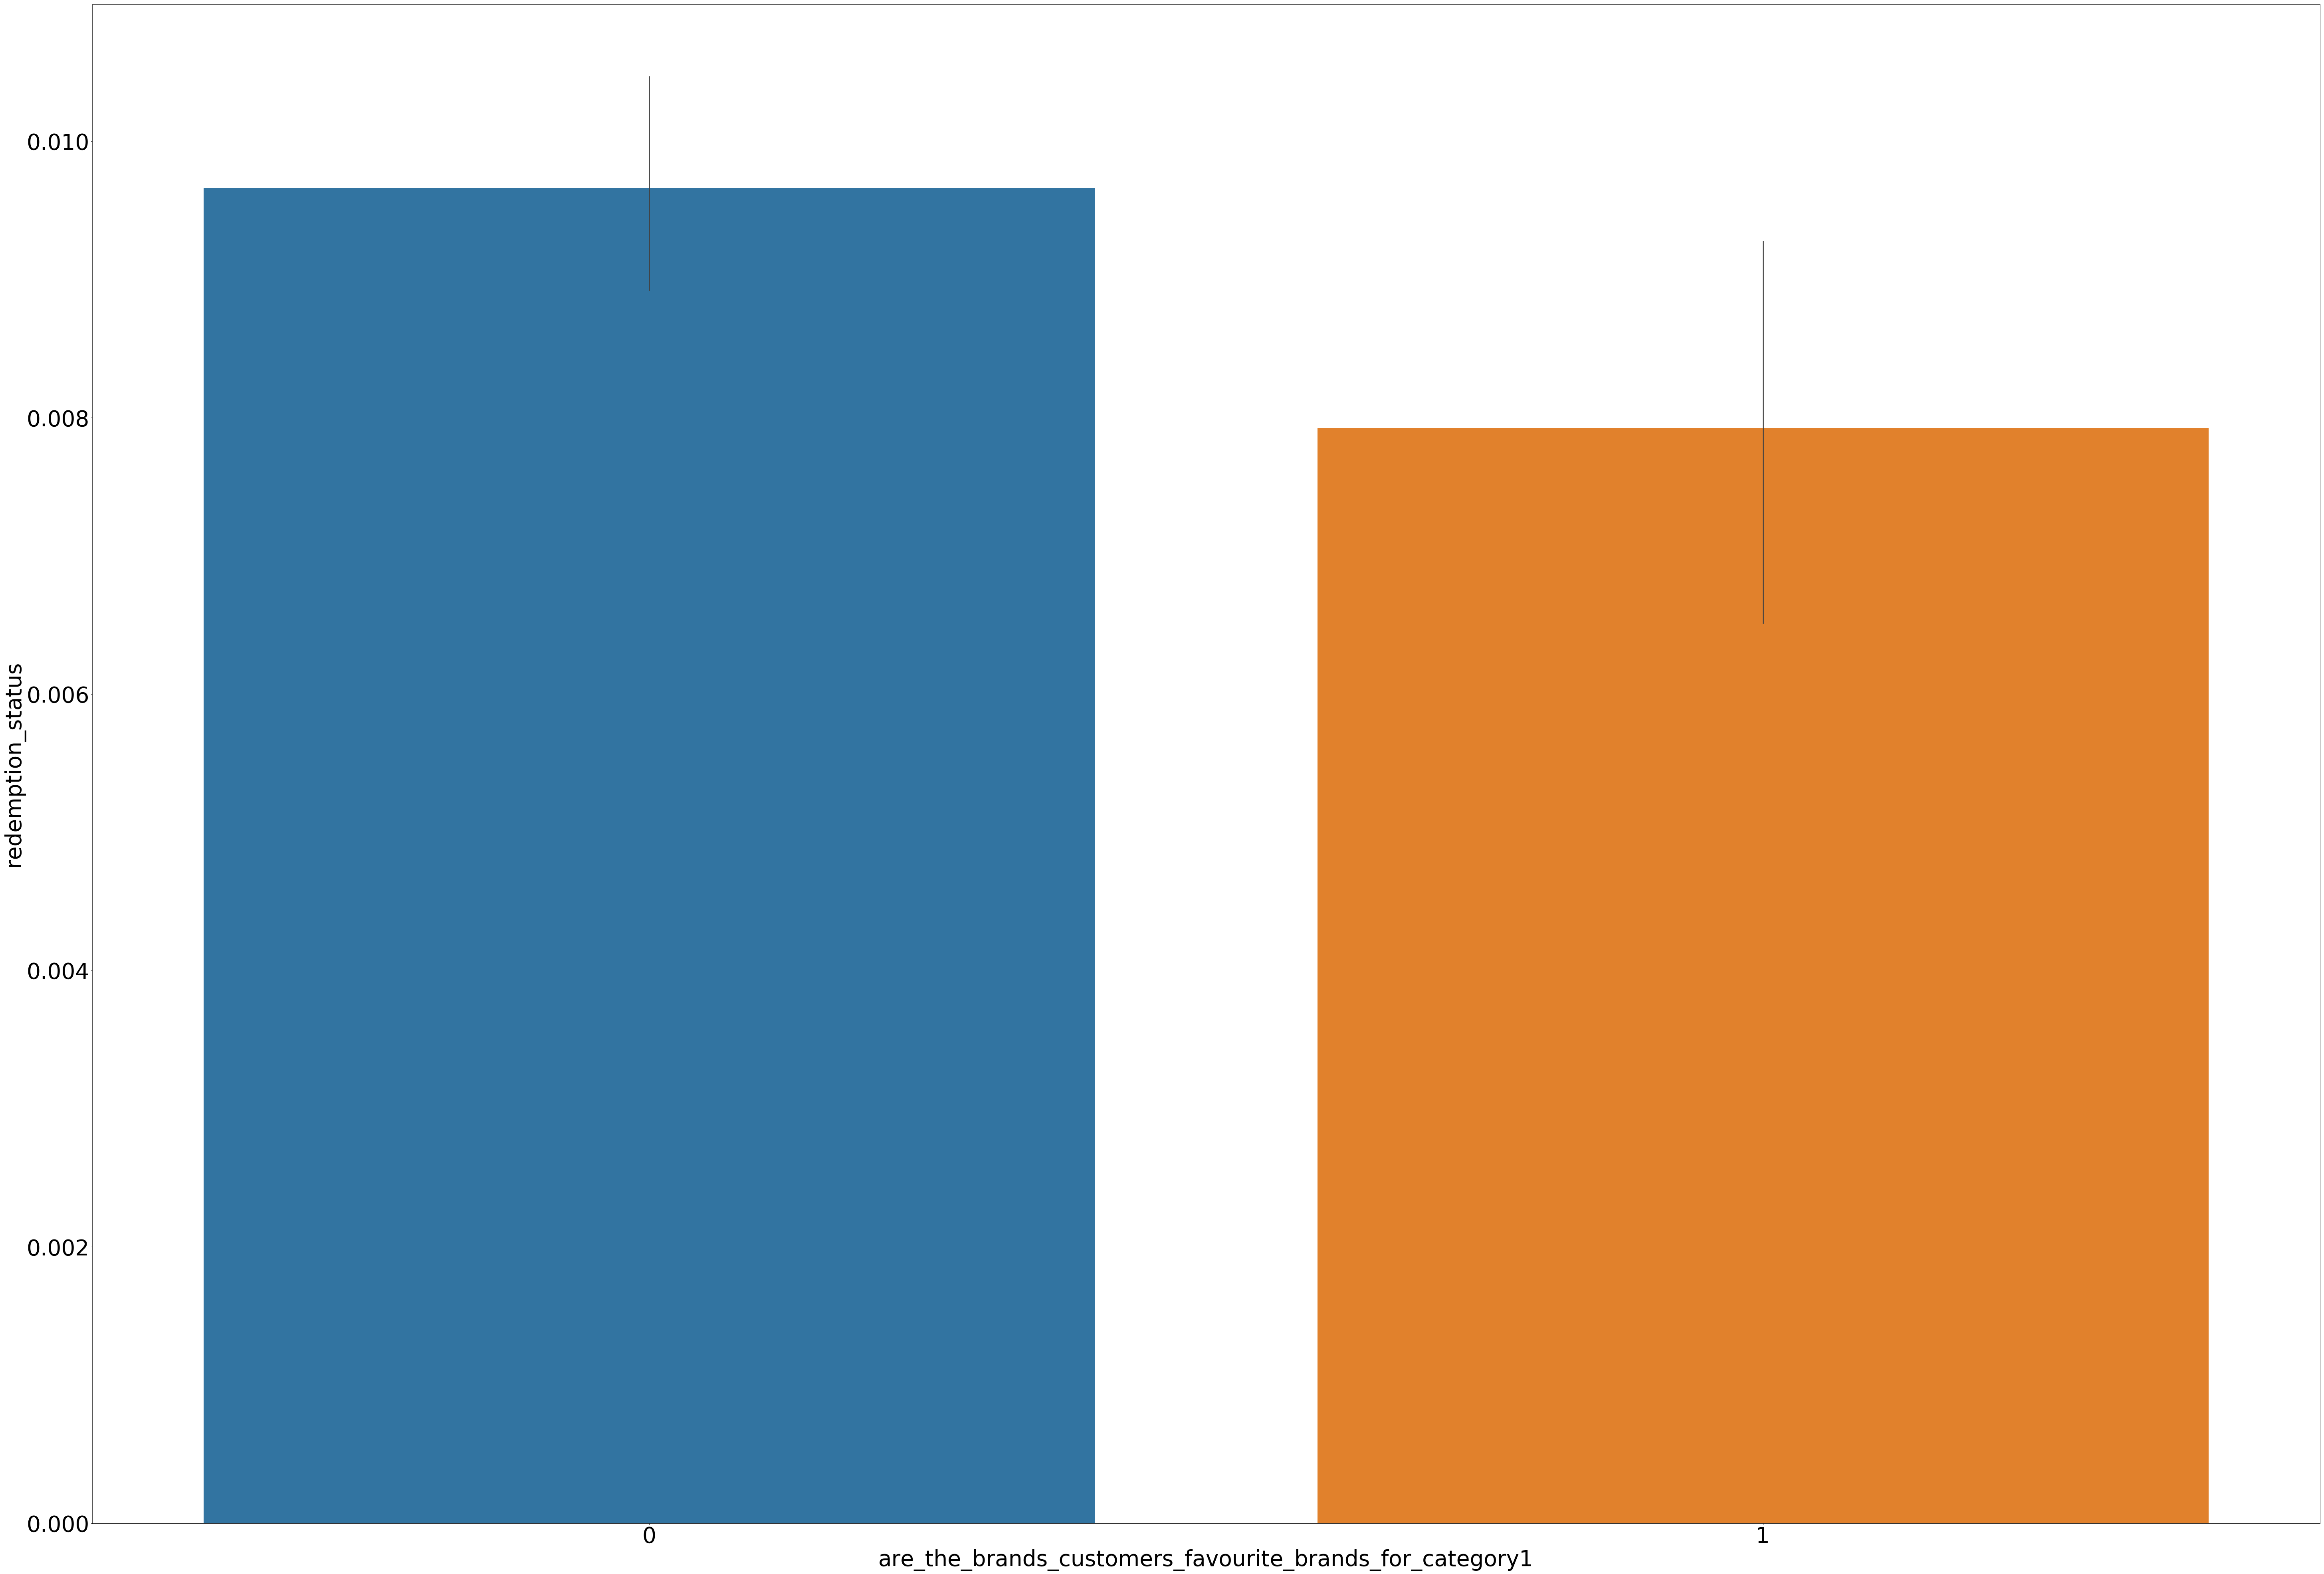

In [99]:
sns.barplot(x="are_the_brands_customers_favourite_brands_for_category1", y="redemption_status", data=merged_data)

Creating mapping of label encoded values to actual values

In [123]:
merged_data.coupon_available_on_category_1.value_counts()

3    86685
6    29867
4     5289
1     1811
8     1637
5     1589
0      758
7      702
2      257
Name: coupon_available_on_category_1, dtype: int64

In [124]:
merged_data[merged_data.coupon_available_on_category_1 == 0]

campaign_id  coupon_id  customer_id      id  is_test  \
23               21        958          922      64        1   
79               18        178          148     211        1   
239              21        958          538     606        1   
699              18        178         1056    1765        1   
777              18        178         1170    1945        1   
...             ...        ...          ...     ...      ...   
128137           13        123         1105  127837        0   
128321           13        169         1052  128145        0   
128387           10        106         1093  128255        0   
128529           13        164         1559  128488        0   
128548           13        164         1042  128521        0   

        redemption_status  campaign_type campaign_start_date  \
23                    NaN              1          2013-09-16   
79                    NaN              0          2013-08-10   
239                   NaN              1          2013-09-16   
699                   NaN              0          2013-08-10   
777                   NaN              0          2013-08-10   
...                   ...            ...                 ...   
128137                0.0              0          2013-05-19   
128321                0.0              0          2013-05-19   
128387                0.0              1          2013-04-08   
128529                0.0              0          2013-05-19   
128548                0.0              0          2013-05-19   

       campaign_end_date                       coupon_available_on_item_ids  \
23            2013-10-18  14395,59152,59036,61479,41462,20165,60387,5899...   
79            2013-10-04           25750,46235,42680,47265,59879,2794,59886   
239           2013-10-18  14395,59152,59036,61479,41462,20165,60387,5899...   
699           2013-10-04           25750,46235,42680,47265,59879,2794,59886   
777           2013-10-04           25750,46235,42680,47265,59879,2794,59886   
...                  ...                                                ...   
128137        2013-07-05  41223,25750,46235,2379,42680,47265,59879,41907...   
128321        2013-07-05  4559,43643,42678,42239,186,14516,17869,43540,4...   
128387        2013-05-10                              182,50975,32437,50970   
128529        2013-07-05  14395,59152,59036,61479,20165,60387,41462,5915...   
128548        2013-07-05  14395,59152,59036,61479,20165,60387,41462,5915...   

        customer_age_range  customer_marital_status  is_customer_rented  \
23                       6                        1                 0.0   
79                      -1                       -1                -1.0   
239                     -1                       -1                -1.0   
699                      3                        0                 0.0   
777                      3                        0                 0.0   
...                    ...                      ...                 ...   
128137                  -1                       -1                -1.0   
128321                  -1                       -1                -1.0   
128387                   4                        1                 0.0   
128529                  -1                       -1                -1.0   
128548                  -1                       -1                -1.0   

        customer_family_size  customer_no_of_children  \
23                         2                        0   
79                        -1                       -1   
239                       -1                       -1   
699                        1                        0   
777                        1                        0   
...                      ...                      ...   
128137                    -1                       -1   
128321                    -1                       -1   
128387                     4                        2   
128529                    -1                      

### coupon_discount_claimed_by_user_on_category1

In [116]:
total_coupon_discount_on_category = customer_transaction_data_on_coupons.groupby(by=['customer_id', 'category'])['coupon_discount'].agg('sum')
total_coupon_discount_on_category = total_coupon_discount_on_category*-1
total_coupon_discount_on_category

customer_id  category        
1            Grocery             1574.01
             Packaged Meat        130.03
             Pharmaceutical       412.79
2            Grocery              213.72
             Pharmaceutical        35.62
                                  ...   
1578         Pharmaceutical       106.86
1579         Grocery              338.39
1582         Grocery             1250.94
             Natural Products      24.94
             Pharmaceutical      1040.08
Name: coupon_discount, Length: 2562, dtype: float64

In [120]:
def get_total_coupon_discount_on_category1 (row):
    try:
        return total_coupon_discount_on_category[row.customer_id, row.coupon_available_on_category_1]
    except:
        return 0
merged_data['coupon_discount_claimed_by_user_on_category1'] = merged_data.apply(get_total_coupon_discount_on_category1, axis=1)

In [121]:
merged_data['coupon_discount_claimed_by_user_on_category1']

0         0
1         0
2         0
3         0
4         0
         ..
128590    0
128591    0
128592    0
128593    0
128594    0
Name: coupon_discount_claimed_by_user_on_category1, Length: 128595, dtype: int64

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


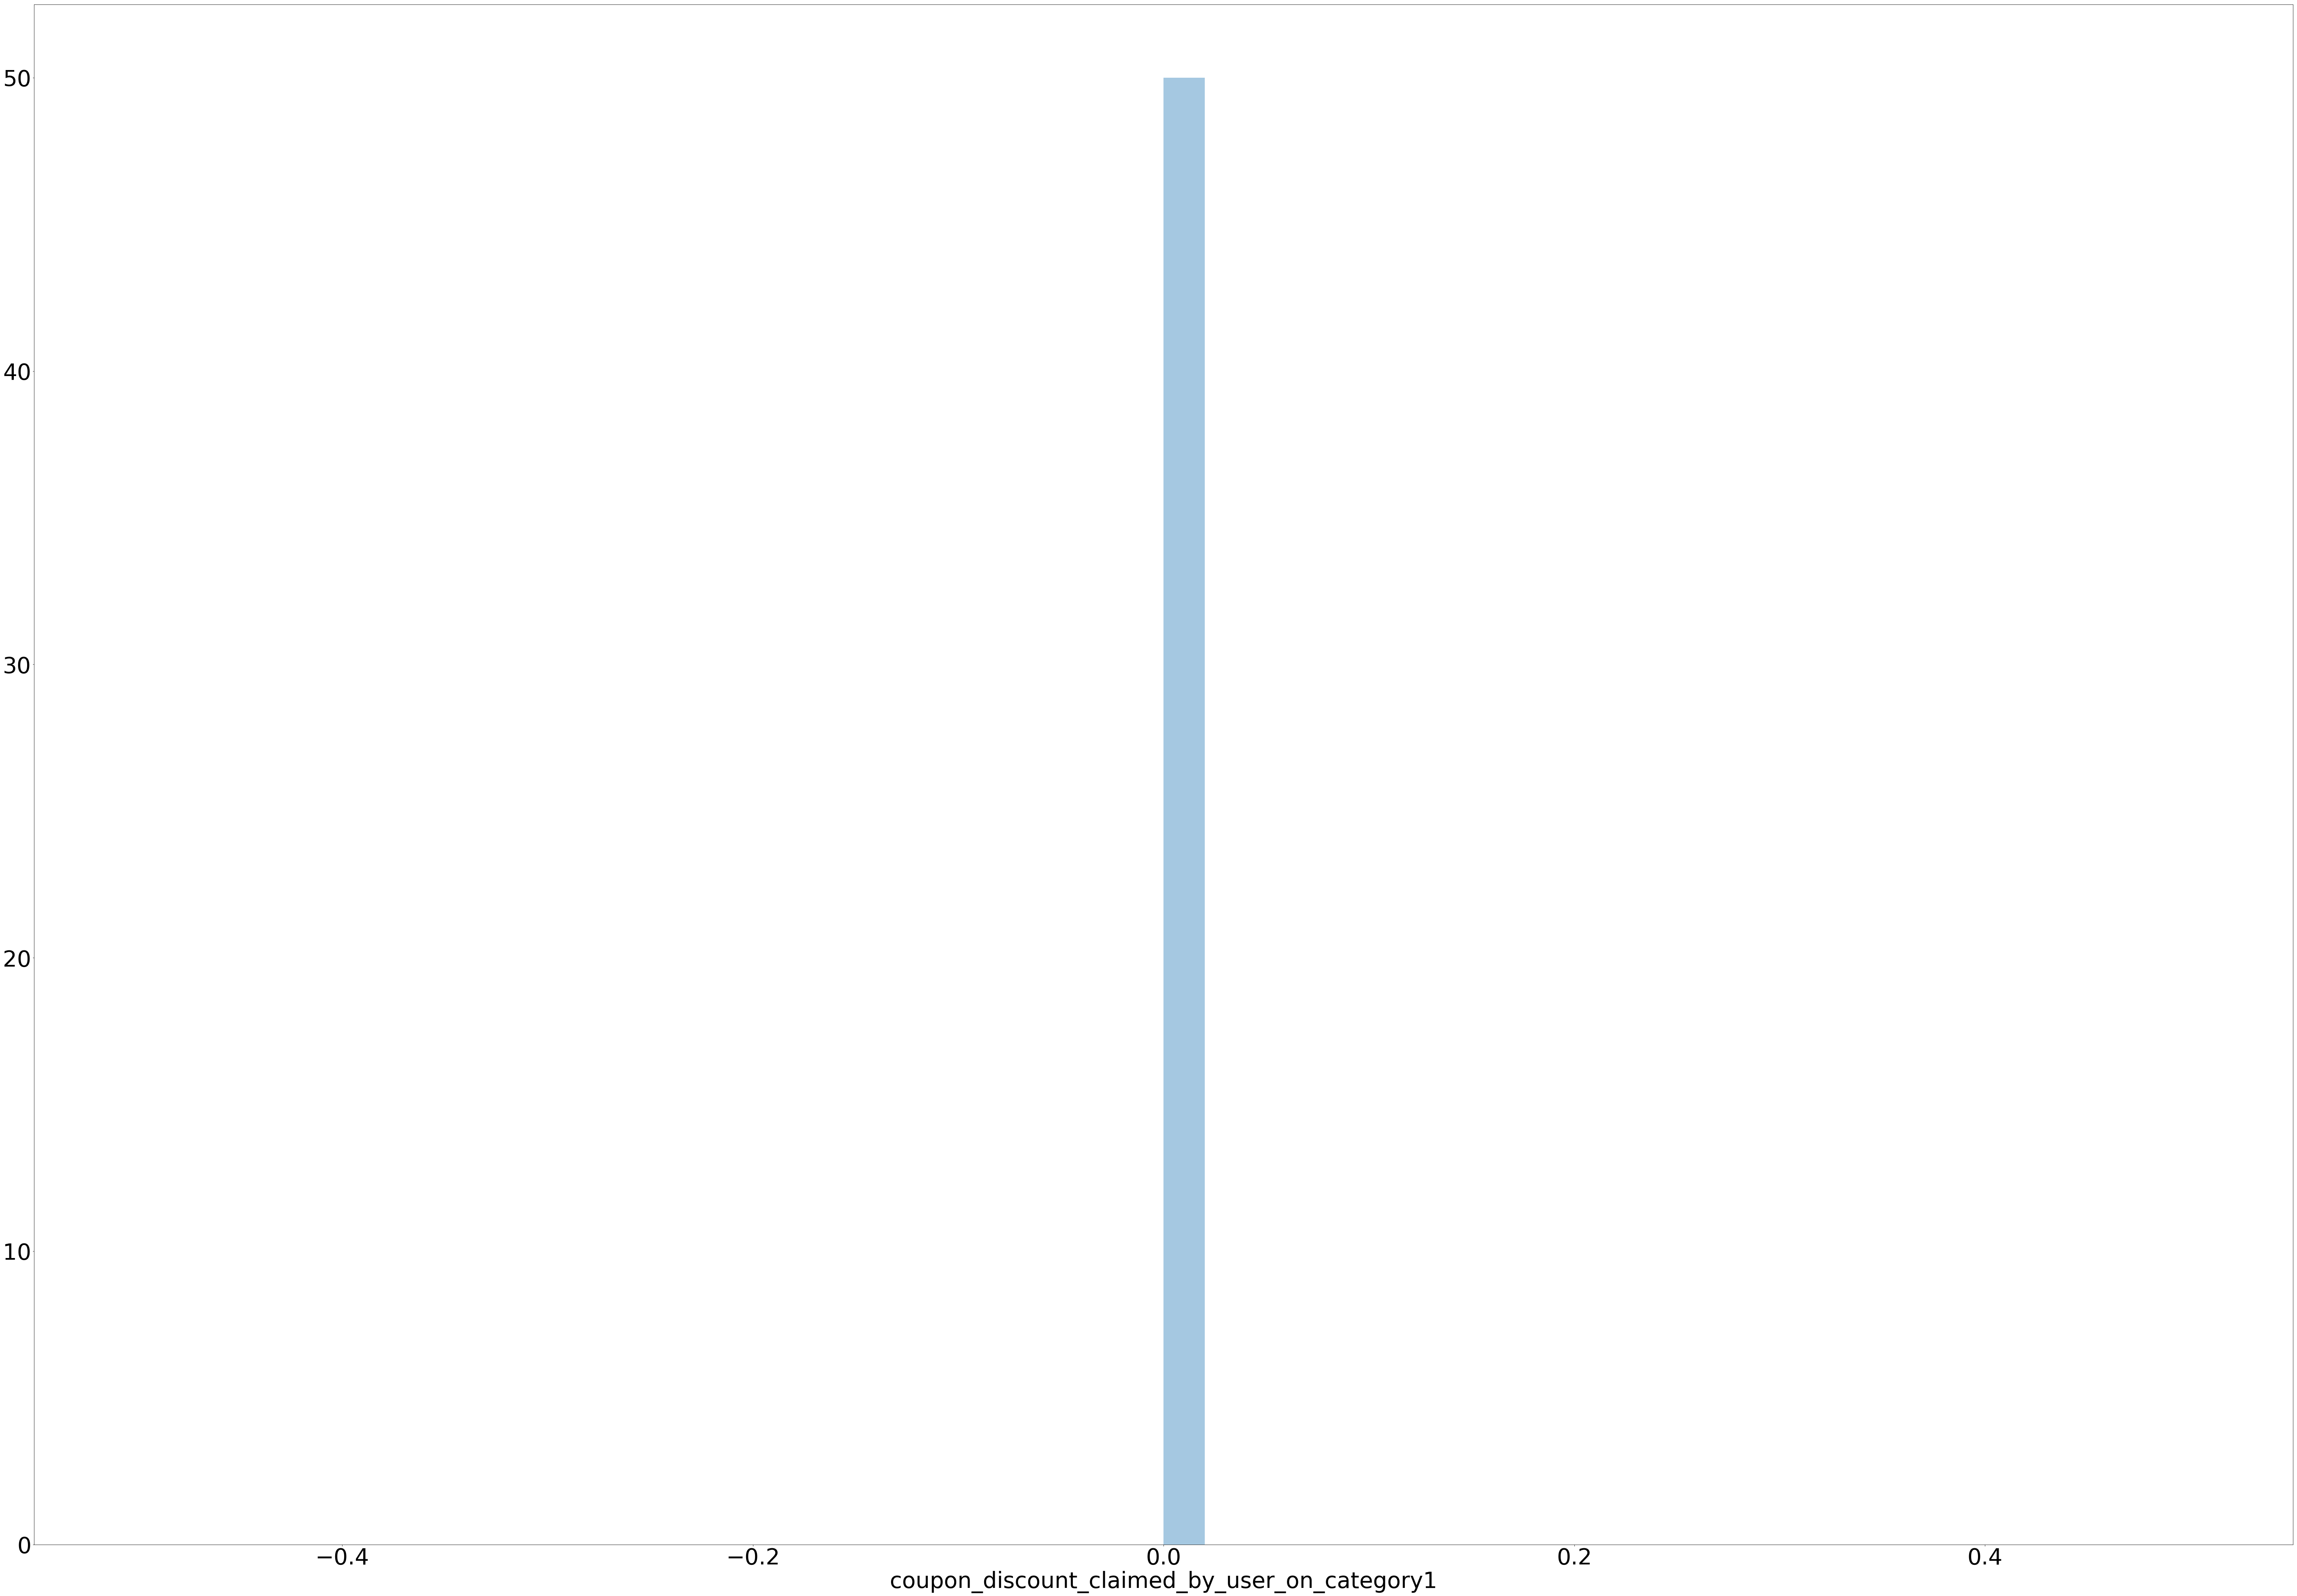

In [118]:
sns.distplot(merged_data['coupon_discount_claimed_by_user_on_category1'])

In [112]:
merged_data.columns

Index(['campaign_id', 'coupon_id', 'customer_id', 'id', 'is_test',
       'redemption_status', 'campaign_type', 'campaign_start_date',
       'campaign_end_date', 'coupon_available_on_item_ids',
       'customer_age_range', 'customer_marital_status', 'is_customer_rented',
       'customer_family_size', 'customer_no_of_children',
       'customer_income_bracket',
       'is_common_demographic_info_available_for_customer',
       'no_of_items_coupon_is_available_for',
       'is_coupon_available_for_multiple_item_ids',
       'no_of_categories_of_items_available_under_coupon',
       'coupon_available_on_category_1', 'coupon_available_on_category_2',
       'coupon_available_on_brand_1', 'coupon_available_on_brand_2',
       'coupon_more_focussed_on_brand_type', 'popularity_of_category1',
       'popularity_of_category2', 'popularity_of_brand1',
       'popularity_of_brand2', 'mean_discount_on_category1',
       'mean_discount_on_category2', 'mean_discount_on_brand1',
       'mean_discou

In [52]:
customer_transaction_data

date  customer_id  item_id  quantity  selling_price  \
0      2012-01-02         1501    26830         1          35.26   
1      2012-01-02         1501    54253         1          53.43   
2      2012-01-02         1501    31962         1         106.50   
3      2012-01-02         1501    33647         1          67.32   
4      2012-01-02         1501    48199         1          71.24   
...           ...          ...      ...       ...            ...   
21281  2013-07-03          384    12071         1          53.43   
21282  2013-07-03          384    22269         1          53.43   
21283  2013-07-03          384    33382         2         106.86   
21284  2013-07-03         1303    69686         1          78.36   
21285  2013-07-03          621    72243         1         138.56   

       other_discount  coupon_discount  brand   brand_type          category  
0              -10.69             0.00     56        Local  Natural Products  
1              -13.89             0.00     56        Local  Natural Products  
2              -14.25             0.00    524  Established           Grocery  
3                0.00             0.00   1134  Established           Grocery  
4              -28.14             0.00    524  Established           Grocery  
...               ...              ...    ...          ...               ...  
21281          -26.71           -17.81   1105  Established           Grocery  
21282          -26.71           -17.81   1105  Established           Grocery  
21283          -53.43           -35.62   1105  Established           Grocery  
21284            0.00           -35.62    522  Established           Grocery  
21285            0.00           -35.62   2134  Established    Pharmaceutical  

[1324566 rows x 10 columns]

## Saving features

In [101]:
merged_data.dtypes

campaign_id                                                           int64
coupon_id                                                             int64
customer_id                                                           int64
id                                                                    int64
is_test                                                               int64
                                                                      ...  
is_brand1_same_as_most_favourite_brand_of_user_in_category1           int64
is_brand2_same_as_second_most_favourite_brand_of_user_in_category1    int64
is_brand2_same_as_most_favourite_brand_of_user_in_category1           int64
is_brand1_same_as_second_most_favourite_brand_of_user_in_category1    int64
are_the_brands_customers_favourite_brands_for_category1               int64
Length: 72, dtype: object

In [102]:
columns_with_other_dtype = merged_data.select_dtypes(include=['object', 'datetime64[ns]']).columns
columns_with_numeric_dtype = merged_data.select_dtypes(exclude='object').columns
columns_with_numeric_dtype

Index(['campaign_id', 'coupon_id', 'customer_id', 'id', 'is_test',
       'redemption_status', 'customer_age_range', 'customer_marital_status',
       'is_customer_rented', 'customer_family_size', 'customer_no_of_children',
       'customer_income_bracket',
       'is_common_demographic_info_available_for_customer',
       'no_of_items_coupon_is_available_for',
       'is_coupon_available_for_multiple_item_ids',
       'no_of_categories_of_items_available_under_coupon',
       'coupon_available_on_brand_1', 'coupon_available_on_brand_2',
       'popularity_of_category1', 'popularity_of_category2',
       'popularity_of_brand1', 'popularity_of_brand2',
       'mean_discount_on_category1', 'mean_discount_on_category2',
       'mean_discount_on_brand1', 'mean_discount_on_brand2',
       'no_of_times_customer_bought_category1',
       'no_of_times_customer_bought_category2',
       'no_of_times_customer_bought_brand1',
       'no_of_times_customer_bought_brand2',
       'no_of_times_custom

In [105]:
categorical_columns = columns_with_other_dtype.drop(labels=['campaign_start_date', 'campaign_end_date', 'coupon_available_on_item_ids'])
numerical_columns = columns_with_numeric_dtype.drop(labels=['coupon_id', 'customer_id', 'id'])
features = numerical_columns.append(categorical_columns)
features

Index(['campaign_id', 'is_test', 'redemption_status', 'customer_age_range',
       'customer_marital_status', 'is_customer_rented', 'customer_family_size',
       'customer_no_of_children', 'customer_income_bracket',
       'is_common_demographic_info_available_for_customer',
       'no_of_items_coupon_is_available_for',
       'is_coupon_available_for_multiple_item_ids',
       'no_of_categories_of_items_available_under_coupon',
       'coupon_available_on_brand_1', 'coupon_available_on_brand_2',
       'popularity_of_category1', 'popularity_of_category2',
       'popularity_of_brand1', 'popularity_of_brand2',
       'mean_discount_on_category1', 'mean_discount_on_category2',
       'mean_discount_on_brand1', 'mean_discount_on_brand2',
       'no_of_times_customer_bought_category1',
       'no_of_times_customer_bought_category2',
       'no_of_times_customer_bought_brand1',
       'no_of_times_customer_bought_brand2',
       'no_of_times_customer_bought_category1_in_discount',
       

In [106]:
labelEncoder = LabelEncoder()


for feature in categorical_columns:
    print("Handling: ", feature)
    merged_data[feature] = labelEncoder.fit_transform(merged_data[feature])


merged_data

Handling:  campaign_type
Handling:  coupon_available_on_category_1
Handling:  coupon_available_on_category_2
Handling:  coupon_more_focussed_on_brand_type
Handling:  most_bought_category_of_user


campaign_id  coupon_id  customer_id      id  is_test  \
0                22        869          967       3        1   
1                20        389         1566       4        1   
2                22        981          510       5        1   
3                25       1069          361       8        1   
4                17        498          811      10        1   
...             ...        ...          ...     ...      ...   
128590            8         71         1523  128587        0   
128591           30        547          937  128589        0   
128592            8        754         1004  128590        0   
128593           13        134           71  128592        0   
128594           13        681          623  128595        0   

        redemption_status  campaign_type campaign_start_date  \
0                     NaN              0          2013-09-16   
1                     NaN              1          2013-09-07   
2                     NaN              0          2013-09-16   
3                     NaN              1          2013-10-21   
4                     NaN              1          2013-07-29   
...                   ...            ...                 ...   
128590                0.0              0          2013-02-16   
128591                0.0              0          2012-11-19   
128592                0.0              0          2013-02-16   
128593                0.0              0          2013-05-19   
128594                0.0              0          2013-05-19   

       campaign_end_date                       coupon_available_on_item_ids  \
0             2013-10-18  1124,1185,39835,46911,3514,1033,45271,56179,40...   
1             2013-11-16  47705,45063,19431,56517,1479,68534,56523,1144,...   
2             2013-10-18  1690,7061,58004,22631,6577,2398,41769,21773,33...   
3             2013-11-22  10284,70009,57994,11281,44510,35356,29737,6994...   
4             2013-08-30  45021,54805,14259,37463,48668,16481,4078,19852...   
...                  ...                                                ...   
128590        2013-04-05                             17029,1657,30155,12762   
128591        2013-01-04            2596,18777,53061,42386,43044,3318,39336   
128592        2013-04-05  70460,70534,9060,27164,58588,20849,5608,24948,...   
128593        2013-07-05            62219,1357,38776,41148,32563,62457,4047   
128594        2013-07-05  44676,33551,16298,28879,40280,18577,13290,7323...   

        customer_age_range  customer_marital_status  is_customer_rented  \
0                        3                        0                 0.0   
1                        2                        1                 0.0   
2                        2                        1                 0.0   
3                        1                        0                 0.0   
4                       -1                       -1                -1.0   
...                    ...                      ...                 ...   
128590                   6                        1                 0.0   
128591                   6                        1                 0.0   
128592                  -1                       -1                -1.0   
128593                   3                        1                 0.0   
128594                  -1                       -1                -1.0   

        customer_family_size  customer_no_of_children  \
0                          1                        0   
1                          2                        0   
2                          2                        1   
3                          1                        0   
4                         -1                       -1   
...                      ...                      ...   
128590                     2                        0   
128591                     2                        0   
128592                    -1                       -1   
128593                     5                      

In [107]:
name = "../data/train/merged_data_after_feature_engineering"+".csv"
merged_data.to_csv( name,index=False)
print ("File Saved!")

File Saved!
